In [1]:
# To make sure Python can import from reservoirs/ and utils/ etc. when running the notebook from notebooks/
import sys
import os
sys.path.append(os.path.abspath(".."))  # go up one directory to parent

In [2]:
# --- Standard scientific libraries ---
import itertools, tqdm, warnings, numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D  # for 3D plotting
from pathlib import Path
from matplotlib.gridspec import GridSpec
from scipy.spatial import cKDTree, distance
from numpy.linalg import norm
from scipy.signal import hilbert, find_peaks 
from sklearn.linear_model import Ridge
import inspect
from scipy.spatial.distance import pdist, cdist, squareform
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401
from scipy import signal
from pathlib import Path
from sklearn.neighbors import NearestNeighbors
from matplotlib.patches import Patch

# --- Reservoir implementations ---
from reservoirs.cycle import CycleReservoir3D, CRJRes3D
from reservoirs.sparse import SparseESN3D
#from reservoirs.mci_esn import MCI3D
#from reservoirs.parallel_esn import ParallelESN
from reservoirs.deep_esn import DeepESN3D
from reservoirs.small_world import SWRes3D_IO
#from reservoirs.hyper import HyperbolicRes, EuclideanRes, SphericalRes
#from reservoirs.hfr import HFR3D
#from reservoirs.bei_stp import BEISTPReservoirESN
#from reservoirs.swirl_gated_multicycle import SwirlGatedMultiCycleESN
#from reservoirs.resonator import ResonatorReservoirESN
#from reservoirs.glia_neuron import GliaNeuronTripartiteReservoirESN
#from reservoirs.diffusion_wavelet import DiffusionWaveletReservoirESN, adj
#from reservoirs.short_term_plasticity import STPESN
#from reservoirs.ltsr import LTSRRes3D
#from reservoirs.tgc import TGCCoupledESN
#from reservoirs.TCBESN import TCBESN
from reservoirs.hlesn import HLESN

# --- Utility modules ---
from utils.datasets import generate_lorenz_data, generate_rossler_data, generate_chen_data, generate_chua_data, generate_mackey_glass_data
from utils.metrics import compute_valid_prediction_time, compute_attractor_deviation, evaluate_nrmse, mse_dimwise
from utils.plotting import plot_timeseries, plot_lorenz_3d
from utils.dynamics import *


In [3]:
warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
FIG_DIR = Path("/Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures"); FIG_DIR.mkdir(exist_ok=True)

In [4]:
# Utilities

def create_delay_embedding(signal, embed_dim):
    L = len(signal) - embed_dim + 1
    emb = np.zeros((L, embed_dim))
    for i in range(L):
        emb[i, :] = signal[i:i+embed_dim]
    return emb

# Unified experiment driver for cannonical chaotic benchmarks with one knob

In [12]:
# ============================================
# Unified driver with system-specific lambda_max
# ============================================


# -------- ONE KNOB for the chaotic system --------
SYSTEM = "lorenz"            # 'lorenz' | 'rossler' | 'chen-ueta'
DT      = 0.02
TMAX    = 250.0
WASHOUT = 2000

# -------- Per-system generator params (adapt to your funcs) --------
SYS_PARAMS = {
    "lorenz":   dict(sigma=10.0, rho=28.0, beta=8.0/3.0),
    "rossler":  dict(a=0.2, b=0.2, c=5.7),
    "chen-ueta":dict(a=35.0, b=3.0, c=28.0),   
}

# Map system -> generator 
def _system_call(system: str, init_state, tmax=TMAX, dt=DT):
    if system == "lorenz":
        return generate_lorenz_data(initial_state=init_state, tmax=tmax, dt=dt, **SYS_PARAMS["lorenz"])
    elif system == "rossler":
        return generate_rossler_data(initial_state=init_state, tmax=tmax, dt=dt, **SYS_PARAMS["rossler"])
    elif system in ("chen", "chen-ueta", "chen_ueta"):
        return generate_chen_data(initial_state=init_state, tmax=tmax, dt=dt, **SYS_PARAMS["chen-ueta"])
    else:
        raise ValueError(f"Unknown SYSTEM={system}")

# -------- lambda_max configuration --------
LAMBDA_MODE = "auto"   # "auto" (estimate from test data) or "fixed"
LAMBDA_MAP  = {
    "lorenz":    0.90,    # reference values 
    "rossler":   0.07,
    "chen-ueta": 2.038,
}

def _estimate_lambda_rosenstein(traj: np.ndarray, dt: float,
                                theiler: int = 50,
                                max_horizon: int = 200,
                                n_samples: int = 1500,
                                fit_range: tuple[int,int] = (5, 60)) -> float:
    """
    Rosenstein-style estimate of the largest Lyapunov exponent λ_max from a 3D trajectory.
    Returns λ_max (1/time). Robust enough for medium T; falls back to map if unstable.
    """
    X = np.asarray(traj, dtype=float)
    T, d = X.shape
    if d < 2 or T < theiler + max_horizon + 5:
        return np.nan

    # pick sample indices to form pairs
    idx_pool = np.arange(0, T - max_horizon - 1)
    if len(idx_pool) > n_samples:
        rng = np.random.default_rng(0)
        idx_pool = rng.choice(idx_pool, size=n_samples, replace=False)
    idx_pool.sort()

    # nearest neighbor search with Theiler window exclusion
    nbrs = NearestNeighbors(n_neighbors=2, algorithm="auto").fit(X)
    distances, indices = nbrs.kneighbors(X)
    nn = np.empty_like(indices[:, 1])
    for i in range(T):
        # default: nearest neighbor index (excluding self is usually at slot 1)
        j = indices[i, 1]
        # if within Theiler, search further neighbors
        k = 2
        while abs(j - i) <= theiler and k < indices.shape[1]:
            j = indices[i, k]; k += 1
        # if all within Theiler (unlikely), skip by marking invalid
        nn[i] = j

    # compute mean log divergence curve
    taus = np.arange(1, max_horizon+1)
    log_div = np.zeros_like(taus, dtype=float)
    counts  = np.zeros_like(taus, dtype=int)

    eps = 1e-12
    for i in idx_pool:
        j = nn[i]
        if abs(j - i) <= theiler:
            continue
        # advance both points together
        max_tau = min(max_horizon, T-1-i, T-1-j)
        if max_tau < 5:
            continue
        diffs = X[i+1:i+max_tau+1] - X[j+1:j+max_tau+1]
        ds = np.linalg.norm(diffs, axis=1) + eps
        log_div[:max_tau] += np.log(ds)
        counts[:max_tau]  += 1

    valid = counts > 0
    if not np.any(valid):
        return np.nan
    mean_log_div = np.zeros_like(log_div)
    mean_log_div[valid] = log_div[valid] / counts[valid]

    # linear fit on a reasonable window
    t0, t1 = fit_range
    t0 = max(t0, 1)
    t1 = min(t1, np.max(np.where(valid)[0], initial=t1))
    if t1 - t0 < 5:
        return np.nan
    x = taus[t0:t1] * dt
    y = mean_log_div[t0:t1]
    slope, _ = np.polyfit(x, y, 1)
    return float(max(slope, 0.0))  # λ ≥ 0

def get_lambda_max(system: str, test_y: np.ndarray, dt: float) -> float:
    """Choose λ_max per LAMBDA_MODE."""
    if LAMBDA_MODE == "fixed":
        return float(LAMBDA_MAP[system])
    # auto
    lam = _estimate_lambda_rosenstein(test_y, dt)
    if not np.isfinite(lam) or lam <= 0:
        lam = float(LAMBDA_MAP[system])
    return lam

# ----------------------------------------------------------------------------------
# Experiment grid
# ----------------------------------------------------------------------------------
init_grid  = [[1.0, 1.0, 1.0]]
seed_grid  = list(range(1, 15))
split_grid = [0.8]
rho_grid   = [0.95]

# ----------------------------------------------------------------------------------
# Model factories 
# ----------------------------------------------------------------------------------
BASELINES = {
    "Cycle" : lambda ρ, seed: CycleReservoir3D(
        reservoir_size=300, spectral_radius=ρ,
        input_scale=0.2, leaking_rate=0.2,
        ridge_alpha=1e-4, seed=seed),

    "ESN": lambda ρ, seed: SparseESN3D(
        reservoir_size=300, spectral_radius=ρ, connectivity=0.05,
        input_scale=0.2, leaking_rate=0.2,
        ridge_alpha=1e-4, seed=seed),

    "CRJ"   : lambda ρ, seed: CRJRes3D(
        reservoir_size=300, edge_weight=0.8, jump=10,
        spectral_radius=ρ, input_scale=0.2,
        leaking_rate=0.2, ridge_alpha=1e-4, seed=seed),

    "SW" : lambda ρ, seed: SWRes3D_IO(
        reservoir_size=300, rewiring_prob=0.10, degree=6,
        spectral_radius=ρ, gain=1.30, input_scale=0.20,
        leaking_rate=0.70, ridge_alpha=1e-6,
        num_input_nodes=12, num_output_nodes=12,
        io_separation_mode="max", seed=seed),

    "Deep"  : lambda ρ, seed: DeepESN3D(
        num_layers=3, reservoir_size=300,
        spectral_radius=ρ, input_scale=0.2,
        leaking_rate=0.2, input_dim=3,
        ridge_alpha=1e-4, seed=seed),
}

TESTING_NAME      = "HLESN"
TESTING_RES_CLASS = HLESN

# For Lorenz
def make_testing(ρ, seed):
    return TESTING_RES_CLASS(
        num_nodes        = 300,
        input_dim        = 3,
        avg_degree       = 5,
        edges            = None,        # optional: list of (i, j) undirected edges; overrides avg_degree
        graph_mode       = "erdos",     # currently only 'erdos' supported in this class
        spectral_radius_x= 0.90,
        edge_rec_scale   = 0.3,
        lam_node         = 0.2,
        lam_edge_innov   = 0.2,
        lambda_grad      = 0.3,
        lambda_harm      = 0.05,
        delta0           = 0.05,
        delta1           = 0.05,
        beta_g           = 0.5,
        ridge_alpha      = 1e-6,
        use_poly         = True,
        feature_mode     = "full",      # "node" or "node_harm", "full"
        seed=seed,
    )

# For Chen
'''def make_testing(ρ, seed):
    return TESTING_RES_CLASS(
        num_nodes        = 300,
        input_dim        = 3,
        avg_degree       = 4,
        edges            = None,        # optional: list of (i, j) undirected edges; overrides avg_degree
        graph_mode       = "erdos",     # currently only 'erdos' supported in this class
        spectral_radius_x= 0.95,
        edge_rec_scale   = 0.3,
        lam_node         = 0.2,
        lam_edge_innov   = 0.2,
        lambda_grad      = 0.3,
        lambda_harm      = 0.05,
        delta0           = 0.05,
        delta1           = 0.05,
        beta_g           = 0.5,
        ridge_alpha      = 1e-6,
        use_poly         = True,
        feature_mode     = "full",      # "node" or "node_harm", "full"
        seed             = 42,
    )
'''
# ----------------------------------------------------------------------------------
# DATA cache: original test trajectory + its lambda_max (per scenario)
# ----------------------------------------------------------------------------------
DATA = {}
for init_id, init_state in enumerate(init_grid, start=1):
    t_vals, full_data = _system_call(SYSTEM, init_state, tmax=TMAX, dt=DT)
    full_data = full_data[WASHOUT:]
    for split in split_grid:
        idx = int(split * (len(full_data) - 1))
        train_in,  train_y  = full_data[:idx],  full_data[1:idx+1]
        test_in,   test_y   = full_data[idx:-1], full_data[idx+1:]
        time_test = np.arange(len(test_y)) * DT
        # compute/choose lambda_max for THIS scenario's original test trajectory
        lambda_max = get_lambda_max(SYSTEM, test_y, DT)
        DATA[(init_id, split)] = dict(
            train_in=train_in, train_y=train_y,
            test_in=test_in,   test_y=test_y,
            time_test=time_test,
            lambda_max=lambda_max
        )

# ----------------------------------------------------------------------------------
# Runner uses scenario-specific lambda_max
# ----------------------------------------------------------------------------------
def run_one(model, ds):
    model.fit_readout(ds["train_in"], ds["train_y"], discard=100)
    preds = model.predict_autoregressive(ds["test_in"][0], len(ds["test_y"]))
    horizons = [200, 500, 1000]
    nrmse = evaluate_nrmse(preds, ds["test_y"], horizons)[horizons[-1]]
    T_VPT, T_lambda, ratio = compute_valid_prediction_time(
        ds["test_y"], preds, ds["time_test"],
        threshold=0.4, lambda_max=ds["lambda_max"]
    )
    adev = compute_attractor_deviation(ds["test_y"], preds, cube_size=(4,4,4))
    return dict(NRMSE=nrmse, VPT=T_VPT, ADev=adev, preds=preds)

# ----------------------------------------------------------------------------------
# Main sweep
# ----------------------------------------------------------------------------------
records, pred_store = [], {}
for (init_id, split), ds in tqdm.tqdm(DATA.items(), desc="Scenarios"):
    for ρ in rho_grid:
        for seed in seed_grid:
            for name, factory in BASELINES.items():
                out = run_one(factory(ρ, seed), ds)
                key = (name, init_id, split, ρ, seed)
                records.append((name, init_id, split, ρ, seed, out["NRMSE"], out["VPT"], out["ADev"]))
                pred_store[key] = out["preds"]

            out = run_one(make_testing(ρ, seed), ds)
            key = (TESTING_NAME, init_id, split, ρ, seed)
            records.append((TESTING_NAME, init_id, split, ρ, seed, out["NRMSE"], out["VPT"], out["ADev"]))
            pred_store[key] = out["preds"]

df = pd.DataFrame(records, columns=["Model", "Init", "Split", "Rho", "Seed", "NRMSE", "VPT", "ADev"])
summary = (df.groupby(["Model", "Split", "Rho"])
             .agg(NRMSE_mean=("NRMSE","mean"), NRMSE_sd=("NRMSE","std"),
                  VPT_mean =("VPT","mean"),   VPT_sd =("VPT","std"),
                  ADev_mean=("ADev","mean"),  ADev_sd=("ADev","std"))
             .round(4))
print("Done!")

Scenarios: 100%|█████████████████████████████████| 1/1 [03:58<00:00, 238.55s/it]

Done!


In [34]:
# ----------------------------------------------------------------------------------
# Sweep only for proposed model
# ----------------------------------------------------------------------------------

# For Lorenz
def make_testing(ρ, seed):
    return TESTING_RES_CLASS(
        num_nodes        = 300,
        input_dim        = 3,
        avg_degree       = 5, # 5 seems to be optimal 
        edges            = None,        # optional: list of (i, j) undirected edges; overrides avg_degree
        graph_mode       = "erdos",     # currently only 'erdos' supported in this class
        spectral_radius_x= 0.9,
        edge_rec_scale   = 0.3,
        lam_node         = 0.2,
        lam_edge_innov   = 0.2,
        lambda_grad      = 0.3,
        lambda_harm      = 0.05,
        delta0           = 0.05,
        delta1           = 0.05,
        beta_g           = 0.5,
        ridge_alpha      = 1e-4,
        use_poly         = True,
        feature_mode     = "full",      # "node" or "node_harm", "full"
        seed=seed,
    )
    
for (init_id, split), ds in tqdm.tqdm(DATA.items(), desc="Scenarios"):
    for ρ in rho_grid:
        for seed in seed_grid:

            out = run_one(make_testing(ρ, seed), ds)
            key = (TESTING_NAME, init_id, split, ρ, seed)
            records.append((TESTING_NAME, init_id, split, ρ, seed, out["NRMSE"], out["VPT"], out["ADev"]))
            pred_store[key] = out["preds"]

df = pd.DataFrame(records, columns=["Model", "Init", "Split", "Rho", "Seed", "NRMSE", "VPT", "ADev"])
summary = (df.groupby(["Model", "Split", "Rho"])
             .agg(NRMSE_mean=("NRMSE","mean"), NRMSE_sd=("NRMSE","std"),
                  VPT_mean =("VPT","mean"),   VPT_sd =("VPT","std"),
                  ADev_mean=("ADev","mean"),  ADev_sd=("ADev","std"))
             .round(4))
print("Done!")

Scenarios: 100%|█████████████████████████████████| 1/1 [03:12<00:00, 192.87s/it]

Done!


In [13]:
print(f"\n=== OVERALL SUMMARY for {SYSTEM} ===")
print(summary)


=== OVERALL SUMMARY for lorenz ===
                  NRMSE_mean  NRMSE_sd  VPT_mean  VPT_sd  ADev_mean   ADev_sd
Model Split Rho                                                              
CRJ   0.8   0.95      0.6755    0.2272    8.3400  1.1408    53.2857   23.6592
Cycle 0.8   0.95      0.5932    0.0697    8.5186  1.2161    51.2143   19.7179
Deep  0.8   0.95      0.6214    0.1168    8.4443  1.2853    76.2857   61.3407
ESN   0.8   0.95      0.6595    0.1546    7.7671  0.0621    49.7857   15.3281
HLESN 0.8   0.95      0.5845    0.0505    8.7686  1.4067    48.7143    7.3005
SW    0.8   0.95      6.1134   14.9294    0.2800  0.2260   304.2143  174.5395


In [155]:
# ----------------------------------------------------------------------------------
# Horizon‑wise NRMSE table  (mean ± sd)  — horizons as rows
# ----------------------------------------------------------------------------------
horizons = [200, 400, 600, 800, 1000]
rows = []
for key, preds in pred_store.items():               # key=(Model,Init,Split,Rho,Seed)
    model = key[0]
    nrmse_vec = evaluate_nrmse(preds, test_y, horizons)
    for h in horizons:
        rows.append(dict(Model=model, Horizon=h, NRMSE=nrmse_vec[h]))

df_h = pd.DataFrame(rows)
tab = (df_h.groupby(["Model", "Horizon"])
           .agg(mean=("NRMSE","mean"), sd=("NRMSE","std"))
           .round(4))
tab["NRMSE"] = tab["mean"].astype(str) + " ± " + tab["sd"].astype(str)

matrix = (tab["NRMSE"]
            .unstack("Model")       # columns = models
            .reindex(horizons)      # rows  = horizons
            .rename_axis("Horizon"))

print("\n=== NRMSE (mean ± sd)  —  horizons in rows ===")
print(matrix.to_string())


=== NRMSE (mean ± sd)  —  horizons in rows ===
Model                CRJ            Cycle             Deep              ESN               SW           TCBESN
Horizon                                                                                                      
200      0.1783 ± 0.1431   0.211 ± 0.0922  0.2329 ± 0.1327  0.1848 ± 0.1297  0.8574 ± 0.4683  0.1922 ± 0.1281
400      0.5672 ± 0.1104  0.5532 ± 0.0935  0.5834 ± 0.0891  0.5216 ± 0.1394  0.8816 ± 0.4572   0.5705 ± 0.098
600      0.6592 ± 0.0662  0.6916 ± 0.1906   0.719 ± 0.2177  0.6268 ± 0.0776   0.8868 ± 0.446  0.6597 ± 0.0733
800      0.7103 ± 0.0572  0.7389 ± 0.1439  0.8046 ± 0.2555  0.7022 ± 0.0573  0.9015 ± 0.4385  0.7319 ± 0.0453
1000     0.7351 ± 0.0557   0.7493 ± 0.114  0.8434 ± 0.2767  0.7282 ± 0.0431  0.9076 ± 0.4306  0.7636 ± 0.0397


In [156]:
# ----------------------------------------------------------------------------------
# VPT & ADev  (mean ± sd)  — one row per model
# ----------------------------------------------------------------------------------
metric_table = (df.groupby("Model")
                  .agg(VPT_mean=("VPT", "mean"),  VPT_sd=("VPT", "std"),
                       ADev_mean=("ADev", "mean"), ADev_sd=("ADev", "std"))
                  .round(3))
metric_table["VPT"]  = metric_table["VPT_mean"].astype(str)  + " ± " + metric_table["VPT_sd"].astype(str)
metric_table["ADev"] = metric_table["ADev_mean"].astype(str) + " ± " + metric_table["ADev_sd"].astype(str)

print("\n===  VPT  &  ADev  (mean ± sd)  ===")
print(metric_table[["VPT", "ADev"]].to_string())


===  VPT  &  ADev  (mean ± sd)  ===
                  VPT              ADev
Model                                  
CRJ     3.819 ± 0.713   99.929 ± 14.253
Cycle   3.507 ± 0.431    110.0 ± 23.881
Deep    3.537 ± 0.502    138.0 ± 98.916
ESN     3.899 ± 1.137    105.5 ± 15.698
SW      0.123 ± 0.065  256.857 ± 86.284
TCBESN  3.811 ± 0.486  104.429 ± 13.738


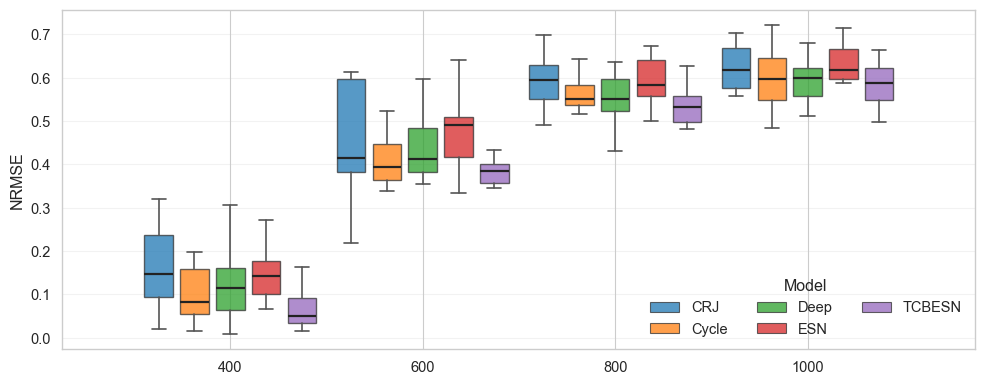

In [126]:
from matplotlib.patches import Patch

def build_nrmse_by_horizon_df(pred_store, DATA, horizons=(400,600,800,1000), exclude_models=None):
    """
    Build NRMSE rows for given horizons. Optionally exclude models by name.
    """
    exclude_models = set(exclude_models or [])
    rows = []
    for (model, init_id, split, rho, seed), preds in pred_store.items():
        if model in exclude_models:
            continue
        test_y = DATA[(init_id, split)]["test_y"]     # ORIGINAL test target
        nrmse = evaluate_nrmse(preds, test_y, list(horizons))
        for h in horizons:
            rows.append({
                "Model": model, "Horizon": h, "NRMSE": nrmse[h],
                "Init": init_id, "Split": split, "Rho": rho, "Seed": seed
            })
    return pd.DataFrame(rows)

# Build DF 
df_nrmse_h = build_nrmse_by_horizon_df(
    pred_store, DATA, horizons=(400,600,800,1000), exclude_models={"SW"}
)

# Order + palette
horizons = sorted(df_nrmse_h["Horizon"].unique())
models   = sorted(df_nrmse_h["Model"].unique())
pal      = sns.color_palette("tab10", n_colors=len(models))
color_of = {m: pal[i] for i, m in enumerate(models)}

# ======= manual grouped boxplot with small separation =======
fig, ax = plt.subplots(figsize=(10, 4))

centers    = np.arange(len(horizons))             # one group per horizon
group_width = 0.90                                 # total width reserved for the whole group
inner_gap   = 0.03                                 # small gap between adjacent boxes
M           = len(models)
box_w       = (group_width - inner_gap*(M-1)) / max(M, 1)  # width of each box
offsets     = np.linspace(-(group_width/2) + box_w/2,
                          +(group_width/2) - box_w/2, M)

# Collect data & positions
all_data, positions, colors = [], [], []
for gi, h in enumerate(horizons):
    center = centers[gi]
    for mi, m in enumerate(models):
        vals = df_nrmse_h.query("Horizon == @h and Model == @m")["NRMSE"].values
        all_data.append(vals)
        positions.append(center + offsets[mi])
        colors.append(color_of[m])

bp = ax.boxplot(
    all_data, positions=positions, widths=box_w*0.95,
    patch_artist=True, showcaps=True, showfliers=False,
    medianprops=dict(color="#222", linewidth=1.6),
    whiskerprops=dict(color="#555", linewidth=1.2),
    capprops=dict(color="#555", linewidth=1.2)
)

# Color boxes
for patch, c in zip(bp["boxes"], colors):
    patch.set_facecolor(c)
    patch.set_edgecolor("#333")
    patch.set_alpha(0.75)
    patch.set_linewidth(1.0)

# X ticks at group centers
ax.set_xticks(centers)
ax.set_xticklabels([str(h) for h in horizons])

# Legend
handles = [Patch(facecolor=color_of[m], edgecolor="#333", label=m, alpha=0.75) for m in models]
ax.legend(handles=handles, title="Model", ncol=3, frameon=False)

#ax.set_title(f"{SYSTEM.title()}: NRMSE distribution by horizon")
ax.set_xlabel("")
ax.set_ylabel("NRMSE")
ax.grid(axis="y", alpha=0.25)
plt.tight_layout()
plt.savefig(FIG_DIR / f"{SYSTEM}_box_nrmse_by_horizon.png", dpi=300, bbox_inches="tight")
plt.show()


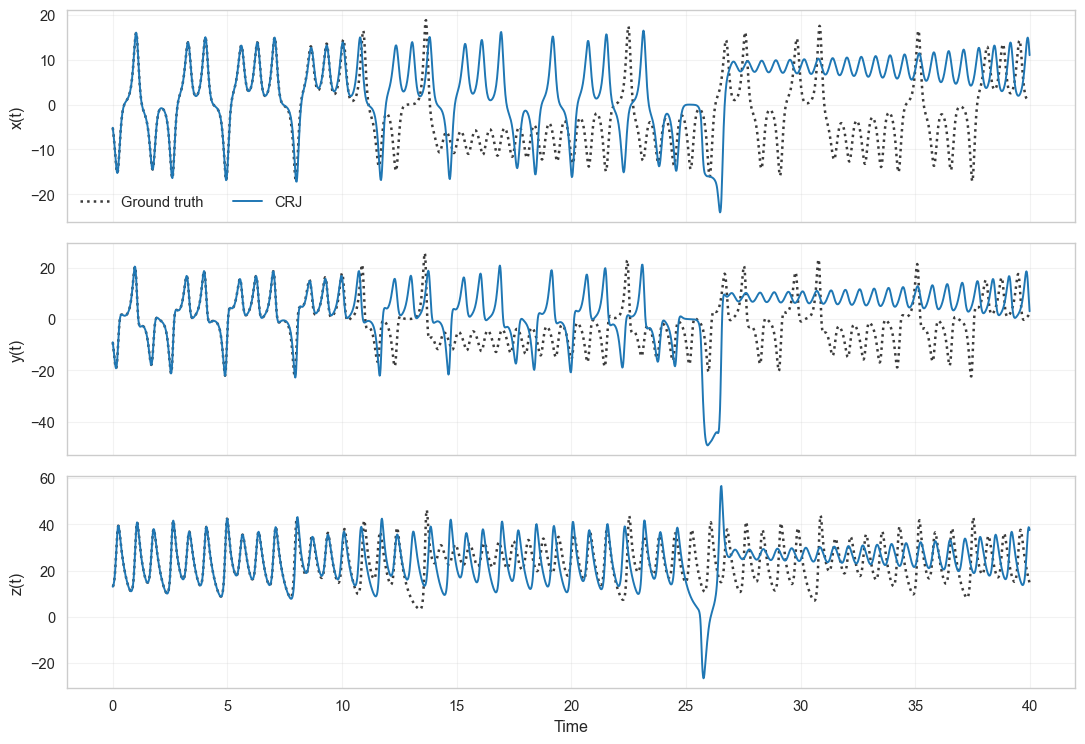

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/lorenz-overlay_CRJ_init1_split0.8_rho0.95_seed1.png


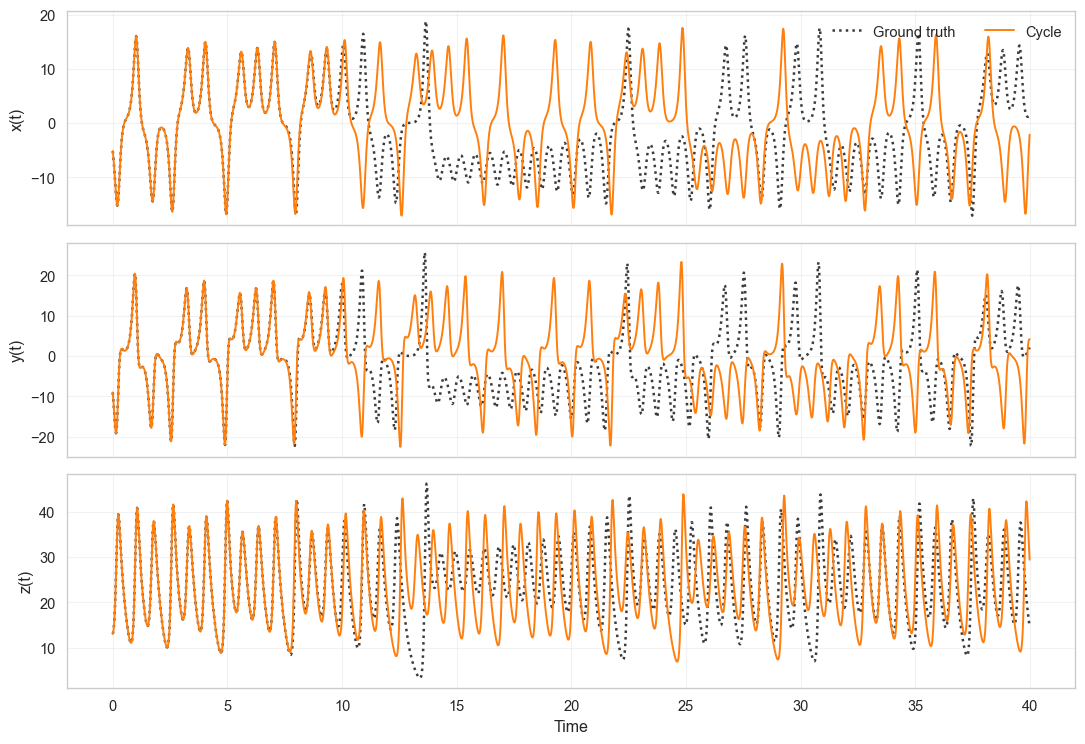

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/lorenz-overlay_Cycle_init1_split0.8_rho0.95_seed1.png


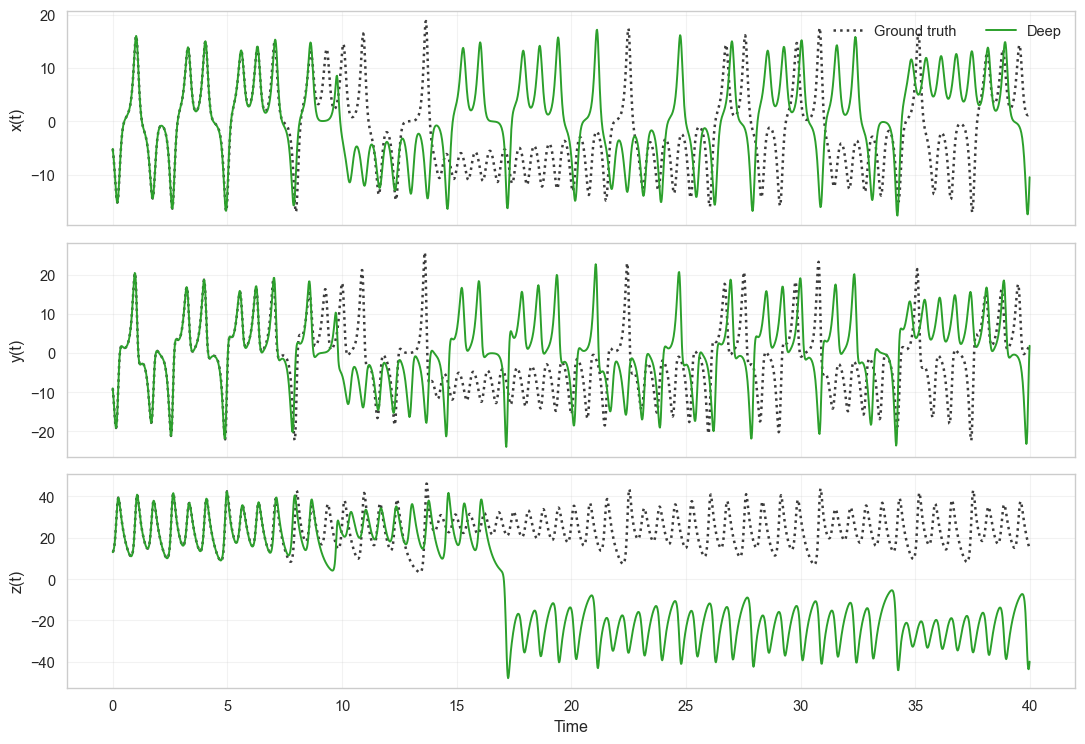

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/lorenz-overlay_Deep_init1_split0.8_rho0.95_seed1.png


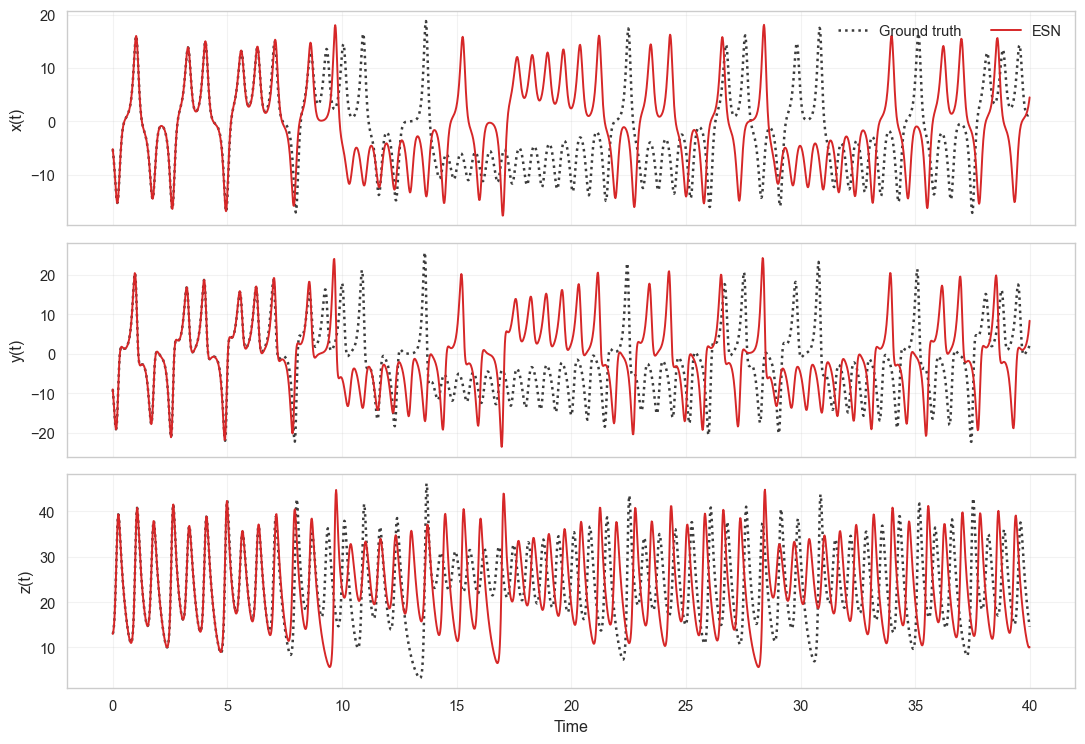

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/lorenz-overlay_ESN_init1_split0.8_rho0.95_seed1.png


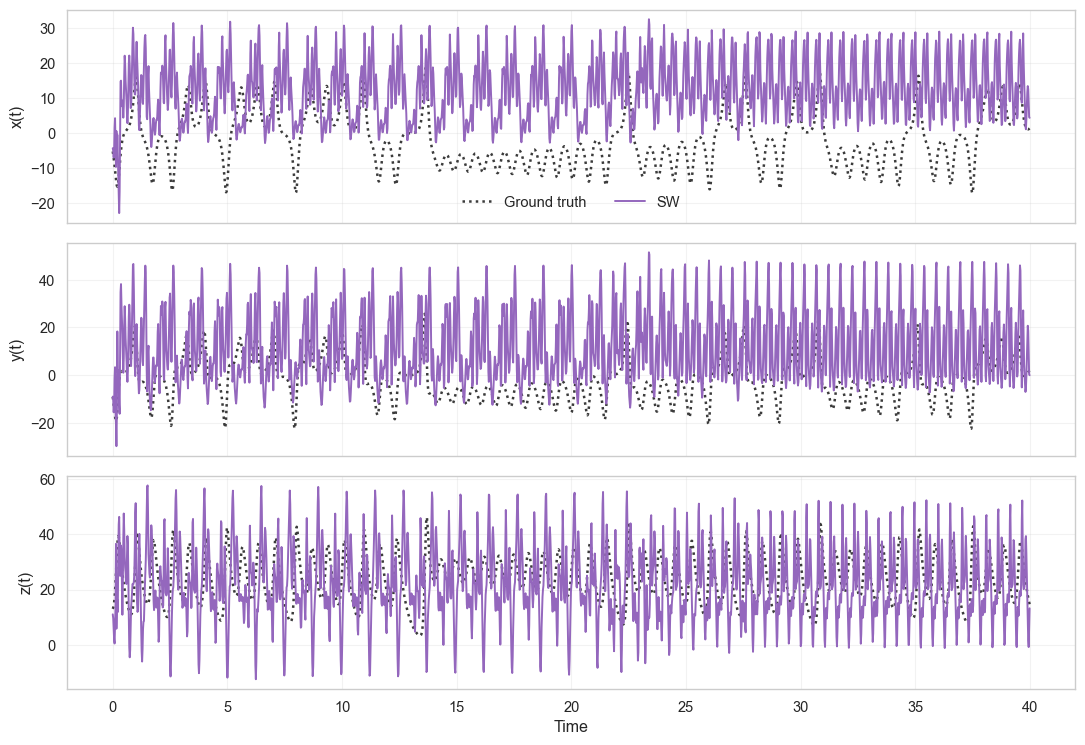

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/lorenz-overlay_SW_init1_split0.8_rho0.95_seed1.png


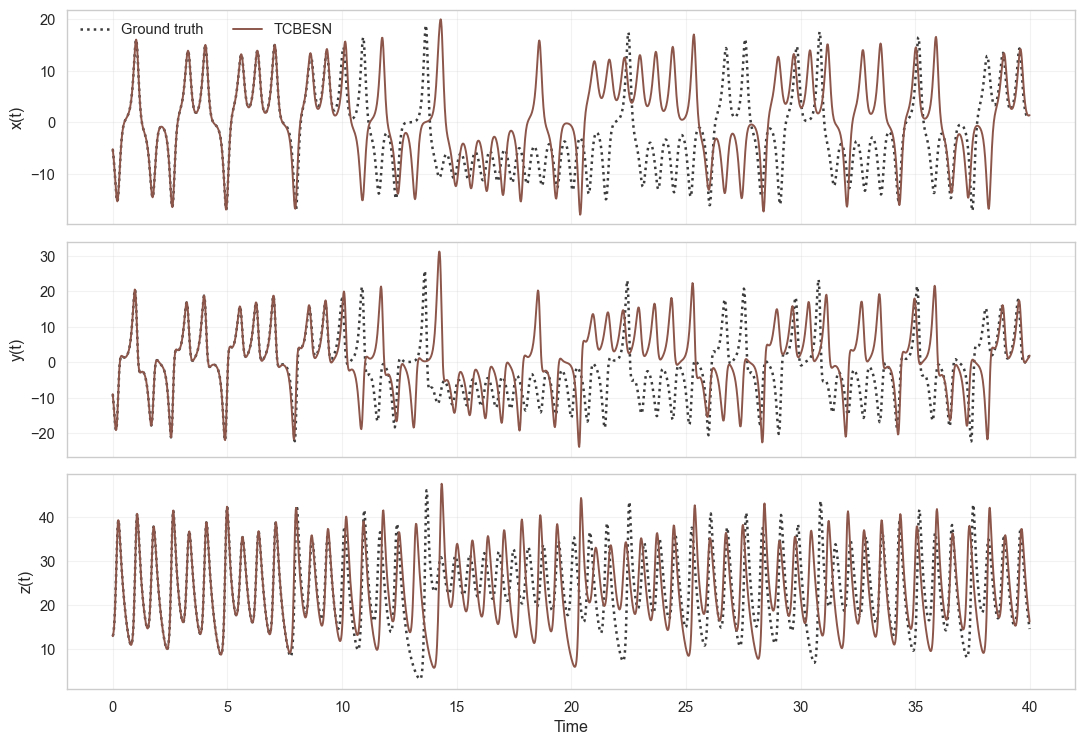

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/lorenz-overlay_TCBESN_init1_split0.8_rho0.95_seed1.png


In [131]:
def plot_overlays_separate(pred_store, DATA, init_id, split, rho, seed,
                           palette=None, truth_color="#444444",
                           max_len=1500, dpi=300):
    """
    One figure per model: 3 stacked panels (x,y,z),
    model trajectory vs ORIGINAL ground truth (dotted).
    Uses DATA[(init_id, split)] to avoid recomputation.
    """
    # --- fetch original test trajectory from cache ---
    key_ds = (init_id, split)
    if key_ds not in DATA:
        raise KeyError(f"No DATA cache for (init_id={init_id}, split={split}).")
    time_test = DATA[key_ds]["time_test"]
    test_y    = DATA[key_ds]["test_y"]

    # truncation for display
    Ttruth = len(time_test)
    if max_len is not None:
        Ttruth   = min(Ttruth, max_len)
        time_plot = time_test[:Ttruth]
        y_plot    = test_y[:Ttruth]
    else:
        time_plot = time_test
        y_plot    = test_y

    # which models actually exist for this exact scenario?
    scenario_models = sorted({
        m for (m, i, s, r, sd) in pred_store.keys()
        if (i, s, r, sd) == (init_id, split, rho, seed)
    })
    if not scenario_models:
        raise ValueError(f"No predictions found for (init={init_id}, split={split}, ρ={rho}, seed={seed}).")

    # palette
    if palette is None:
        # build a stable palette just for the models in this scenario
        base = sns.color_palette("tab10", n_colors=max(10, len(scenario_models)))
        palette = {name: base[idx % len(base)] for idx, name in enumerate(scenario_models)}

    dim_names = ["x(t)", "y(t)", "z(t)"]

    for model in scenario_models:
        preds = pred_store[(model, init_id, split, rho, seed)]
        T = min(Ttruth, preds.shape[0])
        preds = preds[:T]

        fig, axes = plt.subplots(3, 1, figsize=(11, 8), sharex=True)
        for d, ax in enumerate(axes):
            # ground truth (dotted)
            ax.plot(time_plot[:T], y_plot[:T, d],
                    linestyle=":", lw=1.8, color=truth_color, label="Ground truth")
            # model
            ax.plot(time_plot[:T], preds[:, d],
                    lw=1.4, color=palette[model], label=model)
            ax.set_ylabel(dim_names[d])
            ax.grid(alpha=0.25)
            if d == 0:
                ax.legend(frameon=False, ncol=2)

        axes[-1].set_xlabel("Time")
        #plt.suptitle(f"{SYSTEM}{model} vs Ground Truth  |  init={init_id}, split={split}, ρ={rho}, seed={seed}")
        plt.tight_layout(rect=[0, 0, 1, 0.95])

        out = FIG_DIR / f"{SYSTEM}-overlay_{model}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
        plt.savefig(out, dpi=dpi, bbox_inches="tight")
        plt.show()
        print(f"Saved: {out}")

plot_overlays_separate(
    pred_store, DATA,
    init_id=1, split=0.8, rho=0.95, seed=1,
    truth_color="#3b3b3b", max_len=2000, dpi=300
)


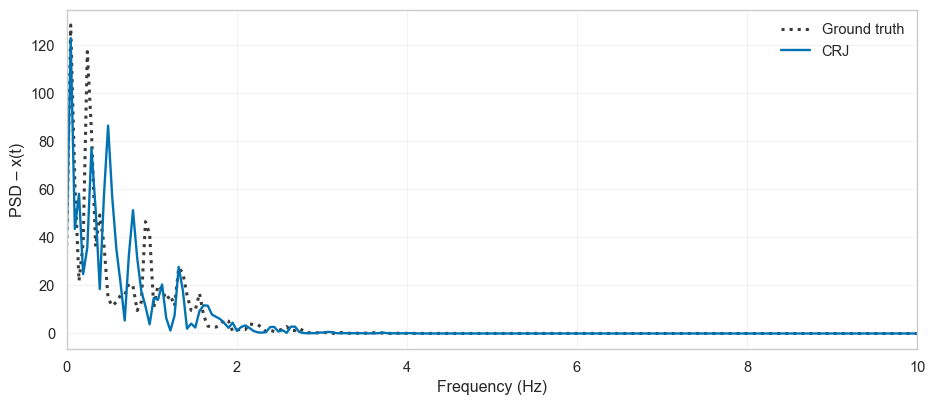

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/psd_lorenz_CRJ_dim-x_init1_split0.8_rho0.95_seed1.png


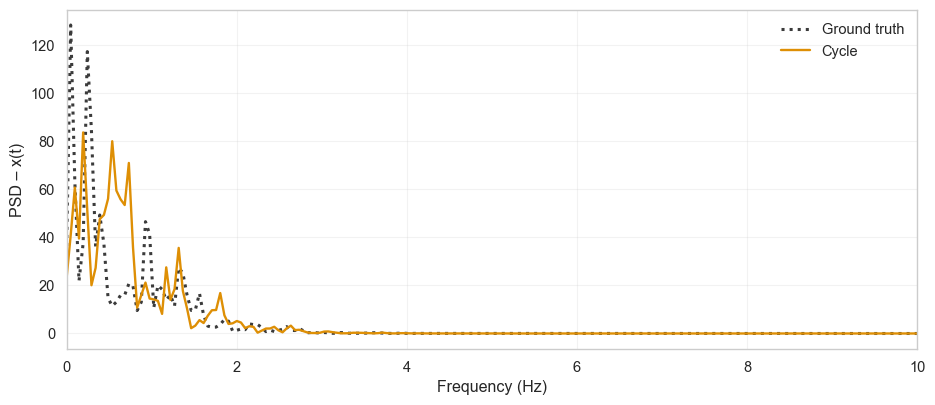

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/psd_lorenz_Cycle_dim-x_init1_split0.8_rho0.95_seed1.png


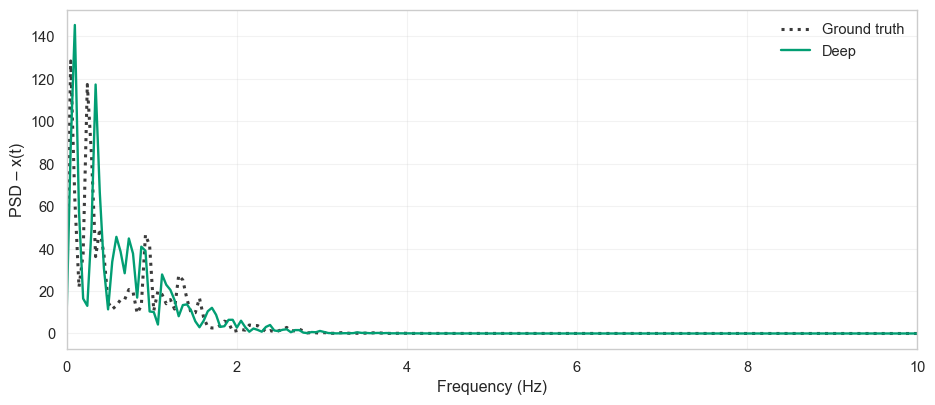

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/psd_lorenz_Deep_dim-x_init1_split0.8_rho0.95_seed1.png


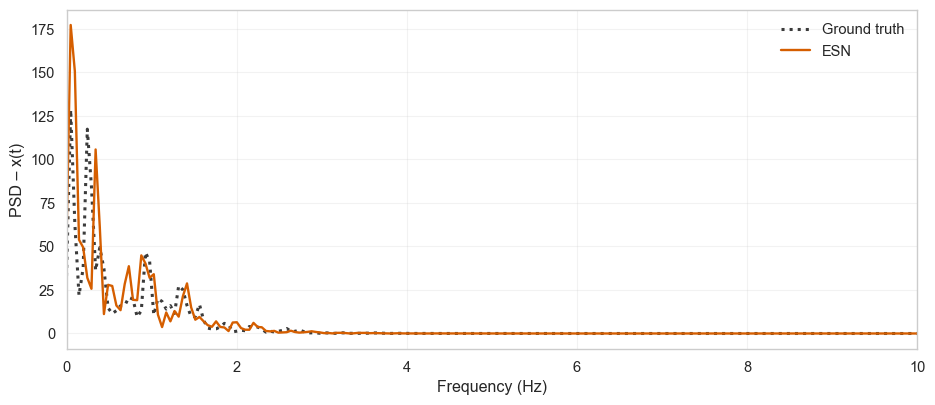

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/psd_lorenz_ESN_dim-x_init1_split0.8_rho0.95_seed1.png


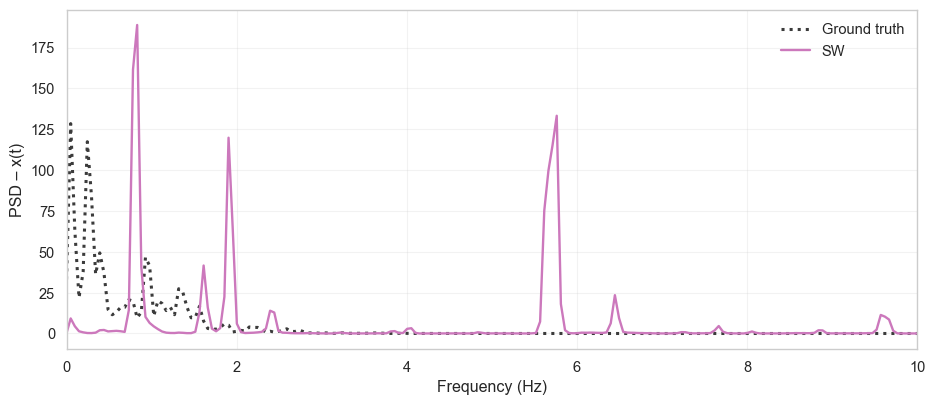

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/psd_lorenz_SW_dim-x_init1_split0.8_rho0.95_seed1.png


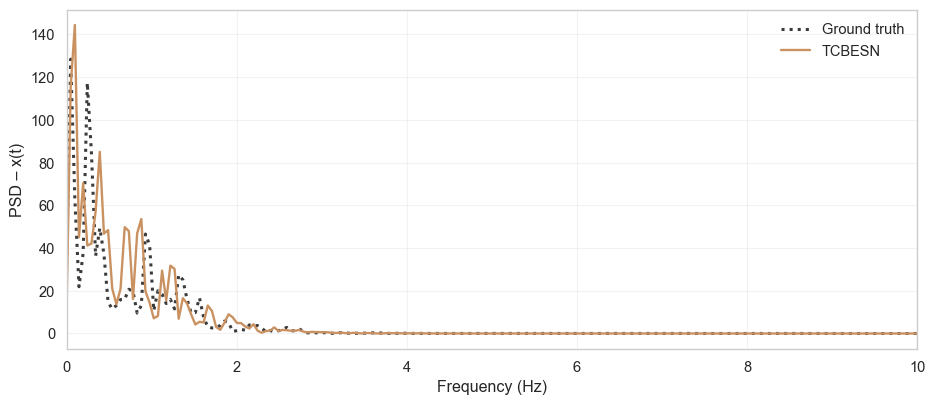

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/psd_lorenz_TCBESN_dim-x_init1_split0.8_rho0.95_seed1.png


In [142]:
# --- deps ---

DIM_LABELS = ["x(t)", "y(t)", "z(t)"]
TRUTH_COLOR = "#3b3b3b"   # dotted charcoal for truth

def make_model_palette(pred_store, palette_name="colorblind"):
    models = sorted({k[0] for k in pred_store.keys()})
    pal = sns.color_palette(palette_name, n_colors=len(models))
    return {m: pal[i] for i, m in enumerate(models)}

def make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name="colorblind"):
    models = sorted({
        m for (m, i, s, r, sd) in pred_store.keys()
        if (i, s, r, sd) == (init_id, split, rho, seed)
    })
    pal = sns.color_palette(palette_name, n_colors=len(models))
    return {m: pal[i] for i, m in enumerate(models)}

PALETTE = make_model_palette(pred_store)  # global fallback

# -----------------------------------------------------------------------------
# C) PSD — SEPARATE FIGURES for ALL MODELS (choose one component x/y/z)
# -----------------------------------------------------------------------------
def plot_psd_all_models_separate(pred_store, DATA, init_id, split, rho, seed,
                                 dim=0, max_len=None, nperseg=1024, noverlap=None,
                                 window="hann", detrend="constant", scaling="density",
                                 palette_name="colorblind",
                                 truth_color=TRUTH_COLOR, dpi=300):
    """
    For the given scenario (init_id, split, rho, seed), make one PSD figure per model
    on a single chosen component dim ∈ {0,1,2} (x/y/z), vs the ORIGINAL ground truth.
    """
    if dim not in (0, 1, 2):
        raise ValueError("dim must be 0 (x), 1 (y), or 2 (z).")

    # --- fetch truth & fs from cache ---
    ds_key = (init_id, split)
    if ds_key not in DATA:
        raise KeyError(f"No DATA cache for (init_id={init_id}, split={split}).")

    t       = DATA[ds_key]["time_test"]
    y_true  = DATA[ds_key]["test_y"]
    fs      = 1.0 / np.mean(np.diff(t))
    T       = len(t) if max_len is None else min(len(t), max_len)
    y_true  = y_true[:T]

    # models available for this exact scenario
    scenario_models = sorted({
        m for (m, i, s, r, sd) in pred_store.keys()
        if (i, s, r, sd) == (init_id, split, rho, seed)
    })
    if not scenario_models:
        raise ValueError(f"No predictions for (init={init_id}, split={split}, ρ={rho}, seed={seed}).")

    palette = make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name)

    # compute truth PSD once for the chosen component
    nperseg_eff = max(16, min(nperseg, T))
    f_t, P_t = signal.welch(y_true[:, dim], fs=fs, window=window,
                            nperseg=nperseg_eff, noverlap=noverlap,
                            detrend=detrend, scaling=scaling, return_onesided=True)

    comp_name = ["x", "y", "z"][dim]
    ylabel = f"PSD – {DIM_LABELS[dim]}"

    # --- one figure per model ---
    for m in scenario_models:
        preds = pred_store[(m, init_id, split, rho, seed)][:T]
        f_p, P_p = signal.welch(preds[:, dim], fs=fs, window=window,
                                nperseg=nperseg_eff, noverlap=noverlap,
                                detrend=detrend, scaling=scaling, return_onesided=True)

        plt.figure(figsize=(9.5, 4.2))
        # truth (dotted) + model
        plt.plot(f_t, P_t, linestyle=":", lw=2.2, color=truth_color, label="Ground truth")
        plt.plot(f_p, P_p, lw=1.7, color=palette.get(m, "C0"), label=m)

        plt.xlabel("Frequency (Hz)")
        plt.ylabel(ylabel)
        plt.xlim(0, 10)   # <-- limit frequency axis to 10 Hz
        plt.grid(alpha=0.25)
        plt.legend(frameon=False)
        #plt.title(f"PSD — {m} vs Truth | {DIM_LABELS[dim]}  •  init={init_id}, split={split}, ρ={rho}, seed={seed}")
        plt.tight_layout()

        safe_model = m.replace(" ", "").replace("/", "_")
        out = FIG_DIR / f"psd_{SYSTEM}_{safe_model}_dim-{comp_name}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
        plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
        print(f"Saved: {out}")

# All models, separate figures, PSD for x only
plot_psd_all_models_separate(pred_store, DATA, init_id=1, split=0.8, rho=0.95, seed=1, dim=0)

# For y (dim=1)
#plot_psd_all_models_separate(pred_store, DATA, init_id=1, split=0.8, rho=0.95, seed=1, dim=1)

# For z (dim=2), longer segment and larger nperseg
#plot_psd_all_models_separate(pred_store, DATA, init_id=1, split=0.8, rho=0.95, seed=1, dim=2, max_len=6000, nperseg=2048)



In [58]:
# =========================================================
# Time-series overlays with VPT (no truth recompute)
# =========================================================

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

TRUTH_COLOR = "#3b3b3b"  # dotted charcoal for ground truth

# --- System-specific λ_max defaults (fallback if auto fails) ---
LAMBDA_MODE = "auto"   # "auto" or "fixed"
LAMBDA_MAP  = {
    "lorenz":    0.90,
    "rossler":   0.07,     # typical for (a=0.2,b=0.2,c=5.7) with dt≈0.02
    "chen-ueta": 2.038,
}

def _safe_name(s: str) -> str:
    return s.replace(" ", "").replace("/", "_")

def make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name="colorblind"):
    """Palette only for models that exist for this scenario."""
    models = sorted({
        m for (m, i, s, r, sd) in pred_store.keys()
        if (i, s, r, sd) == (init_id, split, rho, seed)
    })
    pal = sns.color_palette(palette_name, n_colors=len(models))
    return {m: pal[i] for i, m in enumerate(models)}

# ------------------------------
# Rough λ_max (Rosenstein-style)
# ------------------------------
def estimate_lambda_max_rosenstein(y_true: np.ndarray, t: np.ndarray,
                                  theiler: int = 30, kmax: int = 60,
                                  n_samples: int = 500) -> float:
    """
    Very lightweight largest Lyapunov exponent estimate from a single trajectory.
    y_true: (T, d) trajectory; t: time vector. Returns λ_max in 1/seconds.
    """
    T, d = y_true.shape
    if T < theiler + kmax + 2:
        raise ValueError("Time series too short for λ_max estimation")

    # nearest neighbors with exclusion window
    nbrs = NearestNeighbors(n_neighbors=10, algorithm="auto").fit(y_true)
    # sample candidate anchors away from ends
    rng = np.random.default_rng(0)
    anchors = rng.integers(low=theiler+1, high=T-kmax-1, size=min(n_samples, T - (theiler+kmax+2)))

    dt = float(np.mean(np.diff(t)))
    logs = []

    for i in anchors:
        # find a neighbor not within Theiler window
        dists, idxs = nbrs.kneighbors(y_true[i:i+1], return_distance=True)
        j = None
        for cand in idxs[0]:
            if abs(cand - i) > theiler:
                j = cand
                break
        if j is None:
            continue

        # separation growth
        seq = []
        for k in range(1, kmax+1):
            if i+k >= T or j+k >= T:
                break
            d_k = np.linalg.norm(y_true[i+k] - y_true[j+k])
            if d_k <= 0:
                continue
            seq.append(np.log(d_k))
        if len(seq) >= 8:
            logs.append(seq)

    if not logs:
        raise RuntimeError("Failed to collect separations for λ_max estimation")

    # pad to same length (use min length across collected sequences)
    L = min(len(s) for s in logs)
    M = np.stack([s[:L] for s in logs], axis=0)  # (N, L)
    y = M.mean(axis=0)                           # ⟨log d(k)⟩
    x = np.arange(1, L+1) * dt                   # time in seconds

    # fit only early linear region (first 1/3 or up to ~0.5s)
    cutoff = max(10, min(L//3, int(0.5/dt)))
    if cutoff < 6: cutoff = min(L, 10)
    coef = np.polyfit(x[:cutoff], y[:cutoff], 1)  # slope ≈ λ_max
    lam = float(coef[0])
    return max(lam, 1e-6)

def get_lambda_max(system: str, y_true: np.ndarray, t: np.ndarray) -> float:
    """Select λ_max based on LAMBDA_MODE & map; auto falls back to map."""
    sys_key = (system or "lorenz").lower()
    if LAMBDA_MODE.lower() == "fixed":
        return float(LAMBDA_MAP.get(sys_key, 0.9))
    # auto
    try:
        return estimate_lambda_max_rosenstein(y_true, t)
    except Exception:
        return float(LAMBDA_MAP.get(sys_key, 0.9))

# ---------------------------------------------------------
# Main plotter (uses DATA cache for ORIGINAL truth only)
# ---------------------------------------------------------
def plot_timeseries_with_vpt_per_model(pred_store, DATA, model,
                                       init_id, split, rho, seed,
                                       system="lorenz",
                                       threshold=0.4,
                                       lambda_mode=None,   # override global if not None
                                       max_len=None, dpi=300,
                                       palette_name="colorblind",
                                       truth_color=TRUTH_COLOR):
    """
    One figure per (model, scenario): 3 stacked panels (x,y,z).
    Uses DATA[(init_id, split)] to fetch ORIGINAL test trajectory.
    Draws VPT vertical line based on (threshold, λ_max).
    """
    ds_key = (init_id, split)
    if ds_key not in DATA:
        raise KeyError(f"No DATA cache for (init={init_id}, split={split}).")

    t        = DATA[ds_key]["time_test"]
    y_true   = DATA[ds_key]["test_y"]
    key      = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No predictions for {key}")
    y_pred   = pred_store[key]

    # Align lengths
    T = min(len(t), len(y_true), len(y_pred))
    if max_len is not None:
        T = min(T, max_len)
    t = t[:T]; y_true = y_true[:T]; y_pred = y_pred[:T]

    # λ_max selection
    mode = (lambda_mode or LAMBDA_MODE).lower()
    lam  = get_lambda_max(system, y_true, t) if mode == "auto" else float(LAMBDA_MAP.get(system.lower(), 0.9))

    # Compute VPT
    T_VPT, T_lambda, ratio = compute_valid_prediction_time(
        y_true, y_pred, t, threshold=threshold, lambda_max=lam
    )
    vline_x = np.clip(T_VPT, t[0], t[-1])

    # palette per scenario so color is consistent across figures
    scenario_palette = make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name)
    color_model = scenario_palette.get(model, "C0")

    # Plot
    dim_names = ["x(t)", "y(t)", "z(t)"]
    fig, axes = plt.subplots(3, 1, figsize=(11, 8), sharex=True)
    for d, ax in enumerate(axes):
        ax.plot(t, y_true[:, d], linestyle=":", color=truth_color, lw=1.9, label="Ground truth")
        ax.plot(t, y_pred[:, d], color=color_model, lw=1.5, label=model)
        ax.axvline(vline_x, color="crimson", ls="--", lw=1.2,
                   label=(f"VPT={T_VPT:.2f}s" if d == 0 else None))
        ax.set_ylabel(dim_names[d]); ax.grid(alpha=0.25)
        if d == 0:
            ax.legend(ncol=3, frameon=False)
    axes[-1].set_xlabel("Time (s)")
    plt.suptitle(f"{model}: Trajectory vs Truth  |  init={init_id}, split={split}, ρ={rho}, seed={seed}  •  "
                 f"λ_max=({mode}) {lam:.3g}, threshold={threshold}")
    plt.tight_layout(rect=[0,0,1,0.95])

    out = FIG_DIR / f"{system}_ts_vpt_{_safe_name(model)}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
    print(f"Saved: {out}")

'''plot_timeseries_with_vpt_per_model(
    pred_store, DATA,
    model="ESN",
    init_id=1, split=0.8, rho=0.95, seed=1,
    system=SYSTEM,          # e.g., "lorenz" | "rossler" | "chen-ueta"
    threshold=0.4,
    lambda_mode="auto",     # or "fixed"
    max_len=2000, dpi=300
)
'''

'plot_timeseries_with_vpt_per_model(\n    pred_store, DATA,\n    model="ESN",\n    init_id=1, split=0.8, rho=0.95, seed=1,\n    system=SYSTEM,          # e.g., "lorenz" | "rossler" | "chen-ueta"\n    threshold=0.4,\n    lambda_mode="auto",     # or "fixed"\n    max_len=2000, dpi=300\n)\n'

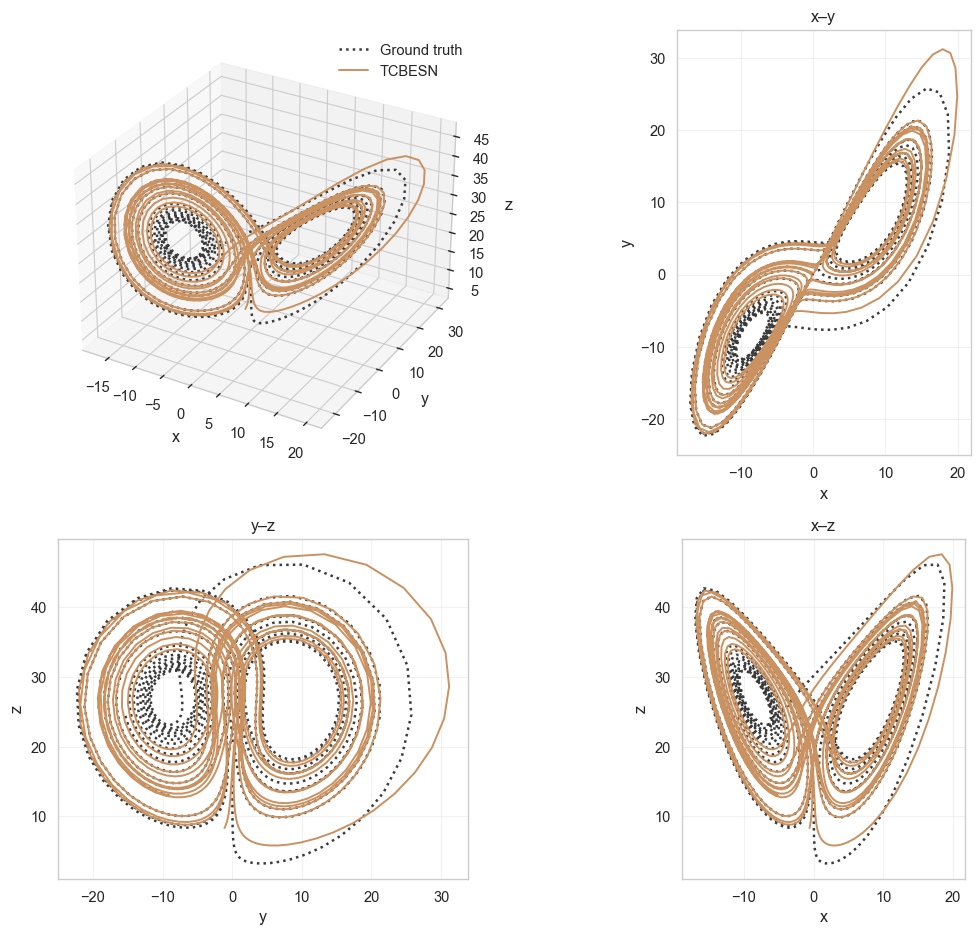

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/phase_TCBESN_init1_split0.8_rho0.95_seed1.png


In [147]:
# ============================================
# Phase-space overlay (per model) — no re-gen
# ============================================

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

TRUTH_COLOR = "#3b3b3b"  # dotted charcoal for ground truth


def _safe_name(s: str) -> str:
    return s.replace(" ", "").replace("/", "_")

def make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name="colorblind"):
    """Palette only for models that exist for this scenario."""
    models = sorted({
        m for (m, i, s, r, sd) in pred_store.keys()
        if (i, s, r, sd) == (init_id, split, rho, seed)
    })
    pal = sns.color_palette(palette_name, n_colors=len(models))
    return {m: pal[i] for i, m in enumerate(models)}

def plot_phase_space_overlay_per_model(pred_store, DATA, model,
                                       init_id, split, rho, seed,
                                       max_len=4000, dpi=300,
                                       truth_color=TRUTH_COLOR,
                                       palette_name="colorblind"):
    """
    One figure per model:
      • 3D Lorenz/Rössler/Chen-Ueta trajectory overlay (truth dotted)
      • 2D projections (x–y, y–z, x–z)
    Uses ORIGINAL test trajectory from DATA cache: DATA[(init_id, split)].
    """
    ds_key = (init_id, split)
    if ds_key not in DATA:
        raise KeyError(f"No DATA cache for (init={init_id}, split={split}).")

    # Truth & preds (no recomputation)
    y_true = DATA[ds_key]["test_y"]
    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No predictions for {key}")
    y_pred = pred_store[key]

    # Align lengths
    T = min(len(y_true), len(y_pred), max_len if max_len else len(y_true))
    y_true = y_true[:T]; y_pred = y_pred[:T]

    # Colors
    pal = make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name)
    color_model = pal.get(model, "C0")

    # Layout: 2x2 (3D top-left, then XY, YZ, XZ projections)
    fig = plt.figure(figsize=(12, 10))
    gs = GridSpec(2, 2, figure=fig, height_ratios=[2.0, 1.6])

    # 3D
    ax3d = fig.add_subplot(gs[0, 0], projection='3d')
    ax3d.plot(y_true[:,0], y_true[:,1], y_true[:,2], ls=":", lw=1.8, color=truth_color, label="Ground truth")
    ax3d.plot(y_pred[:,0], y_pred[:,1], y_pred[:,2], lw=1.4, color=color_model, label=model)
    ax3d.set_xlabel("x"); ax3d.set_ylabel("y"); ax3d.set_zlabel("z")
    ax3d.legend(frameon=False)

    # XY
    ax_xy = fig.add_subplot(gs[0, 1])
    ax_xy.plot(y_true[:,0], y_true[:,1], ls=":", lw=1.8, color=truth_color)
    ax_xy.plot(y_pred[:,0], y_pred[:,1], lw=1.4, color=color_model)
    ax_xy.set_xlabel("x"); ax_xy.set_ylabel("y"); ax_xy.set_title("x–y")
    ax_xy.set_aspect("equal", adjustable="box"); ax_xy.grid(alpha=0.25)

    # YZ
    ax_yz = fig.add_subplot(gs[1, 0])
    ax_yz.plot(y_true[:,1], y_true[:,2], ls=":", lw=1.8, color=truth_color)
    ax_yz.plot(y_pred[:,1], y_pred[:,2], lw=1.4, color=color_model)
    ax_yz.set_xlabel("y"); ax_yz.set_ylabel("z"); ax_yz.set_title("y–z")
    ax_yz.set_aspect("equal", adjustable="box"); ax_yz.grid(alpha=0.25)

    # XZ
    ax_xz = fig.add_subplot(gs[1, 1])
    ax_xz.plot(y_true[:,0], y_true[:,2], ls=":", lw=1.8, color=truth_color)
    ax_xz.plot(y_pred[:,0], y_pred[:,2], lw=1.4, color=color_model)
    ax_xz.set_xlabel("x"); ax_xz.set_ylabel("z"); ax_xz.set_title("x–z")
    ax_xz.set_aspect("equal", adjustable="box"); ax_xz.grid(alpha=0.25)

    #plt.suptitle(f"{model}: Phase-space overlay  |  init={init_id}, split={split}, ρ={rho}, seed={seed}")
    plt.tight_layout(rect=[0,0,1,0.95])
    out = FIG_DIR / f"phase_{_safe_name(model)}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
    print(f"Saved: {out}")

plot_phase_space_overlay_per_model(
    pred_store, DATA,
    model="HLESN", init_id=1, split=0.8, rho=0.95, seed=1,
    max_len=1000, dpi=300
)

In [60]:
# ============================================
# Poincaré section (per model) — no re-gen of truth
# ============================================

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

TRUTH_COLOR = "#3b3b3b"  # dotted charcoal for ground truth


def _safe_name(s: str) -> str:
    return s.replace(" ", "").replace("/", "_")

def make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name="colorblind"):
    """Palette only for models that exist for this scenario."""
    models = sorted({
        m for (m, i, s, r, sd) in pred_store.keys()
        if (i, s, r, sd) == (init_id, split, rho, seed)
    })
    pal = sns.color_palette(palette_name, n_colors=len(models))
    return {m: pal[i] for i, m in enumerate(models)}

def _plane_crossings_xyz(x, y, z, x0, direction="up"):
    """
    Return intersection points (y*, z*) where x(t) crosses plane x=x0.
    direction: "up" (below->above), "down" (above->below), or "both".
    """
    y_pts, z_pts = [], []
    for i in range(1, len(x)):
        x_prev, x_curr = x[i-1], x[i]
        # orientation filter
        if direction == "up" and not (x_prev < x0 <= x_curr):
            continue
        if direction == "down" and not (x_prev > x0 >= x_curr):
            continue
        if direction == "both" and not ((x_prev - x0) * (x_curr - x0) <= 0):
            continue
        denom = x_curr - x_prev
        if np.isclose(denom, 0.0):
            continue
        alpha = (x0 - x_prev) / denom  # linear interpolation weight
        y_cross = y[i-1] + alpha * (y[i] - y[i-1])
        z_cross = z[i-1] + alpha * (z[i] - z[i-1])
        y_pts.append(y_cross); z_pts.append(z_cross)
    return np.array(y_pts), np.array(z_pts)

def plot_poincaré_section_per_model(pred_store, DATA, model,
                                    init_id, split, rho, seed,
                                    plane_axis="x", plane_value=None,
                                    direction="up",
                                    max_len=4000, dpi=300,
                                    truth_color=TRUTH_COLOR,
                                    palette_name="colorblind"):
    """
    Poincaré section for one model vs truth using ORIGINAL test trajectory from DATA.
    plane_axis: {"x","y","z"}; section is axis = plane_value (defaults to mean of truth).
    direction : {"up","down","both"} for crossing orientation.
    """
    ds_key = (init_id, split)
    if ds_key not in DATA:
        raise KeyError(f"No DATA cache for (init={init_id}, split={split}).")

    # Truth & preds
    y_true = DATA[ds_key]["test_y"]
    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No predictions for {key}")
    y_pred = pred_store[key]

    # Align lengths
    T = min(len(y_true), len(y_pred), max_len if max_len else len(y_true))
    y_true = y_true[:T]; y_pred = y_pred[:T]

    # Choose section axis & default value
    ax_map = {"x": 0, "y": 1, "z": 2}
    if plane_axis not in ax_map:
        raise ValueError("plane_axis must be one of {'x','y','z'}")
    a = ax_map[plane_axis]

    if plane_value is None:
        plane_value = float(np.mean(y_true[:, a]))

    # Rotate coordinates so section is always along the first component
    # (re-use the existing x-plane crossing routine)
    def _reorder(arr):
        if a == 0:  # x-plane: (x,y,z)
            return arr[:,0], arr[:,1], arr[:,2]
        if a == 1:  # y-plane: (y,z,x) -> crossings return (z*, x*)
            return arr[:,1], arr[:,2], arr[:,0]
        else:       # z-plane: (z,x,y) -> crossings return (x*, y*)
            return arr[:,2], arr[:,0], arr[:,1]

    # Crossings
    xt, yt, zt = _reorder(y_true)
    xp, yp, zp = _reorder(y_pred)

    YT, ZT = _plane_crossings_xyz(xt, yt, zt, plane_value, direction=direction)
    YP, ZP = _plane_crossings_xyz(xp, yp, zp, plane_value, direction=direction)

    # Pretty axis labels after reordering
    pair_labels = {0: ("y", "z"), 1: ("z", "x"), 2: ("x", "y")}
    lab_y, lab_z = pair_labels[a]

    # Colors
    pal = make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name)
    color_model = pal.get(model, "C0")

    # Plot
    plt.figure(figsize=(7.2, 6.2))
    if len(YT) == 0 and len(YP) == 0:
        plt.text(0.5, 0.5,
                 f"No crossings found at {plane_axis}={plane_value:.2f} ({direction})",
                 ha="center", va="center")
        plt.axis("off")
    else:
        if len(YT) > 0:
            plt.scatter(YT, ZT, s=20, c=truth_color, alpha=0.75, marker="o", label="Ground truth")
        if len(YP) > 0:
            plt.scatter(YP, ZP, s=22, c=color_model, alpha=0.75, marker="x", label=model)
        plt.xlabel(f"{lab_y} at crossing"); plt.ylabel(f"{lab_z} at crossing")
        plt.title(f"Poincaré: {plane_axis}={plane_value:.2f} ({direction})\n"
                  f"{model}  |  init={init_id}, split={split}, ρ={rho}, seed={seed}")
        plt.legend(frameon=False)
        plt.grid(alpha=0.25)
        plt.gca().set_aspect("equal", adjustable="box")

    plt.tight_layout()
    out = FIG_DIR / f"poincare_{_safe_name(model)}_{plane_axis}{plane_value:.2f}_{direction}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
    print(f"Saved: {out}")

# Default: section on mean(x_true), upward crossings
'''plot_poincaré_section_per_model(
    pred_store, DATA, "HLESN",
    init_id=1, split=0.8, rho=0.95, seed=1,
    plane_axis="x", direction="up"
)'''

# Specific plane & both directions on y=10.0
'''plot_poincaré_section_per_model(
    pred_store, DATA, "ESN",
    init_id=1, split=0.8, rho=0.95, seed=1,
    plane_axis="y", plane_value=10.0, direction="both"
)
'''

'plot_poincaré_section_per_model(\n    pred_store, DATA, "ESN",\n    init_id=1, split=0.8, rho=0.95, seed=1,\n    plane_axis="y", plane_value=10.0, direction="both"\n)\n'

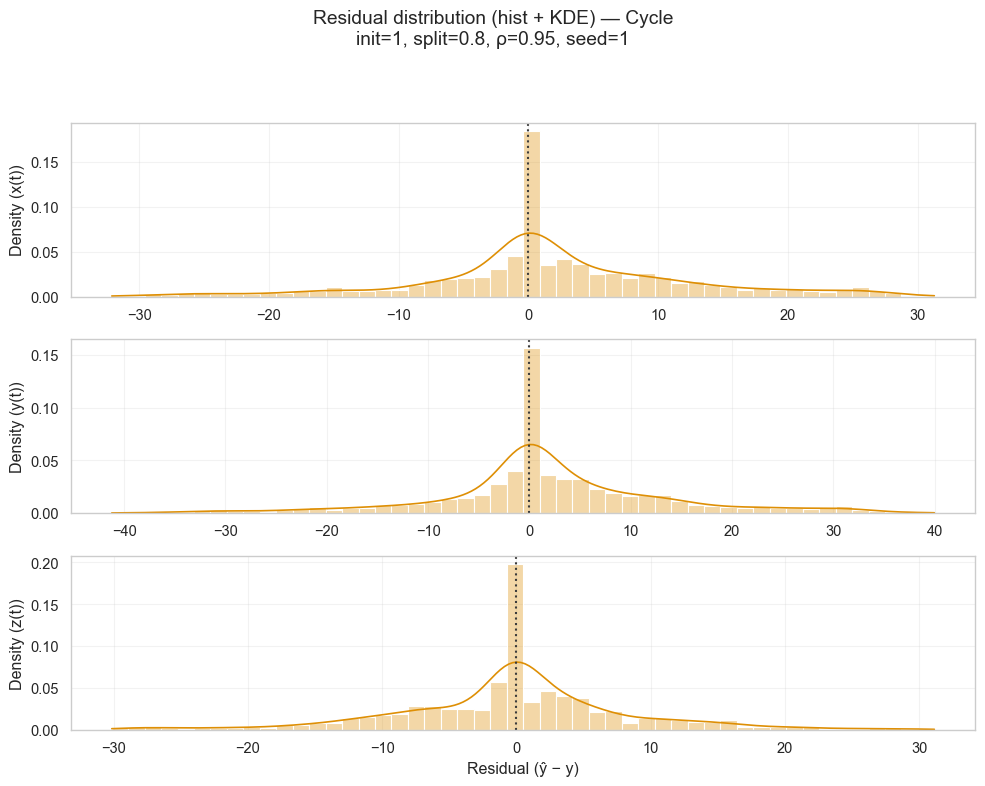

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/resid_hist_kde_Cycle_init1_split0.8_rho0.95_seed1.png


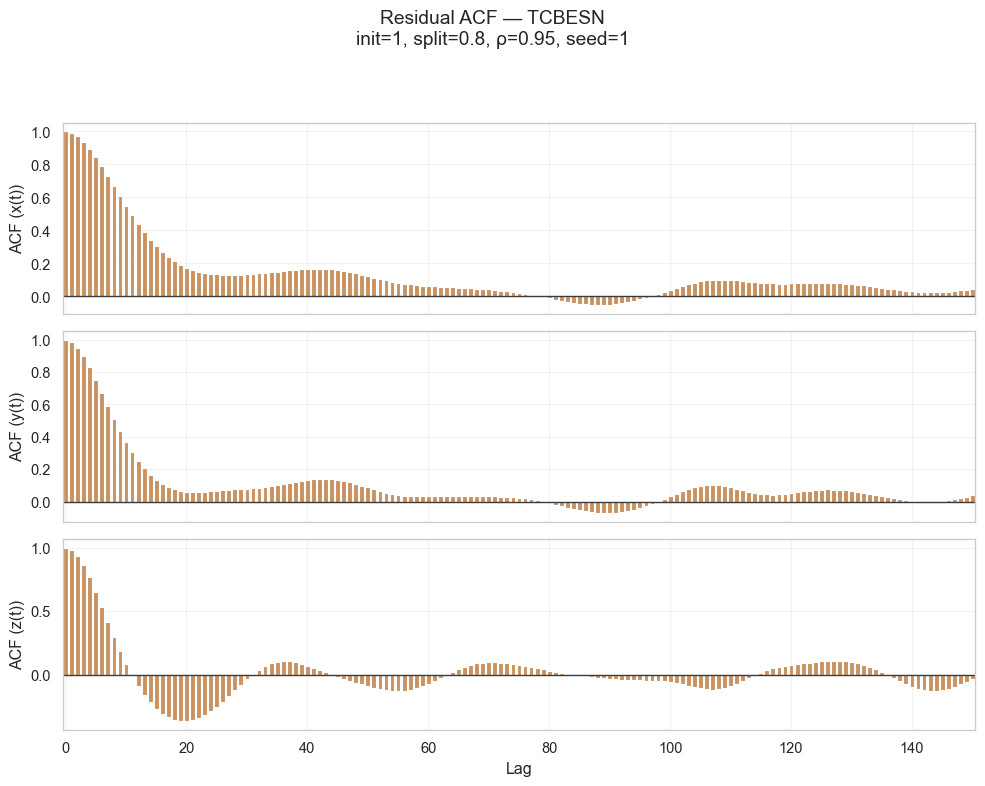

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/resid_acf_TCBESN_init1_split0.8_rho0.95_seed1.png


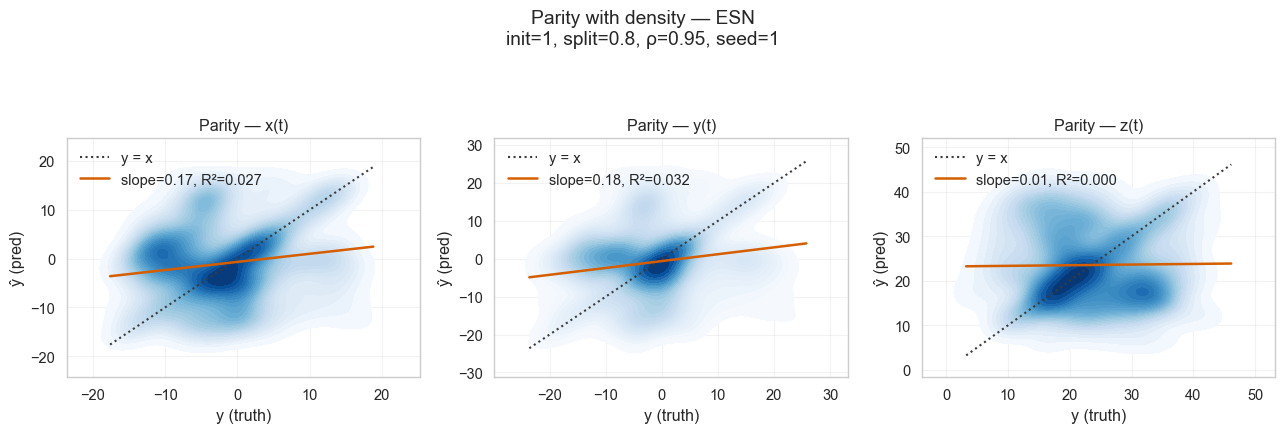

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/parity_density_ESN_init1_split0.8_rho0.95_seed1.png


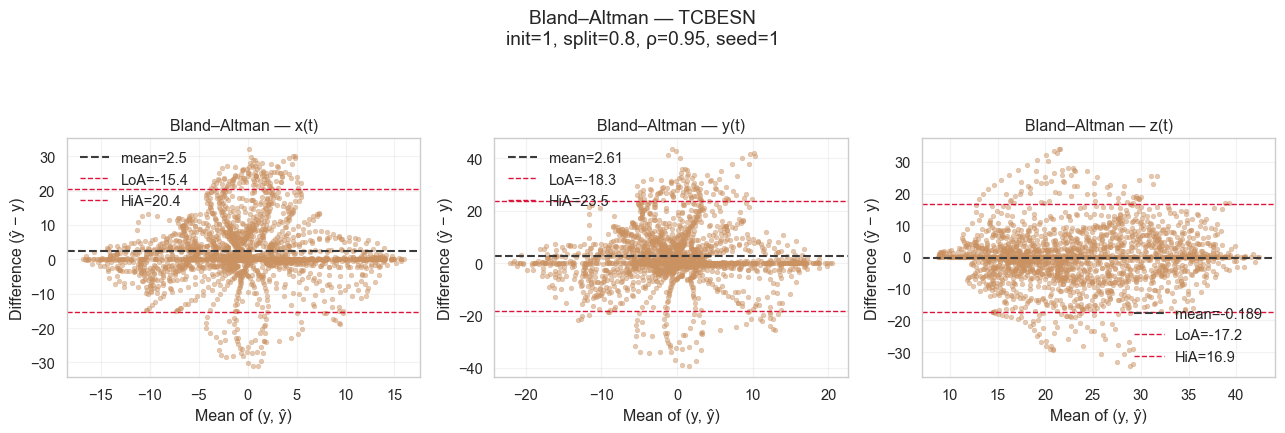

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/bland_altman_TCBESN_init1_split0.8_rho0.95_seed1.png


In [61]:
# ============================ setup & helpers ============================

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
TRUTH_COLOR = "#3b3b3b"



def _safe_name(s: str) -> str:
    return s.replace(" ", "").replace("/", "_")

def make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name="colorblind"):
    """Palette only for models present in this exact scenario."""
    models = sorted({
        m for (m, i, s, r, sd) in pred_store.keys()
        if (i, s, r, sd) == (init_id, split, rho, seed)
    })
    pal = sns.color_palette(palette_name, n_colors=len(models))
    return {m: pal[i] for i, m in enumerate(models)}

# Simple (biased) ACF up to nlags
def _acf(x, nlags=200):
    x = np.asarray(x, float)
    x = x - np.mean(x)
    n = len(x)
    if n == 0:
        return np.array([np.nan]*(nlags+1))
    denom = np.dot(x, x)
    if denom == 0:
        return np.array([0.0] + [0.0]*nlags)
    ac = [1.0]
    for k in range(1, nlags+1):
        num = np.dot(x[k:], x[:n-k])
        ac.append(num / denom)
    return np.array(ac)

# ============================ plots (DATA-driven) ============================

def plot_residual_hist_kde_per_model(pred_store, DATA, model,
                                     init_id, split, rho, seed,
                                     max_len=None, bins=50, dpi=300,
                                     palette_name="colorblind"):
    """
    Residual histogram + KDE (ŷ−y) per dimension, using ORIGINAL test_y from DATA.
    """
    ds_key = (init_id, split)
    if ds_key not in DATA:
        raise KeyError(f"No DATA cache for (init={init_id}, split={split}).")
    y_true = DATA[ds_key]["test_y"]

    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No predictions for {key}")
    y_pred = pred_store[key]

    T = min(len(y_true), len(y_pred))
    if max_len is not None:
        T = min(T, max_len)
    y_true, y_pred = y_true[:T], y_pred[:T]
    resid = y_pred - y_true

    dim_names = ["x(t)", "y(t)", "z(t)"]
    pal = make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name)
    color = pal.get(model, "C0")

    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=False)
    for d, ax in enumerate(axes):
        sns.histplot(resid[:, d], bins=bins, stat="density", kde=True,
                     color=color, alpha=0.35, edgecolor=None, ax=ax)
        ax.axvline(0.0, color=TRUTH_COLOR, ls=":", lw=1.5)
        ax.set_ylabel(f"Density ({dim_names[d]})")
        ax.grid(alpha=0.25)
    axes[-1].set_xlabel("Residual (ŷ − y)")
    plt.suptitle(f"Residual distribution (hist + KDE) — {model}\ninit={init_id}, split={split}, ρ={rho}, seed={seed}")
    plt.tight_layout(rect=[0,0,1,0.93])
    out = FIG_DIR / f"resid_hist_kde_{_safe_name(model)}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi); plt.show()
    print(f"Saved: {out}")


def plot_residual_acf_per_model(pred_store, DATA, model,
                                init_id, split, rho, seed,
                                nlags=200, max_len=None, dpi=300,
                                palette_name="colorblind"):
    """
    Residual ACF per dimension using ORIGINAL test_y from DATA.
    """
    ds_key = (init_id, split)
    if ds_key not in DATA:
        raise KeyError(f"No DATA cache for (init={init_id}, split={split}).")
    y_true = DATA[ds_key]["test_y"]

    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No predictions for {key}")
    y_pred = pred_store[key]

    T = min(len(y_true), len(y_pred))
    if max_len is not None:
        T = min(T, max_len)
    resid = (y_pred - y_true)[:T]

    dim_names = ["x(t)", "y(t)", "z(t)"]
    pal = make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name)
    color = pal.get(model, "C0")

    fig, axes = plt.subplots(3, 1, figsize=(10, 8), sharex=True)
    for d, ax in enumerate(axes):
        r = _acf(resid[:, d], nlags=nlags)
        ax.bar(np.arange(len(r)), r, color=color, width=0.8)
        ax.axhline(0, color=TRUTH_COLOR, lw=1.0)
        ax.set_xlim(-0.5, nlags+0.5)
        ax.set_ylabel(f"ACF ({dim_names[d]})")
        ax.grid(alpha=0.25)
    axes[-1].set_xlabel("Lag")
    plt.suptitle(f"Residual ACF — {model}\ninit={init_id}, split={split}, ρ={rho}, seed={seed}")
    plt.tight_layout(rect=[0,0,1,0.93])
    out = FIG_DIR / f"resid_acf_{_safe_name(model)}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi); plt.show()
    print(f"Saved: {out}")


def plot_parity_density_per_model(pred_store, DATA, model,
                                  init_id, split, rho, seed,
                                  max_points=20000, dpi=300,
                                  cmap="Blues", palette_name="colorblind"):
    """
    Parity plots (ŷ vs y) with density background (KDE) + slope & R² per dimension.
    """
    ds_key = (init_id, split)
    if ds_key not in DATA:
        raise KeyError(f"No DATA cache for (init={init_id}, split={split}).")
    y_true = DATA[ds_key]["test_y"]

    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No predictions for {key}")
    y_pred = pred_store[key]

    T = min(len(y_true), len(y_pred))
    y_true, y_pred = y_true[:T], y_pred[:T]

    # (optional) subsample for speed
    if T > max_points:
        idx = np.linspace(0, T-1, max_points).astype(int)
        y_true = y_true[idx]; y_pred = y_pred[idx]

    dim_names = ["x(t)", "y(t)", "z(t)"]
    pal = make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name)
    color = pal.get(model, "C0")

    fig, axes = plt.subplots(1, 3, figsize=(13, 4.4))
    for d, ax in enumerate(axes):
        # density background
        sns.kdeplot(x=y_true[:, d], y=y_pred[:, d], fill=True, levels=30,
                    cmap=cmap, thresh=0.02, ax=ax)
        # parity line
        lim = [min(y_true[:, d].min(), y_pred[:, d].min()),
               max(y_true[:, d].max(), y_pred[:, d].max())]
        ax.plot(lim, lim, ls=":", color=TRUTH_COLOR, lw=1.5, label="y = x")
        # fit slope & R²
        slope, intercept = np.polyfit(y_true[:, d], y_pred[:, d], 1)
        r = np.corrcoef(y_true[:, d], y_pred[:, d])[0,1]
        r2 = r*r
        ax.plot(lim, slope*np.array(lim) + intercept, color=color, lw=1.8,
                label=f"slope={slope:.2f}, R²={r2:.3f}")
        ax.set_xlabel("y (truth)"); ax.set_ylabel("ŷ (pred)")
        ax.set_title(f"Parity — {dim_names[d]}")
        ax.legend(frameon=False); ax.grid(alpha=0.25)

    plt.suptitle(f"Parity with density — {model}\ninit={init_id}, split={split}, ρ={rho}, seed={seed}")
    plt.tight_layout(rect=[0,0,1,0.90])
    out = FIG_DIR / f"parity_density_{_safe_name(model)}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi); plt.show()
    print(f"Saved: {out}")


def plot_bland_altman_per_model(pred_store, DATA, model,
                                init_id, split, rho, seed,
                                max_len=None, dpi=300,
                                palette_name="colorblind"):
    """
    Bland–Altman plots (mean vs difference) per dimension.
    """
    ds_key = (init_id, split)
    if ds_key not in DATA:
        raise KeyError(f"No DATA cache for (init={init_id}, split={split}).")
    y_true = DATA[ds_key]["test_y"]

    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No predictions for {key}")
    y_pred = pred_store[key]

    T = min(len(y_true), len(y_pred))
    if max_len is not None:
        T = min(T, max_len)
    y_true, y_pred = y_true[:T], y_pred[:T]

    dim_names = ["x(t)", "y(t)", "z(t)"]
    pal = make_model_palette_for_scenario(pred_store, init_id, split, rho, seed, palette_name)
    color = pal.get(model, "C0")

    fig, axes = plt.subplots(1, 3, figsize=(13, 4.4))
    for d, ax in enumerate(axes):
        mean_vals = 0.5 * (y_true[:, d] + y_pred[:, d])
        diff_vals = y_pred[:, d] - y_true[:, d]
        md = np.mean(diff_vals)
        sd = np.std(diff_vals, ddof=1)
        loa_low, loa_high = md - 1.96*sd, md + 1.96*sd

        sns.scatterplot(x=mean_vals, y=diff_vals, s=12, alpha=0.5, color=color, edgecolor=None, ax=ax)
        ax.axhline(md, color=TRUTH_COLOR, lw=1.5, ls="--", label=f"mean={md:.3g}")
        ax.axhline(loa_low, color="crimson", lw=1.0, ls="--", label=f"LoA={loa_low:.3g}")
        ax.axhline(loa_high, color="crimson", lw=1.0, ls="--", label=f"HiA={loa_high:.3g}")

        ax.set_xlabel("Mean of (y, ŷ)")
        ax.set_ylabel("Difference (ŷ − y)")
        ax.set_title(f"Bland–Altman — {dim_names[d]}")
        ax.grid(alpha=0.25); ax.legend(frameon=False)

    plt.suptitle(f"Bland–Altman — {model}\ninit={init_id}, split={split}, ρ={rho}, seed={seed}")
    plt.tight_layout(rect=[0,0,1,0.90])
    out = FIG_DIR / f"bland_altman_{_safe_name(model)}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi); plt.show()
    print(f"Saved: {out}")

# Residual distribution
plot_residual_hist_kde_per_model(pred_store, DATA, "Cycle",
                                 init_id=1, split=0.8, rho=0.95, seed=1)

# Residual ACF
plot_residual_acf_per_model(pred_store, DATA, "HLESN",
                            init_id=1, split=0.8, rho=0.95, seed=1, nlags=150)

# Parity with density
plot_parity_density_per_model(pred_store, DATA, "ESN",
                              init_id=1, split=0.8, rho=0.95, seed=1)

# Bland–Altman
plot_bland_altman_per_model(pred_store, DATA, "HLESN",
                            init_id=1, split=0.8, rho=0.95, seed=1)


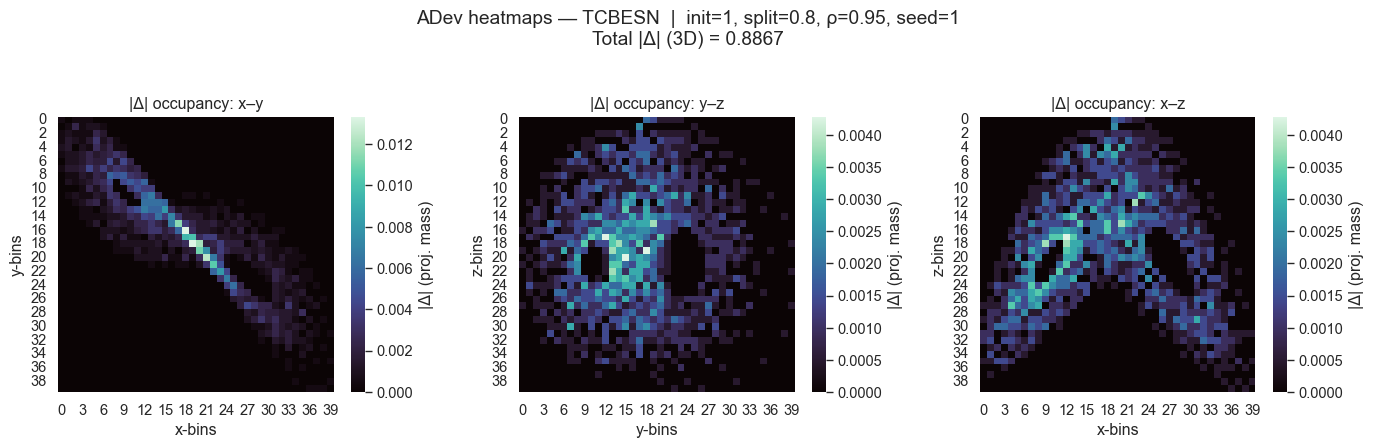

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/adev_heatmaps_TCBESN_init1_split0.8_rho0.95_seed1.png


In [62]:
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
TRUTH_COLOR = "#3b3b3b"



def plot_adev_heatmaps_per_model(pred_store, DATA, model,
                                 init_id, split, rho, seed,
                                 bins=(40,40,40),     # (nx, ny, nz)
                                 max_len=None, norm=True,
                                 cmap="mako", dpi=300,
                                 vmin=0.0, vmax=None):
    """
    ADev heatmaps (|Δ occupancy|) projected onto XY, YZ, XZ planes.

    - Uses ORIGINAL test_y from DATA[(init_id, split)] (no recomputation).
    - If `norm=True`, each 3D histogram is normalized to probability mass
      before the absolute difference is taken.
    - `vmin/vmax` let you fix a shared color scale across multiple calls.
    """
    ds_key = (init_id, split)
    if ds_key not in DATA:
        raise KeyError(f"No DATA cache for (init={init_id}, split={split}).")

    y_true = DATA[ds_key]["test_y"]

    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No predictions for {key}")
    y_pred = pred_store[key]

    # Align lengths
    T = min(len(y_true), len(y_pred))
    if max_len is not None:
        T = min(T, max_len)
    y_true = y_true[:T]
    y_pred = y_pred[:T]

    # Shared bin ranges for fairness
    mins = np.minimum(y_true.min(axis=0), y_pred.min(axis=0))
    maxs = np.maximum(y_true.max(axis=0), y_pred.max(axis=0))
    ranges = [(mins[0], maxs[0]), (mins[1], maxs[1]), (mins[2], maxs[2])]

    # 3D histograms (occupancies)
    H_true, edges = np.histogramdd(y_true, bins=bins, range=ranges)
    H_pred, _     = np.histogramdd(y_pred, bins=bins, range=ranges)

    if norm:
        s_true = H_true.sum()
        s_pred = H_pred.sum()
        if s_true > 0: H_true = H_true / s_true
        if s_pred > 0: H_pred = H_pred / s_pred

    Delta = np.abs(H_true - H_pred)          # (nx, ny, nz)
    delta_sum = float(Delta.sum())

    # 2D projections (sum over remaining axis)
    delta_xy = Delta.sum(axis=2)  # (nx, ny)
    delta_yz = Delta.sum(axis=0)  # (ny, nz)
    delta_xz = Delta.sum(axis=1)  # (nx, nz)

    # Plot heatmaps
    fig, axes = plt.subplots(1, 3, figsize=(14, 4.2))
    # XY
    sns.heatmap(delta_xy.T, ax=axes[0], cmap=cmap, cbar=True,
                square=True, vmin=vmin, vmax=vmax,
                cbar_kws=dict(label="|Δ| (proj. mass)"))
    axes[0].set_title("|Δ| occupancy: x–y")
    axes[0].set_xlabel("x-bins"); axes[0].set_ylabel("y-bins")

    # YZ
    sns.heatmap(delta_yz.T, ax=axes[1], cmap=cmap, cbar=True,
                square=True, vmin=vmin, vmax=vmax,
                cbar_kws=dict(label="|Δ| (proj. mass)"))
    axes[1].set_title("|Δ| occupancy: y–z")
    axes[1].set_xlabel("y-bins"); axes[1].set_ylabel("z-bins")

    # XZ
    sns.heatmap(delta_xz.T, ax=axes[2], cmap=cmap, cbar=True,
                square=True, vmin=vmin, vmax=vmax,
                cbar_kws=dict(label="|Δ| (proj. mass)"))
    axes[2].set_title("|Δ| occupancy: x–z")
    axes[2].set_xlabel("x-bins"); axes[2].set_ylabel("z-bins")

    plt.suptitle(
        f"ADev heatmaps — {model}  |  init={init_id}, split={split}, ρ={rho}, seed={seed}\n"
        f"Total |Δ| (3D) = {delta_sum:.4f}"
    )
    plt.tight_layout(rect=[0,0,1,0.90])

    out = FIG_DIR / f"adev_heatmaps_{model.replace(' ','').replace('/','_')}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
    print(f"Saved: {out}")

plot_adev_heatmaps_per_model(
    pred_store, DATA, "HLESN",
    init_id=1, split=0.8, rho=0.95, seed=1,
    bins=(40,40,40), max_len=4000
)


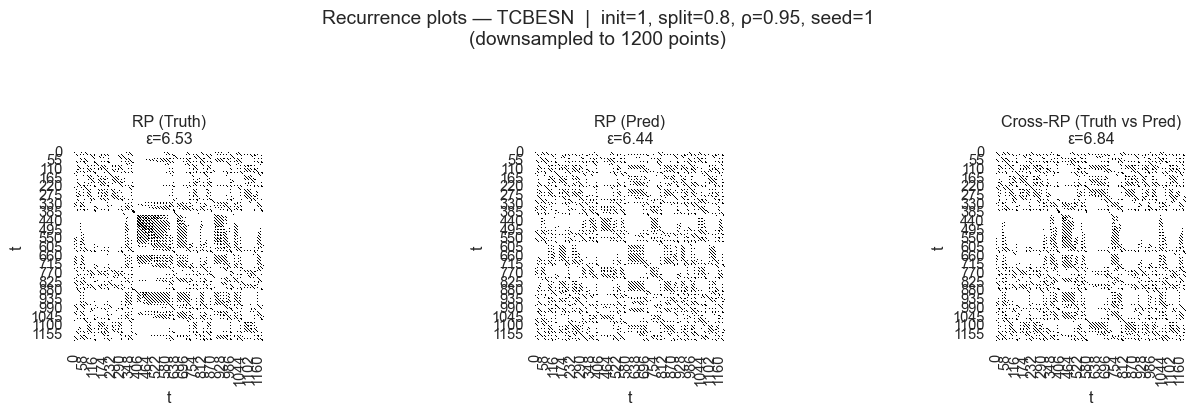

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/rp_TCBESN_init1_split0.8_rho0.95_seed1.png


In [63]:
# ================== Recurrence plots (RP / Cross-RP) ==================

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)



TRUTH_COLOR = "#3b3b3b"

def _downsample_idx(n, max_points=1500):
    if n <= max_points:
        return np.arange(n, dtype=int)
    return np.linspace(0, n-1, max_points).astype(int)

def _rp_binary(X, eps=None, quantile=0.1, metric="euclidean"):
    """
    Binary recurrence plot: R_ij = 1[dist(X[i], X[j]) <= eps].
    If eps is None, set eps to the `quantile` of pairwise distances.
    """
    X = np.asarray(X)
    if X.ndim == 1:
        X = X[:, None]
    if len(X) < 2:
        return np.ones((len(X), len(X))), 0.0

    dvec = pdist(X, metric=metric)                 # condensed
    D = squareform(dvec)                           # (T, T)
    if eps is None:
        eps = float(np.quantile(dvec, quantile)) if dvec.size else 0.0
    R = (D <= eps).astype(float)
    return R, eps

def _cross_rp_binary(X, Y, eps=None, quantile=0.1, metric="euclidean"):
    """
    Binary cross-recurrence: CR_ij = 1[dist(X[i], Y[j]) <= eps].
    If eps is None, set eps from cross-distance quantile.
    """
    X = np.asarray(X); Y = np.asarray(Y)
    if X.ndim == 1: X = X[:, None]
    if Y.ndim == 1: Y = Y[:, None]
    if len(X) == 0 or len(Y) == 0:
        return np.zeros((len(X), len(Y))), 0.0

    D = cdist(X, Y, metric=metric)                 # (Tx, Ty)
    if eps is None:
        eps = float(np.quantile(D, quantile)) if D.size else 0.0
    CR = (D <= eps).astype(float)
    return CR, eps

def plot_recurrence_plots_per_model(pred_store, DATA, model,
                                    init_id, split, rho, seed,
                                    max_points=1200, metric="euclidean",
                                    q_truth=0.1, q_pred=0.1, q_cross=0.1,
                                    cmap="Greys", dpi=300):
    """
    Three panels: RP(true), RP(pred), Cross-RP(true vs pred).
    Uses ORIGINAL test target from DATA[(init_id, split)].
    Downsamples to <= max_points for O(n^2) feasibility.
    """
    ds_key = (init_id, split)
    if ds_key not in DATA:
        raise KeyError(f"No DATA cache for (init={init_id}, split={split}).")

    y_true_full = DATA[ds_key]["test_y"]
    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No predictions for {key}")
    y_pred_full = pred_store[key]

    # Align & downsample
    T = min(len(y_true_full), len(y_pred_full))
    idx = _downsample_idx(T, max_points=max_points)
    y_true = y_true_full[:T][idx]
    y_pred = y_pred_full[:T][idx]

    # Build RPs
    R_true,  eps_t  = _rp_binary(y_true, eps=None, quantile=q_truth, metric=metric)
    R_pred,  eps_p  = _rp_binary(y_pred, eps=None, quantile=q_pred,  metric=metric)
    CR,      eps_cp = _cross_rp_binary(y_true, y_pred, eps=None, quantile=q_cross, metric=metric)

    # Plot
    fig, axes = plt.subplots(1, 3, figsize=(14, 4.2))
    for ax, M, ttl in [
        (axes[0], R_true, f"RP (Truth)\nε={eps_t:.3g}"),
        (axes[1], R_pred, f"RP (Pred)\nε={eps_p:.3g}"),
        (axes[2], CR,     f"Cross-RP (Truth vs Pred)\nε={eps_cp:.3g}"),
    ]:
        sns.heatmap(M, ax=ax, cmap=cmap, cbar=False, square=True)
        ax.set_title(ttl)
        ax.set_xlabel("t"); ax.set_ylabel("t")

    plt.suptitle(
        f"Recurrence plots — {model}  |  init={init_id}, split={split}, ρ={rho}, seed={seed}\n"
        f"(downsampled to {len(idx)} points)"
    )
    plt.tight_layout(rect=[0,0,1,0.90])

    out = FIG_DIR / f"rp_{model.replace(' ','').replace('/','_')}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
    print(f"Saved: {out}")


# ADev heatmaps 
'''plot_adev_heatmaps_per_model(
    pred_store, DATA, "Cycle",
    init_id=1, split=0.8, rho=0.95, seed=1,
    bins=(40,40,40), max_len=4000
)'''

# Recurrence plots (truth RP, pred RP, cross-RP)
plot_recurrence_plots_per_model(
    pred_store, DATA, "HLESN",
    init_id=1, split=0.8, rho=0.95, seed=1,
    max_points=1200, metric="euclidean",
    q_truth=0.1, q_pred=0.1, q_cross=0.1
)


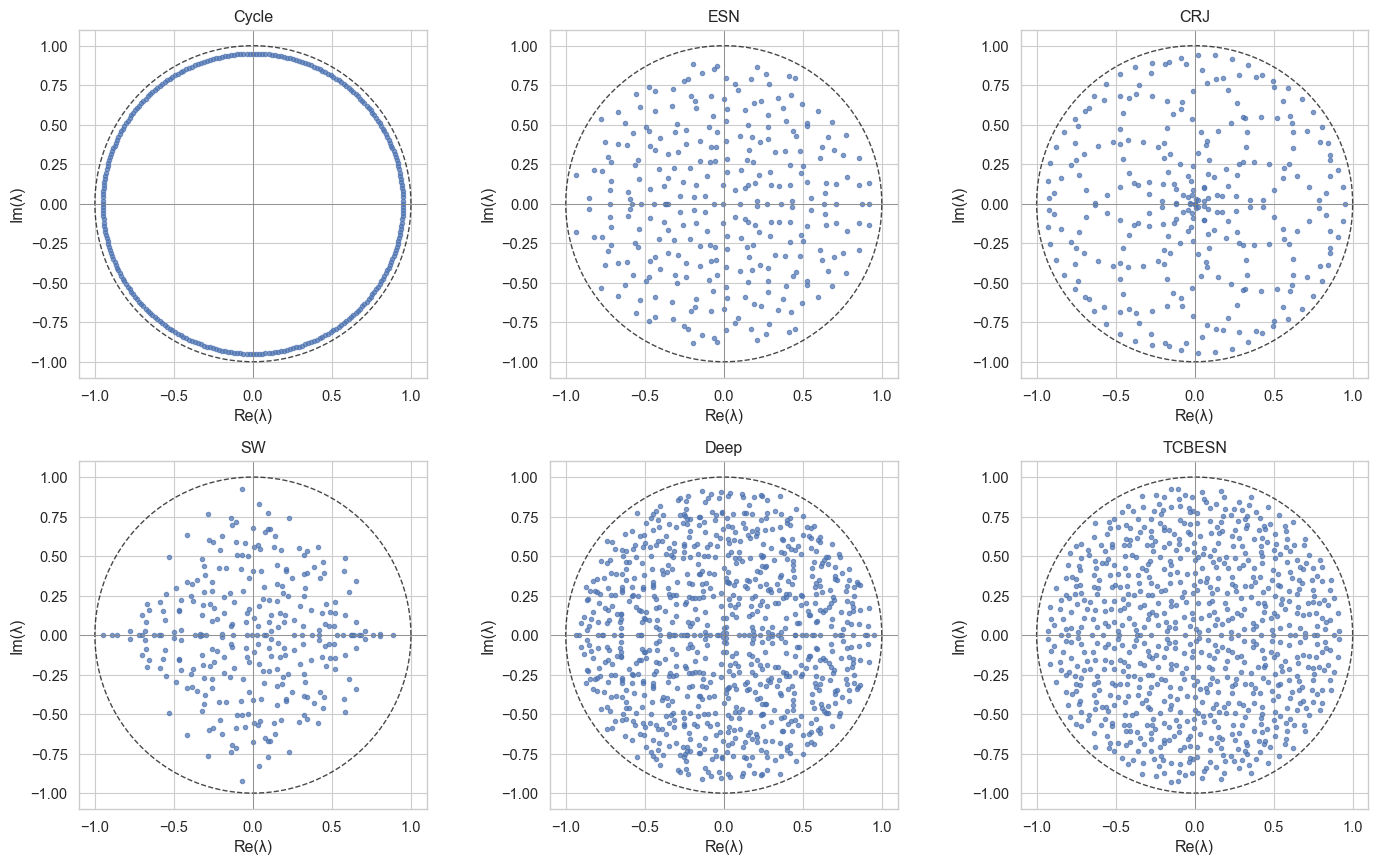

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/eigenspectrum_grid_rho0.95_seed1.png


In [158]:
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

def _safe(s): return s.replace(" ", "").replace("/", "_")

def _get_W_matrix(model):
    """
    Try to fetch the reservoir recurrent matrix from common attribute names.
    Returns a dense ndarray or raises.
    """
    for name in ["W", "W_res", "W_base", "W_nn", "A", "adj", "Wrec", "W_cc"]:
        if hasattr(model, name):
            W = getattr(model, name)
            try:
                import scipy.sparse as sp
                if sp.issparse(W):
                    W = W.toarray()
            except Exception:
                pass
            W = np.asarray(W)
            if W.ndim == 2 and W.shape[0] == W.shape[1]:
                return W
    raise AttributeError(f"Could not find a recurrent matrix on {type(model).__name__}")

def plot_eigenspectrum_models(BASELINES, TESTING_RES_CLASS, rho=0.95, seed=0,
                              add_hist=True, ncols=3, dpi=300):
    """
    One panel per model: eigenvalues in C, with unit circle. Optionally add a
    small radial histogram of |λ|.
    """
    factories = dict(BASELINES)  # copy
    if TESTING_RES_CLASS is not None:
        #factories["Testing"] = lambda r, s: TESTING_RES_CLASS(spectral_radius=r, seed=s)
        factories[TESTING_NAME] = lambda r, s: TESTING_RES_CLASS(spectral_radius_cc=r, seed=s)


    names = list(factories.keys())
    n = len(names)
    ncols = min(ncols, n)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(4.8*ncols, 4.4*nrows))
    axes = np.atleast_2d(axes)

    theta = np.linspace(0, 2*np.pi, 512)
    unit = np.exp(1j*theta)

    for idx, name in enumerate(names):
        r, c = divmod(idx, ncols)
        ax = axes[r, c]
        try:
            model = factories[name](rho, seed)
            W = _get_W_matrix(model)
            eig = np.linalg.eigvals(W)
        except Exception as e:
            ax.text(0.5, 0.5, f"Failed:\n{e}", ha="center", va="center")
            ax.axis("off"); continue

        ax.scatter(eig.real, eig.imag, s=10, alpha=0.7)
        ax.plot(unit.real, unit.imag, "k--", lw=1.0, alpha=0.8)
        ax.axhline(0, color="#888", lw=0.6); ax.axvline(0, color="#888", lw=0.6)
        ax.set_title(name)
        ax.set_xlabel("Re(λ)"); ax.set_ylabel("Im(λ)")
        ax.set_aspect("equal", adjustable="box")

        if not add_hist: # histogram is unnecessary
            inset = ax.inset_axes([0.65, 0.65, 0.32, 0.32])
            inset.hist(np.abs(eig), bins=30, density=True, alpha=0.8)
            inset.axvline(1.0, color="k", ls="--", lw=1.0)
            inset.set_title("|λ|", fontsize=9)
            inset.set_yticks([])

    # hide unused axes
    for j in range(n, nrows*ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis("off")

    #plt.suptitle(f"Eigen-spectrum (ρ={rho}, seed={seed})", y=1.02)
    plt.tight_layout()
    out = FIG_DIR / f"eigenspectrum_grid_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
    print(f"Saved: {out}")

plot_eigenspectrum_models(BASELINES, TESTING_RES_CLASS, rho=0.95, seed=1)


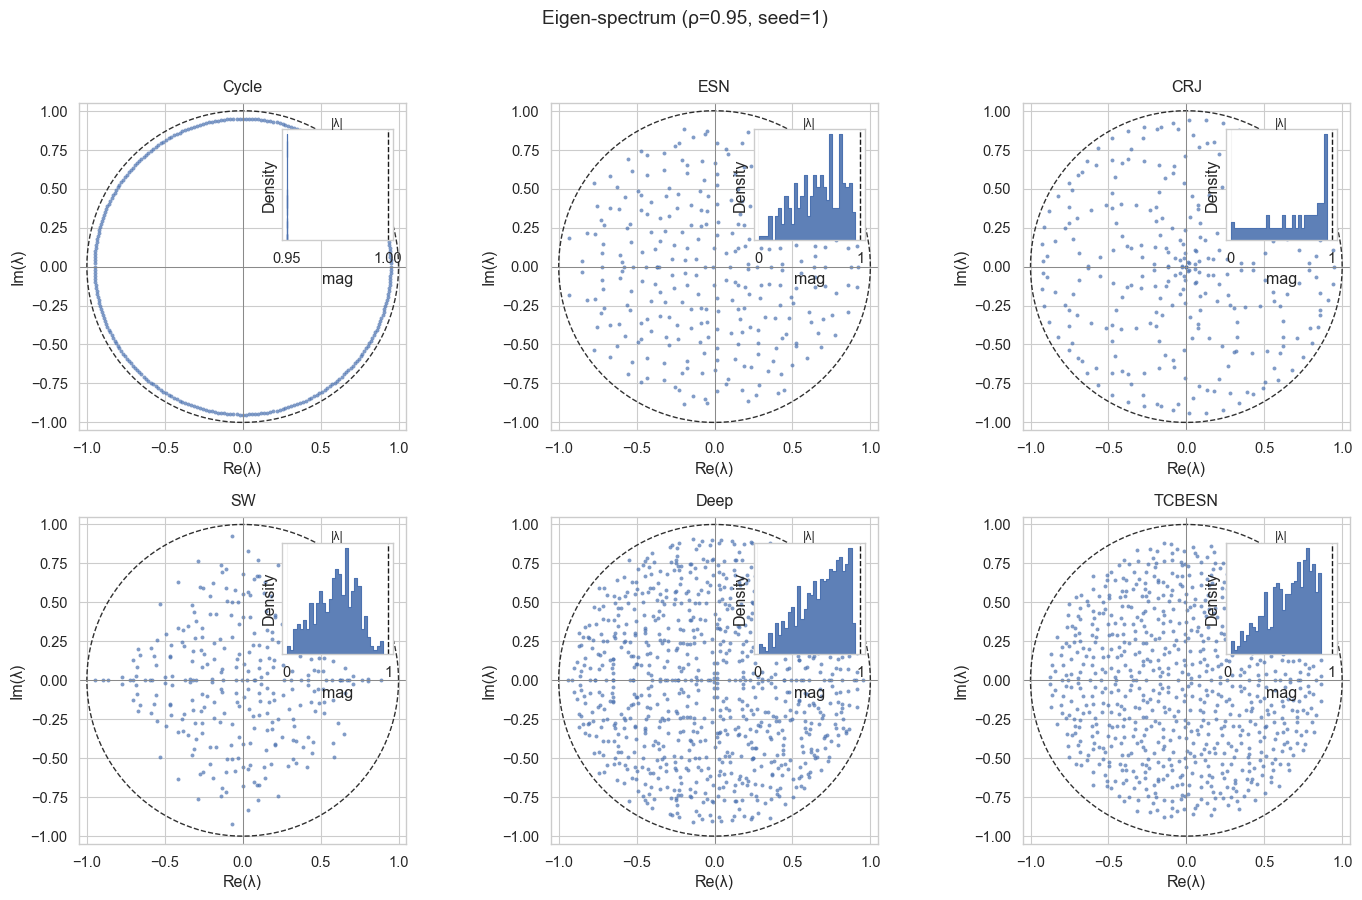

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/eigenspectrum_grid_rho0.95_seed1.png


In [65]:
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)


def _safe(s: str) -> str:
    return s.replace(" ", "").replace("/", "_")

def _get_W_matrix(model):
    """
    Try common attribute names for the (square) recurrent matrix.
    Returns a dense ndarray or raises AttributeError.
    """
    for name in ["W", "W_res", "W_base", "W_nn", "A", "adj", "Wrec", "W_cc"]:
        if hasattr(model, name):
            W = getattr(model, name)
            try:
                import scipy.sparse as sp
                if sp.issparse(W):
                    W = W.toarray()
            except Exception:
                pass
            W = np.asarray(W)
            if W.ndim == 2 and W.shape[0] == W.shape[1]:
                return W
    raise AttributeError(f"Could not find a recurrent matrix on {type(model).__name__}")

def _instantiate(factory_or_class, rho, seed):
    """
    Robustly instantiate either a factory (callable) or a class with (rho, seed).
    Tries a few common constructor signatures.
    """
    # If it's a simple factory: assume (rho, seed)
    if not inspect.isclass(factory_or_class):
        return factory_or_class(rho, seed)

    # It's a class: try several signatures
    cls = factory_or_class
    tried = []
    for kwargs in [
        {"spectral_radius": rho, "seed": seed},
        {"rho": rho, "seed": seed},
        {"rho_mix": rho, "rho_theta": rho, "rho_gamma": rho, "seed": seed},
        {"seed": seed},
        {},
    ]:
        try:
            return cls(**kwargs)
        except TypeError as e:
            tried.append((kwargs, str(e)))
            continue
    # If we get here, all attempts failed
    msgs = "\n".join([f"  tried {k} -> {m}" for k, m in tried])
    raise TypeError(f"Could not instantiate {cls.__name__} with rho={rho}, seed={seed}.\n{msgs}")

def plot_eigenspectrum_models(
    BASELINES: dict,
    TESTING_RES_CLASS=None,           # class or factory; optional
    rho: float = 0.95,
    seed: int = 0,
    add_hist: bool = True,
    ncols: int = 3,
    dpi: int = 300,
    max_points: int = 5000,           # downsample eigenvalues if huge
):
    """
    One panel per model: eigenvalues in C with unit circle; optional inset of |λ|.
    Uses seaborn styling; saves a PNG in figures/.

    BASELINES: dict[str, callable] where callable takes (rho, seed) and returns a model.
    TESTING_RES_CLASS: optional class or factory to include as "Testing".
    """
    factories = dict(BASELINES)  # copy
    if TESTING_RES_CLASS is not None:
        factories[TESTING_NAME] = lambda r, s: _instantiate(TESTING_RES_CLASS, r, s)

    names = list(factories.keys())
    n = len(names)
    ncols = min(ncols, n)
    nrows = int(np.ceil(n / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(4.8 * ncols, 4.4 * nrows))
    axes = np.atleast_2d(axes)

    theta = np.linspace(0, 2*np.pi, 1024)
    unit = np.exp(1j * theta)

    for idx, name in enumerate(names):
        r, c = divmod(idx, ncols)
        ax = axes[r, c]

        try:
            model = factories[name](rho, seed)
            W = _get_W_matrix(model)
            eig = np.linalg.eigvals(W)
        except Exception as e:
            ax.text(0.5, 0.5, f"Failed:\n{e}", ha="center", va="center", fontsize=10)
            ax.axis("off")
            continue

        # optional downsample for very large reservoirs
        if eig.size > max_points:
            sel = np.random.default_rng(seed).choice(eig.size, size=max_points, replace=False)
            eig = eig[sel]

        # scatter in complex plane (seaborn style)
        df = pd.DataFrame({"Re": eig.real, "Im": eig.imag, "mag": np.abs(eig)})
        sns.scatterplot(
            data=df, x="Re", y="Im",
            s=8, alpha=0.7, linewidth=0, ax=ax
        )

        # unit circle + axes
        ax.plot(unit.real, unit.imag, "k--", lw=1.0, alpha=0.9)
        ax.axhline(0, color="#888", lw=0.7); ax.axvline(0, color="#888", lw=0.7)

        # equal aspect and symmetric limits with a small pad
        lim = max(1.05, df[["Re","Im"]].abs().to_numpy().max() * 1.05)
        ax.set_xlim(-lim, lim)
        ax.set_ylim(-lim, lim)
        ax.set_aspect("equal", adjustable="box")

        ax.set_title(name, pad=8)
        ax.set_xlabel("Re(λ)"); ax.set_ylabel("Im(λ)")

        # inset |λ| histogram using seaborn
        if add_hist:
            inset = ax.inset_axes([0.62, 0.58, 0.34, 0.34])
            sns.histplot(df["mag"], bins=30, stat="density", element="step", alpha=0.9, ax=inset)
            inset.axvline(1.0, color="k", ls="--", lw=1.0)
            inset.set_title("|λ|", fontsize=9, pad=2)
            inset.set_yticks([])
            inset.grid(True, alpha=0.2)

    # hide unused axes
    for j in range(n, nrows * ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis("off")

    plt.suptitle(f"Eigen-spectrum (ρ={rho}, seed={seed})", y=1.02)
    plt.tight_layout()

    out = FIG_DIR / f"eigenspectrum_grid_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out}")


plot_eigenspectrum_models(BASELINES, TESTING_RES_CLASS, rho=0.95, seed=1)


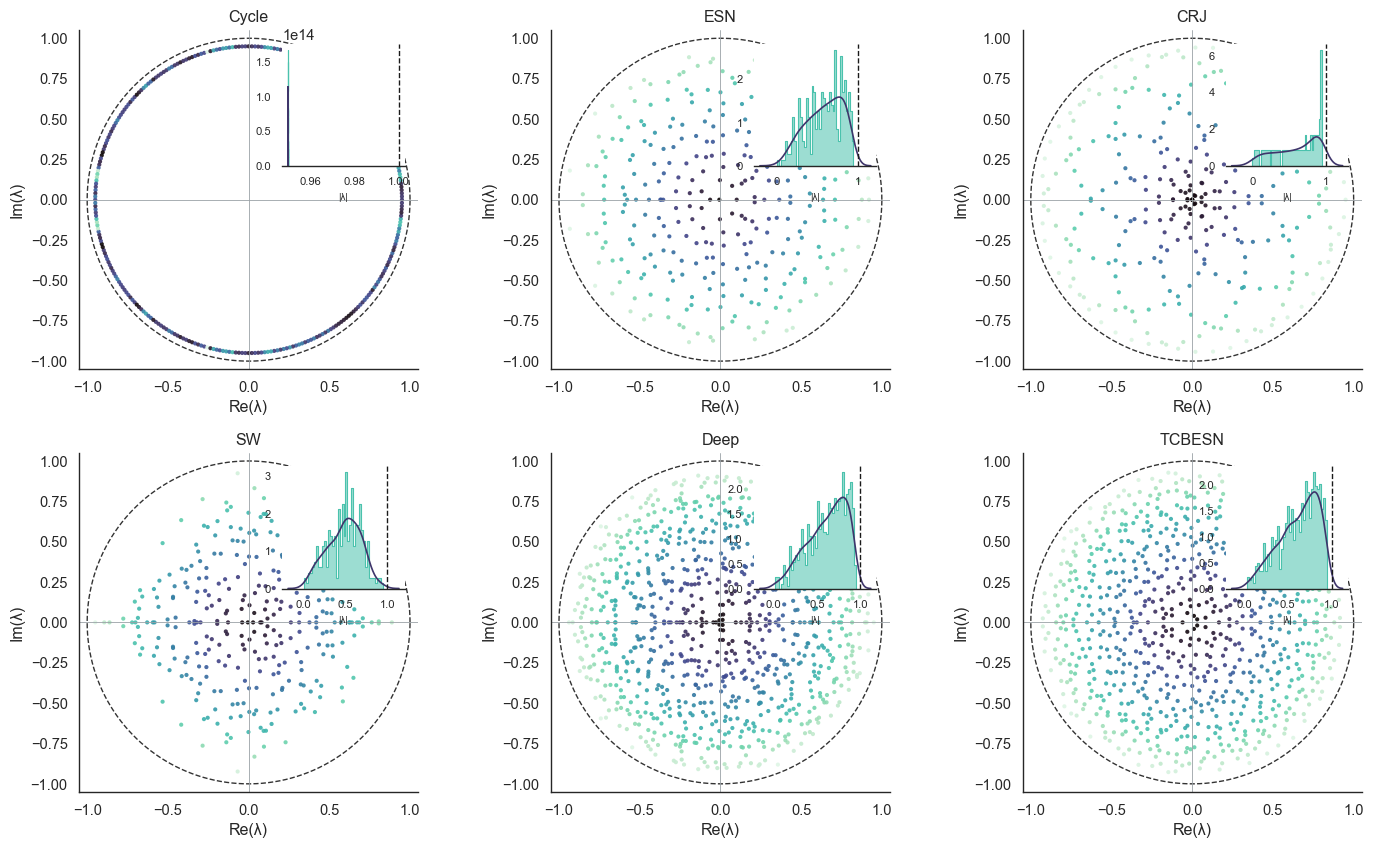

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/eigenspectrum_grid_rho0.95_seed1.png


In [159]:
sns.set_theme(style="white", context="paper", font_scale=1.2)

def _safe(s): 
    return s.replace(" ", "").replace("/", "_")

def _get_W_matrix(model):
    """
    Try to fetch the reservoir recurrent matrix from common attribute names.
    Returns a dense ndarray or raises.
    """
    for name in ["W", "W_res", "W_base", "W_nn", "A", "adj", "Wrec", "W_cc"]:
        if hasattr(model, name):
            W = getattr(model, name)
            try:
                import scipy.sparse as sp
                if sp.issparse(W):
                    W = W.toarray()
            except Exception:
                pass
            W = np.asarray(W)
            if W.ndim == 2 and W.shape[0] == W.shape[1]:
                return W
    raise AttributeError(f"Could not find a recurrent matrix on {type(model).__name__}")

def plot_eigenspectrum_models(
    BASELINES, 
    TESTING_RES_CLASS=None, 
    rho=0.95, 
    seed=0,
    add_hist=True, 
    ncols=3, 
    dpi=300,
    cmap="mako",               # seaborn colormap name
    title=None,
    save_name=None
):
    """
    One panel per model: eigenvalues in ℂ with unit circle, colored by |λ|.
    Optional inset histogram + KDE of |λ|.
    """

    # Build factory dict
    factories = dict(BASELINES)  # copy (preserve your order)
    if TESTING_RES_CLASS is not None:
        #factories["Testing"] = lambda r, s: TESTING_RES_CLASS(spectral_radius=r, seed=s)
        factories[TESTING_NAME] = lambda r, s: TESTING_RES_CLASS(spectral_radius_cc=r, seed=s)


    names = list(factories.keys())
    n = len(names)
    ncols = max(1, min(ncols, n))
    nrows = int(np.ceil(n / ncols))

    # Precompute eigenvalues so we can use consistent color scaling & limits
    eig_map, max_abs = {}, 1.0
    for name in names:
        try:
            model = factories[name](rho, seed)
            W = _get_W_matrix(model)
            eig = np.linalg.eigvals(W)
            eig_map[name] = eig
            max_abs = max(max_abs, float(np.abs(eig).max()))
        except Exception as e:
            eig_map[name] = e

    # Figure + axes
    fig, axes = plt.subplots(nrows, ncols, figsize=(4.8*ncols, 4.4*nrows))
    axes = np.atleast_2d(axes)

    # Unit circle
    theta = np.linspace(0, 2*np.pi, 512)
    unit = np.exp(1j * theta)

    # Axes limits
    rlim = max(1.05, 1.05 * max_abs)

    # Colormap
    import matplotlib as mpl
    from matplotlib import cm
    # Allow seaborn colormap strings
    try:
        cmap_obj = sns.color_palette(cmap, as_cmap=True)
    except Exception:
        cmap_obj = cm.get_cmap(cmap)

    # Plot each model
    for idx, name in enumerate(names):
        r, c = divmod(idx, ncols)
        ax = axes[r, c]
        ax.set_aspect("equal", adjustable="box")

        if isinstance(eig_map[name], Exception):
            ax.text(0.5, 0.5, f"Failed:\n{eig_map[name]}", ha="center", va="center")
            ax.axis("off")
            continue

        eig = eig_map[name]
        lam_abs = np.abs(eig)

        sc = ax.scatter(eig.real, eig.imag, s=9, c=lam_abs, cmap=cmap_obj,
                        alpha=0.9, linewidths=0)

        # Unit circle + axes
        ax.plot(unit.real, unit.imag, color="black", ls="--", lw=1.0, alpha=0.8)
        ax.axhline(0, color="#9aa1a6", lw=0.6)
        ax.axvline(0, color="#9aa1a6", lw=0.6)

        # Limits, labels
        ax.set_xlim(-rlim, rlim); ax.set_ylim(-rlim, rlim)
        ax.set_xlabel("Re(λ)"); ax.set_ylabel("Im(λ)")
        ax.set_title(name)

        # Inset |λ| distribution
        if add_hist:
            inset = ax.inset_axes([0.60, 0.60, 0.36, 0.36])
            sns.histplot(lam_abs, bins=40, stat="density", element="step",
                         fill=True, alpha=0.55, ax=inset, color=sns.color_palette("mako", 3)[2])
            try:
                sns.kdeplot(lam_abs, lw=1.2, ax=inset, color=sns.color_palette("mako", 3)[0])
            except Exception:
                pass
            inset.axvline(1.0, color="k", ls="--", lw=1.0)
            inset.set_xlabel("|λ|", fontsize=7)
            inset.set_ylabel("")
            inset.tick_params(axis="both", labelsize=8)
            sns.despine(ax=inset, left=True, bottom=False)

        sns.despine(ax=ax)

    # Hide unused axes
    for j in range(n, nrows * ncols):
        r, c = divmod(j, ncols)
        axes[r, c].axis("off")

    # Global title and colorbar
    #if title is None:
        #title = f"Eigen-spectrum (ρ={rho}, seed={seed})"
    fig.suptitle(title, y=1.02)

    # Shared colorbar for |λ|
    # Create a fake ScalarMappable with global normalization
    '''norm = mpl.colors.Normalize(vmin=0, vmax=max_abs)
    sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap_obj)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=axes.ravel().tolist(), fraction=0.018, pad=0.02)
    cbar.set_label("|λ|")'''

    plt.tight_layout()

    # Save
    if save_name is None:
        save_name = f"eigenspectrum_grid_rho{rho}_seed{seed}.png"
    out = FIG_DIR / save_name
    plt.savefig(out, dpi=dpi, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out}")


plot_eigenspectrum_models(BASELINES, TESTING_RES_CLASS, rho=0.95, seed=1)


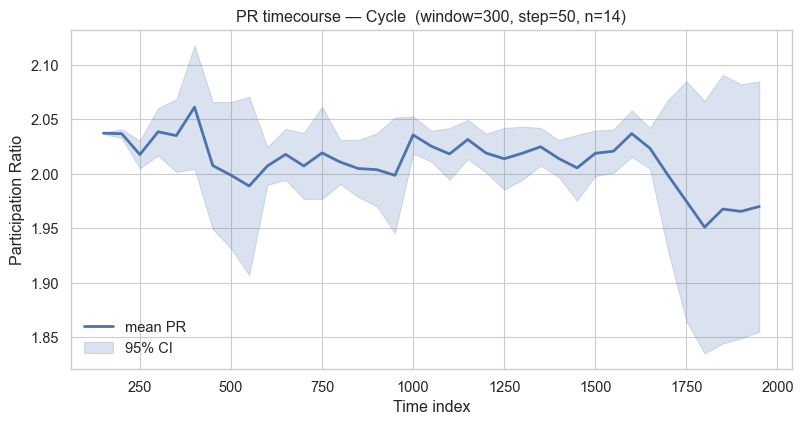

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/pr_timecourse_Cycle.png


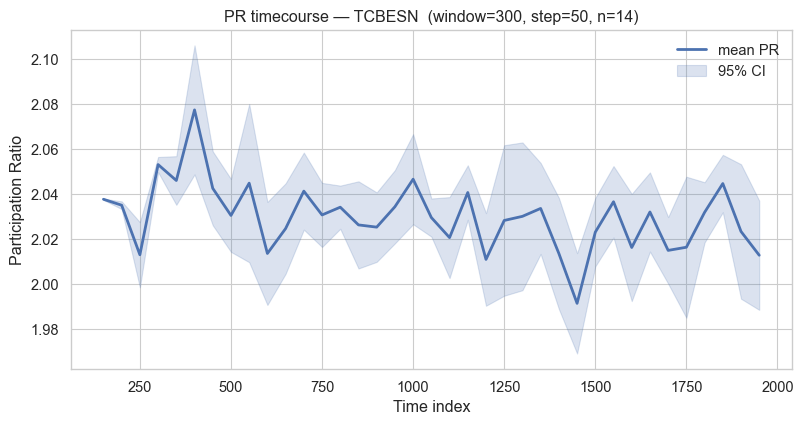

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/pr_timecourse_TCBESN.png


In [67]:
# ===================== Participation Ratio utilities & plots =====================

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)



def _safe_name(s: str) -> str:
    return str(s).replace(" ", "").replace("/", "_")

def participation_ratio(X: np.ndarray) -> float:
    """
    Effective dimensionality: (tr Σ)^2 / tr(Σ^2), where Σ is the column covariance.
    X shape: [T, D]  (time × dims)
    """
    X = np.asarray(X, dtype=float)
    if X.ndim != 2 or X.shape[0] < 2:
        return np.nan
    Xc = X - X.mean(axis=0, keepdims=True)
    C = np.cov(Xc, rowvar=False)  # D×D
    tr = float(np.trace(C))
    tr2 = float(np.sum(C * C))    # Frobenius norm squared
    if tr2 <= 0 or not np.isfinite(tr2):
        return np.nan
    return (tr * tr) / (tr2 + 1e-12)

def pr_timecourse_from_preds(pred: np.ndarray, window: int = 300, step: int = 50):
    """
    Sliding-window PR over predicted outputs (dims in columns).
    Returns: (center_indices, PR_values)
    """
    pred = np.asarray(pred, dtype=float)
    if pred.ndim == 1:
        pred = pred[:, None]
    T = len(pred)
    if window < 2 or T < window:
        # not enough data for one window
        return np.array([], dtype=int), np.array([], dtype=float)

    vals, centers = [], []
    for s in range(0, T - window + 1, step):
        Xw = pred[s:s+window]
        vals.append(participation_ratio(Xw))
        centers.append(s + window // 2)
    return np.asarray(centers, dtype=int), np.asarray(vals, dtype=float)

def plot_pr_timecourse_mean_ci(pred_store: dict, model: str, scenarios: list,
                               window: int = 300, step: int = 50, dpi: int = 300,
                               color: str = "C0"):
    """
    scenarios: list of keys (Model, Init, Split, Rho, Seed) to average PR over.
    Uses predictions only (no ground truth needed).
    """
    if not scenarios:
        raise ValueError("No scenarios provided.")

    all_t, all_pr = [], []
    for key in scenarios:
        if key[0] != model:
            raise ValueError(f"Scenario {key} does not match model '{model}'.")
        if key not in pred_store:
            # skip missing predictions gracefully
            continue
        pred = pred_store[key]
        t_idx, pr = pr_timecourse_from_preds(pred, window=window, step=step)
        if len(pr) == 0:
            continue
        all_t.append(t_idx)
        all_pr.append(pr)

    if not all_pr:
        raise ValueError("No valid PR series (maybe window too large for sequences).")

    # Align by minimum common length
    L = min(map(len, all_pr))
    all_pr = np.stack([p[:L] for p in all_pr], axis=0)
    t_idx = all_t[0][:L]
    mean = np.nanmean(all_pr, axis=0)
    sd   = np.nanstd(all_pr, axis=0)
    n    = all_pr.shape[0]
    ci   = 1.96 * sd / np.sqrt(max(n, 1))

    plt.figure(figsize=(8.2, 4.4))
    plt.plot(t_idx, mean, lw=2.0, color=color, label="mean PR")
    plt.fill_between(t_idx, mean - ci, mean + ci, color=color, alpha=0.20, label="95% CI")
    plt.xlabel("Time index")
    plt.ylabel("Participation Ratio")
    plt.title(f"PR timecourse — {model}  (window={window}, step={step}, n={n})")
    plt.legend(frameon=False)
    plt.tight_layout()
    out = FIG_DIR / f"pr_timecourse_{_safe_name(model)}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out}")

def plot_pr_vs_error(df_metrics: pd.DataFrame, pr_dict: dict,
                     metric: str = "NRMSE", horizon: int = 1000, dpi: int = 300):
    """
    Scatter of model-wise mean PR vs performance metric.

    df_metrics: DataFrame containing per-scenario metrics with at least a 'Model' column.
                If it has a 'Horizon' column, we select rows with Horizon==horizon.
    pr_dict   : {(Model, Init, Split, Rho, Seed)->PR} or {Model->PR}. We average by Model.
    """
    # Build PR per model
    rows = []
    for k, v in pr_dict.items():
        mdl = k[0] if isinstance(k, tuple) else k
        rows.append({"Model": mdl, "PR": float(v)})
    pr_df = pd.DataFrame(rows)
    pr_mean = pr_df.groupby("Model", as_index=True)["PR"].mean()

    # Build metric per model
    if "Horizon" in df_metrics.columns:
        met_series = (df_metrics[df_metrics["Horizon"] == horizon]
                      .groupby("Model", as_index=True)[metric].mean())
    else:
        met_series = df_metrics.groupby("Model", as_index=True)[metric].mean()

    # Align and drop missing
    dfp = pd.concat([pr_mean, met_series], axis=1).dropna()
    if dfp.empty:
        raise ValueError("No overlapping models between PR and metrics.")

    plt.figure(figsize=(6.6, 5.2))
    sns.regplot(data=dfp.reset_index(), x="PR", y=metric, scatter_kws=dict(s=60, alpha=0.85))
    # annotate points
    for _, row in dfp.reset_index().iterrows():
        plt.annotate(row["Model"], (row["PR"], row[metric]),
                     textcoords="offset points", xytext=(6, 6))
    plt.title(f"Participation Ratio vs {metric}" + (f"  (h={horizon})" if "Horizon" in df_metrics.columns else ""))
    plt.tight_layout()
    out = FIG_DIR / f"pr_vs_{metric}" / ("h" + str(horizon) if "Horizon" in df_metrics.columns else "overall")
    out.parent.mkdir(parents=True, exist_ok=True)
    out = out.with_suffix(".png")
    plt.savefig(out, dpi=dpi, bbox_inches="tight")
    plt.show()
    print(f"Saved: {out}")

# choose scenarios for one model 
scens = [k for k in pred_store if k[0] == "Cycle"  and k[2] == 0.8 and k[3] == 0.95]
plot_pr_timecourse_mean_ci(pred_store, "Cycle",   scens, window=300, step=50)

scens = [k for k in pred_store if k[0] == "HLESN" and k[2] == 0.8 and k[3] == 0.95]
plot_pr_timecourse_mean_ci(pred_store, "HLESN", scens, window=300, step=50)


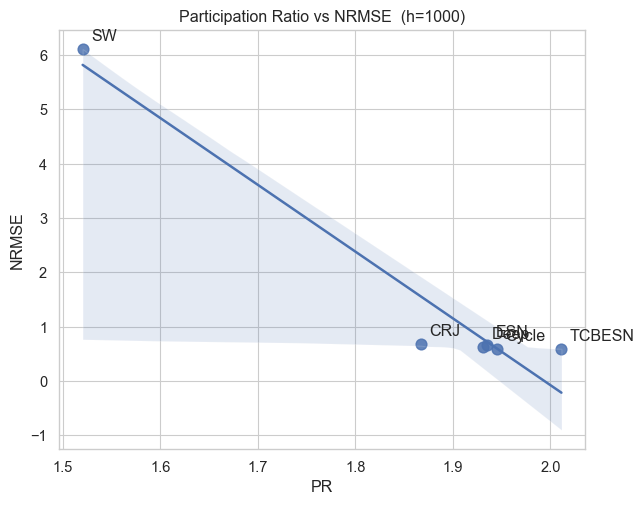

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/pr_vs_NRMSE/h1000.png


In [68]:
# =================== PR vs NRMSE@1000 (no truth recomputation) ===================

H = 1000  # target horizon

# 1) One-number PR per scenario (whole prediction window)
pr_per_scen = {
    k: participation_ratio(pred_store[k])
    for k in pred_store.keys()
}

# 2) Build per-scenario NRMSE@1000 using ORIGINAL test_y from DATA cache
rows = []
skipped = 0
for k, pred in pred_store.items():
    # key format: (Model, Init, Split, Rho, Seed)
    model, init_id, split, rho, seed = k

    # fetch ORIGINAL test target from cache
    if 'DATA' not in globals() or (init_id, split) not in DATA:
        raise RuntimeError(
            f"DATA cache missing for (init={init_id}, split={split}). "
            "Please build DATA[(init, split)] with {'test_y', 'time_test', ...}."
        )
    y_true = DATA[(init_id, split)]["test_y"]

    # ensure equal length & enough samples for the requested horizon
    T = min(len(pred), len(y_true))
    if T < H:
        skipped += 1
        continue

    # compute NRMSE at horizon H using your existing helper
    nrmse_at_H = evaluate_nrmse(pred[:H], y_true[:H], [H])[H]
    rows.append({"Model": model, "Horizon": H, "NRMSE": nrmse_at_H})

if skipped:
    print(f"Note: skipped {skipped} scenario(s) with fewer than {H} steps.")

df_metrics = pd.DataFrame(rows)

# 3) Plot PR (per-scenario) vs NRMSE@1000 (aggregated to per-model inside the helper)
plot_pr_vs_error(df_metrics, pr_per_scen, metric="NRMSE", horizon=H)


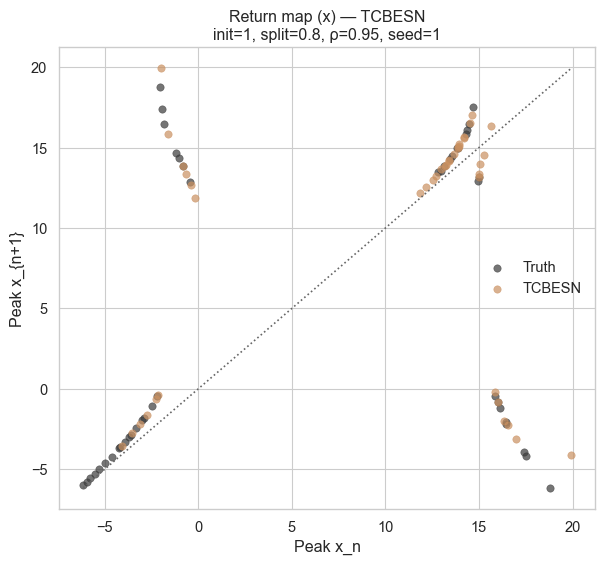

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/returnmap_TCBESN_x_init1_split0.8_rho0.95_seed1.png


In [69]:
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)

def _safe(s): return s.replace(" ", "").replace("/", "_")

def _extract_peaks(sig, distance=20, prominence=None):
    """Return peak values in order."""
    idx, _ = find_peaks(sig, distance=distance, prominence=prominence)
    return sig[idx]

def plot_return_map_per_model(pred_store, DATA, model, init_id, split, rho, seed,
                              component=0, distance=20, prominence=None,
                              dpi=300):
    """Return map: peak_{n+1} vs peak_n for truth & model (chosen component)."""
    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No predictions for {key}")
    y_pred = pred_store[key]
    y_true = DATA[(init_id, split)]["test_y"]
    T = min(len(y_true), len(y_pred))
    y_true, y_pred = y_true[:T], y_pred[:T]

    # peaks
    pt = _extract_peaks(y_true[:, component], distance=distance, prominence=prominence)
    pp = _extract_peaks(y_pred[:, component], distance=distance, prominence=prominence)

    # build x_n -> x_{n+1}
    def _pairs(v):
        return v[:-1], v[1:] if len(v) > 1 else (np.array([]), np.array([]))
    xt, yt = _pairs(pt)
    xp, yp = _pairs(pp)

    comp_name = ["x", "y", "z"][component]
    plt.figure(figsize=(6.2, 5.8))
    sns.scatterplot(x=xt, y=yt, s=28, color=TRUTH_COLOR, label="Truth", alpha=0.7, edgecolor=None)
    sns.scatterplot(x=xp, y=yp, s=28, color=PALETTE.get(model, "C0"), label=model, alpha=0.7, edgecolor=None)

    # y=x reference & limits
    lo = min(xt.min() if len(xt) else 0, xp.min() if len(xp) else 0,
             yt.min() if len(yt) else 0, yp.min() if len(yp) else 0)
    hi = max(xt.max() if len(xt) else 1, xp.max() if len(xp) else 1,
             yt.max() if len(yt) else 1, yp.max() if len(yp) else 1)
    plt.plot([lo, hi], [lo, hi], ls=":", color="#666", lw=1.2)
    plt.xlabel(f"Peak {comp_name}_n"); plt.ylabel(f"Peak {comp_name}_{{n+1}}")
    plt.title(f"Return map ({comp_name}) — {model}\ninit={init_id}, split={split}, ρ={rho}, seed={seed}")
    plt.legend(frameon=False); plt.tight_layout()
    out = FIG_DIR / f"returnmap_{_safe(model)}_{comp_name}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
    print(f"Saved: {out}")

plot_return_map_per_model(pred_store, DATA, "HLESN", init_id=1, split=0.8, rho=0.95, seed=1,
                          component=0, distance=30, prominence=None)


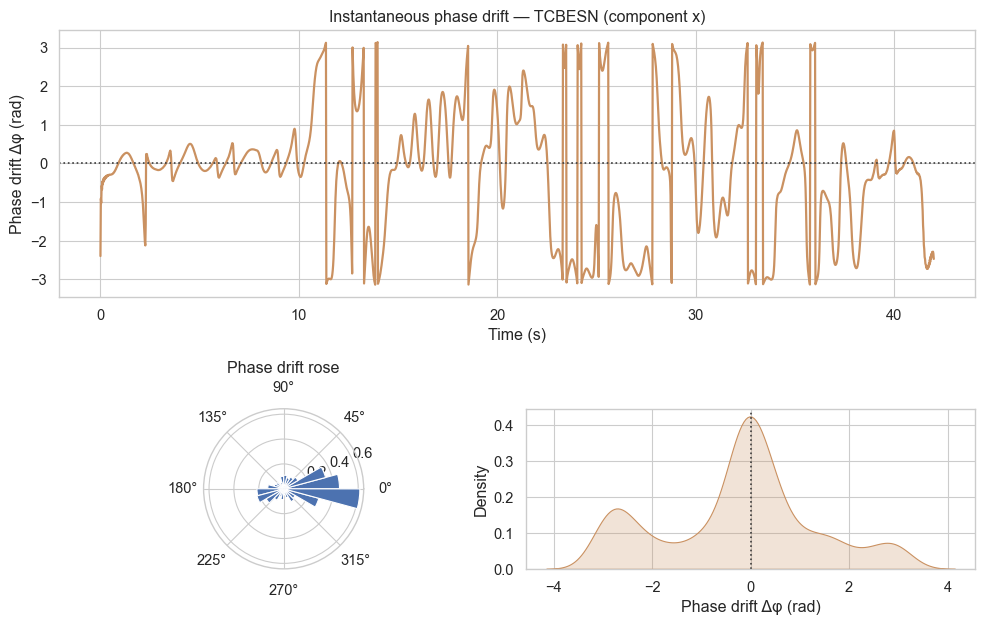

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/phase_drift_TCBESN_x_init1_split0.8_rho0.95_seed1.png


In [70]:
def _phase(sig):
    """Analytic phase in radians, unwrapped."""
    a = hilbert(sig - np.mean(sig))
    return np.unwrap(np.angle(a))

def plot_phase_drift_per_model(pred_store, DATA, model, init_id, split, rho, seed,
                               component=0, max_len=None, bins=24, dpi=300):
    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No predictions for {key}")
    y_pred = pred_store[key]
    y_true = DATA[(init_id, split)]["test_y"]
    T = min(len(y_true), len(y_pred))
    if max_len is not None: T = min(T, max_len)
    y_true, y_pred = y_true[:T, component], y_pred[:T, component]

    φ_true = _phase(y_true)
    φ_pred = _phase(y_pred)
    Δφ = np.mod(φ_pred - φ_true + np.pi, 2*np.pi) - np.pi  # wrap to (-π, π)

    t = DATA[(init_id, split)]["time_test"][:T]

    # layout: time series (top) + rose histogram (bottom)
    fig = plt.figure(figsize=(10, 6.4))
    gs = fig.add_gridspec(2, 2, height_ratios=[2.0, 1.2])
    ax0 = fig.add_subplot(gs[0, :])
    ax1 = fig.add_subplot(gs[1, 0], projection='polar')
    ax2 = fig.add_subplot(gs[1, 1])

    # phase drift time-course
    ax0.plot(t, Δφ, color=PALETTE.get(model, "C0"), lw=1.6)
    ax0.axhline(0, color=TRUTH_COLOR, ls=":", lw=1.2)
    ax0.set_ylabel("Phase drift Δφ (rad)"); ax0.set_xlabel("Time (s)")
    ax0.set_title(f"Instantaneous phase drift — {model} (component {['x','y','z'][component]})")

    # rose histogram
    theta = Δφ % (2*np.pi)
    ax1.hist(theta, bins=bins, density=True)
    ax1.set_title("Phase drift rose")

    # KDE of phase drift
    sns.kdeplot(x=Δφ, fill=True, ax=ax2, color=PALETTE.get(model, "C0"))
    ax2.axvline(0, color=TRUTH_COLOR, ls=":", lw=1.2)
    ax2.set_xlabel("Phase drift Δφ (rad)"); ax2.set_ylabel("Density")
    plt.tight_layout()
    out = FIG_DIR / f"phase_drift_{_safe(model)}_{['x','y','z'][component]}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
    print(f"Saved: {out}")

plot_phase_drift_per_model(pred_store, DATA, "HLESN", init_id=1, split=0.8, rho=0.95, seed=1, component=0)

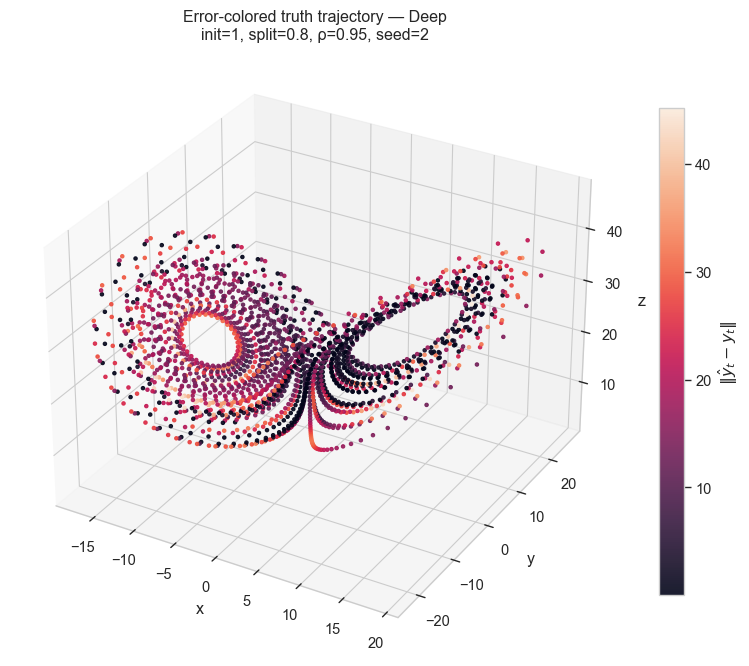

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/err_colored_attractor_Deep_init1_split0.8_rho0.95_seed2.png


In [71]:
def plot_error_colored_attractor(pred_store, DATA, model, init_id, split, rho, seed,
                                 max_points=8000, cmap="rocket", dpi=300):
    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No predictions for {key}")
    Yp = pred_store[key]
    Yt = DATA[(init_id, split)]["test_y"]
    T = min(len(Yp), len(Yt))
    Yp, Yt = Yp[:T], Yt[:T]

    err = np.linalg.norm(Yp - Yt, axis=1)  # pointwise 3D error
    # downsample evenly to keep picture crisp
    if T > max_points:
        idx = np.linspace(0, T-1, max_points).astype(int)
        Yt, err = Yt[idx], err[idx]

    fig = plt.figure(figsize=(8.4, 6.8))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(Yt[:,0], Yt[:,1], Yt[:,2], c=err, cmap=cmap, s=6, alpha=0.9)
    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
    cb = plt.colorbar(sc, pad=0.05, shrink=0.8)
    cb.set_label(r"$\| \hat{y}_t - y_t \|$")
    ax.set_title(f"Error-colored truth trajectory — {model}\ninit={init_id}, split={split}, ρ={rho}, seed={seed}")
    plt.tight_layout()
    out = FIG_DIR / f"err_colored_attractor_{_safe(model)}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
    print(f"Saved: {out}")

plot_error_colored_attractor(pred_store, DATA, "Deep", init_id=1, split=0.8, rho=0.95, seed=2)

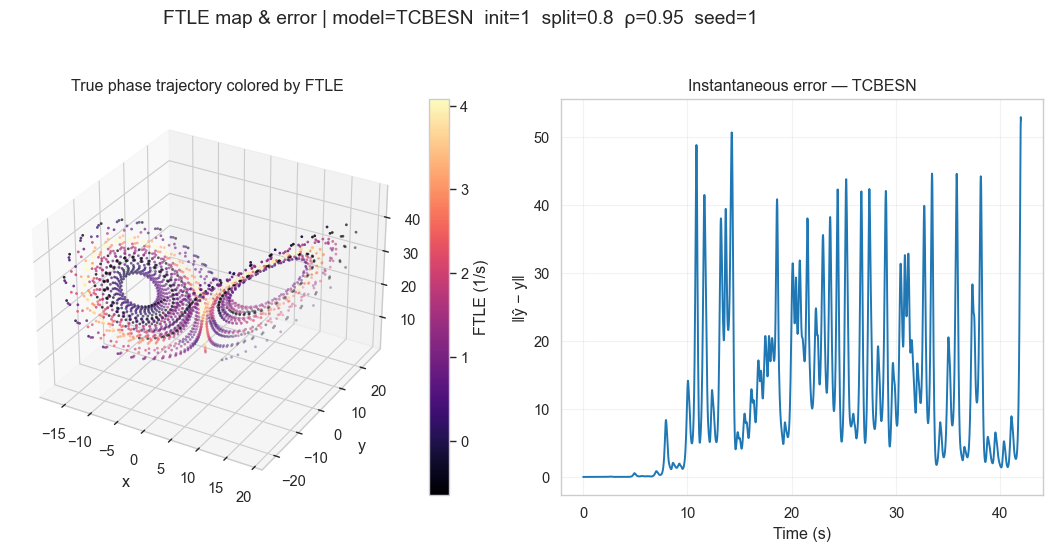

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/ftle_map_TCBESN_init1_split0.8_rho0.95_seed1.png


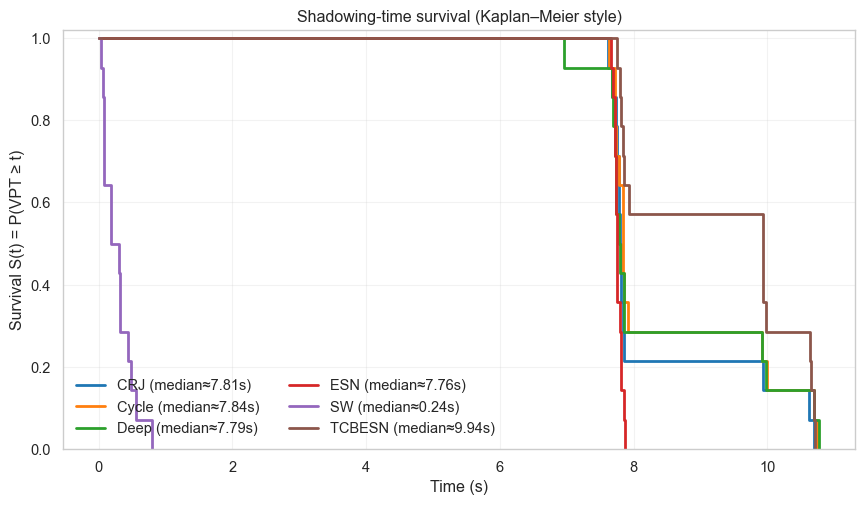

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/survival_shadowing_curves.png


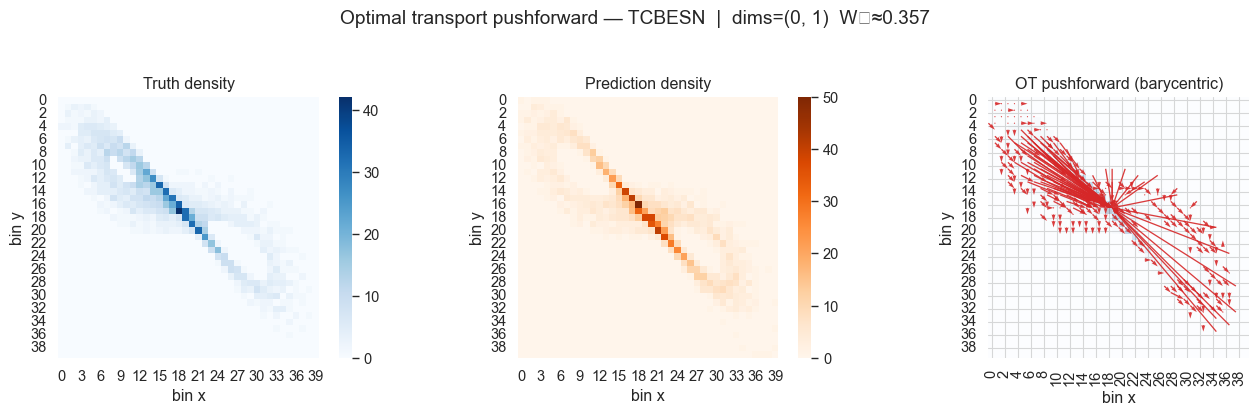

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/ot_pushforward_TCBESN_init1_split0.8_rho0.95_seed1_d01.png


In [72]:
# ============================================
# FTLE map • Shadowing-time survival • OT pushforward
# ============================================

sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)


# Palette helper
def _palette_from_pred_store(pred_store, palette="tab10"):
    models = sorted({k[0] for k in pred_store.keys()})
    pal = sns.color_palette(palette, n_colors=len(models))
    return {m: pal[i] for i, m in enumerate(models)}

# ------------------------------------------------------------
# 1) FTLE map along the true trajectory (per-model figure)
# ------------------------------------------------------------
def plot_ftle_map(DATA, pred_store, model, init_id, split, rho, seed,
                  tau_steps=40, theiler=50, max_len=5000,
                  cmap="magma", truth_color="#3b3b3b", dpi=300):
    """
    Colors the TRUE 3D trajectory by local FTLE, computed via nearest-neighbor
    separation over a horizon of 'tau_steps' while skipping a Theiler window.
    Also overlays instantaneous error ‖ŷ - y‖ over time.
    """
    # --- fetch truth + time
    y_true = DATA[(init_id, split)]["test_y"]
    t      = DATA[(init_id, split)]["time_test"]
    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No preds for {key}")
    y_pred = pred_store[key]

    # align
    T = min(len(t), len(y_true), len(y_pred))
    t = t[:T]; y_true = y_true[:T]; y_pred = y_pred[:T]

    if max_len is not None:
        T = min(T, max_len)
        t = t[:T]; y_true = y_true[:T]; y_pred = y_pred[:T]

    dt = float(np.mean(np.diff(t))) if len(t) > 1 else 1.0
    if T <= tau_steps + 2:
        raise ValueError("Sequence too short for given tau_steps.")

    # --- FTLE via nearest neighbor with Theiler window
    eps = 1e-12
    ftle = np.full(T, np.nan, dtype=float)
    tree = cKDTree(y_true[:-tau_steps])  # neighbors only where j+tau valid

    for i in range(T - tau_steps):
        # query a few neighbors; pick first outside Theiler window
        dists, idxs = tree.query(y_true[i], k=min(15, T - tau_steps))
        if np.isscalar(idxs):
            idxs = np.array([idxs])
            dists = np.array([dists])
        j = None
        for cand in idxs:
            if abs(cand - i) > theiler:
                j = int(cand); break
        if j is None:
            continue
        d0 = norm(y_true[i] - y_true[j]) + eps
        d1 = norm(y_true[i + tau_steps] - y_true[j + tau_steps]) + eps
        ftle[i] = (1.0 / (tau_steps * dt)) * np.log(d1 / d0)

    # robust color scaling
    vmin = np.nanpercentile(ftle, 5)
    vmax = np.nanpercentile(ftle, 95)
    if not np.isfinite(vmin) or not np.isfinite(vmax) or vmin == vmax:
        vmin, vmax = np.nanmin(ftle), np.nanmax(ftle)

    # error norm
    err = norm(y_pred - y_true, axis=1)

    # --- figure: left 3D colored by FTLE, right error over time
    fig = plt.figure(figsize=(12, 5.6))
    gs = GridSpec(1, 2, width_ratios=[1.2, 1.0], figure=fig)
    ax3d = fig.add_subplot(gs[0, 0], projection="3d")

    # Use scatter with FTLE color
    cvals = ftle
    sc = ax3d.scatter(y_true[:,0], y_true[:,1], y_true[:,2],
                      c=cvals, cmap=cmap, s=4, linewidths=0, vmin=vmin, vmax=vmax)
    ax3d.set_xlabel("x"); ax3d.set_ylabel("y"); ax3d.set_zlabel("z")
    ax3d.set_title("True phase trajectory colored by FTLE")
    cb = fig.colorbar(sc, ax=ax3d, fraction=0.046, pad=0.04)
    cb.set_label("FTLE (1/s)")

    ax = fig.add_subplot(gs[0, 1])
    ax.plot(t, err, lw=1.4, color="#1f77b4")
    ax.set_xlabel("Time (s)"); ax.set_ylabel("‖ŷ − y‖")
    ax.set_title(f"Instantaneous error — {model}")
    ax.grid(alpha=0.25)

    plt.suptitle(f"FTLE map & error | model={model}  init={init_id}  split={split}  ρ={rho}  seed={seed}")
    plt.tight_layout(rect=[0,0,1,0.95])

    out = FIG_DIR / f"ftle_map_{model.replace(' ','')}_init{init_id}_split{split}_rho{rho}_seed{seed}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
    print(f"Saved: {out}")

# ------------------------------------------------------------
# 2) Shadowing-time survival curves (Kaplan–Meier style)
# ------------------------------------------------------------
def _km_from_times(times):
    """
    Given list/array of positive times (shadowing durations), return step points (x, S(x)).
    S(t) = P(T >= t). Censoring not handled; assumes full observations.
    """
    times = np.asarray(times, float)
    times = times[np.isfinite(times) & (times >= 0)]
    if times.size == 0:
        return np.array([0.0]), np.array([1.0])
    ts = np.sort(times)
    n = len(ts)
    xs = np.r_[0.0, ts]
    # S jumps down at each observed time (no ties handled separately—fine visually)
    S = [1.0]
    remaining = n
    last = 0.0
    for t in ts:
        remaining -= 1
        S.append(remaining / n)
        last = t
    return xs, np.array(S)

def plot_shadowing_survival(pred_store, DATA, models=None, splits=None, rhos=None, seeds=None,
                            threshold=0.4, lambda_max=None, palette="tab10",
                            title="Shadowing-time survival (Kaplan–Meier style)",
                            dpi=300):
    """
    Build survival curves S(t) = P(VPT >= t). Uses your compute_valid_prediction_time().
    Filters by model/split/rho/seed if provided.
    """
    # try to grab lambda_max from your global map if not supplied
    if lambda_max is None:
        try:
            lambda_max = LAMBDA_MAP.get(SYSTEM.lower(), 0.9)
        except Exception:
            lambda_max = 0.9

    # selection
    keys = list(pred_store.keys())
    if models is not None:
        keys = [k for k in keys if k[0] in set(models)]
    if splits is not None:
        keys = [k for k in keys if k[2] in set(splits)]
    if rhos is not None:
        keys = [k for k in keys if k[3] in set(rhos)]
    if seeds is not None:
        keys = [k for k in keys if k[4] in set(seeds)]

    if len(keys) == 0:
        raise ValueError("No matching scenarios in pred_store with given filters.")

    model_list = sorted({k[0] for k in keys})
    palmap = {m: c for m, c in zip(model_list, sns.color_palette(palette, n_colors=len(model_list)))}

    # compute VPT per scenario
    vpts = {m: [] for m in model_list}
    for (model, init_id, split, rho, seed) in keys:
        y_true = DATA[(init_id, split)]["test_y"]
        t      = DATA[(init_id, split)]["time_test"]
        pred   = pred_store[(model, init_id, split, rho, seed)]
        T = min(len(t), len(y_true), len(pred))
        y_true = y_true[:T]; pred = pred[:T]; t = t[:T]
        try:
            T_VPT, T_lambda, _ = compute_valid_prediction_time(
                y_true, pred, t, threshold=threshold, lambda_max=lambda_max
            )
            vpts[model].append(float(T_VPT))
        except Exception:
            # fall back: first time error exceeds threshold (absolute norm)
            err = norm(pred - y_true, axis=1)
            idx = np.argmax(err > threshold)
            tv = t[idx] if (err > threshold).any() else t[-1]
            vpts[model].append(float(tv))

    # plot survival curves
    plt.figure(figsize=(8.8, 5.2))
    for m in model_list:
        xs, S = _km_from_times(vpts[m])
        plt.step(xs, S, where="post", color=palmap[m], lw=2, label=f"{m} (median≈{np.nanmedian(vpts[m]):.2f}s)")
    plt.ylim(0, 1.02)
    plt.xlabel("Time (s)"); plt.ylabel("Survival S(t) = P(VPT ≥ t)")
    plt.title(title)
    plt.grid(alpha=0.25)
    plt.legend(frameon=False, ncol=2)
    out = FIG_DIR / "survival_shadowing_curves.png"
    plt.tight_layout(); plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
    print(f"Saved: {out}")

# ------------------------------------------------------------
# 4) Optimal-transport “pushforward” (2D plane) via Sinkhorn
# ------------------------------------------------------------
def _hist2d_with_centers(X, dims=(0,1), bins=40, ranges=None):
    if isinstance(bins, int): bins = (bins, bins)
    x = X[:, dims[0]]; y = X[:, dims[1]]
    if ranges is None:
        xr = (x.min(), x.max()); yr = (y.min(), y.max())
    else:
        xr, yr = ranges
    H, xedges, yedges = np.histogram2d(x, y, bins=bins, range=[xr, yr])
    # centers
    xc = 0.5*(xedges[:-1] + xedges[1:])
    yc = 0.5*(yedges[:-1] + yedges[1:])
    Xc, Yc = np.meshgrid(xc, yc, indexing="ij")
    centers = np.stack([Xc.ravel(), Yc.ravel()], axis=1)  # (n_cells, 2)
    return H, centers, (xr, yr)

def _sinkhorn(a, b, C, reg=0.05, n_iter=200, tol=1e-9):
    """
    Simple entropic Sinkhorn on CPU.
    a, b: nonnegative, sum to 1, shape (n,), (m,)
    C: cost matrix (n, m)
    reg: regularization strength (smaller = closer to true OT, slower/stiffer)
    Returns transport plan P (n, m).
    """
    K = np.exp(-C / reg)
    u = np.ones_like(a) / a.size
    v = np.ones_like(b) / b.size
    eps = 1e-16
    for it in range(n_iter):
        u_prev = u
        Kv = K @ v + eps
        u = a / Kv
        Ku = K.T @ u + eps
        v = b / Ku
        if it % 10 == 0 and np.linalg.norm(u - u_prev, 1) < tol:
            break
    P = (u[:, None] * K) * v[None, :]
    return P

def plot_ot_pushforward(DATA, pred_store, model, init_id, split, rho, seed,
                        dims=(0,1), bins=40, reg=0.05,
                        n_vectors=250, min_mass=1e-4, max_len=None,
                        cmap_truth="Blues", cmap_pred="Oranges", dpi=300):
    """
    2D plane (dims) OT between truth and prediction histograms on same grid.
    Left: truth density; middle: pred density; right: pushforward vectors
    (mass-weighted displacement of each source cell).
    """
    y_true = DATA[(init_id, split)]["test_y"]
    key = (model, init_id, split, rho, seed)
    if key not in pred_store:
        raise ValueError(f"No preds for {key}")
    y_pred = pred_store[key]

    T = min(len(y_true), len(y_pred))
    if max_len is not None: T = min(T, max_len)
    y_true = y_true[:T]; y_pred = y_pred[:T]

    # shared ranges for fairness
    mins = np.minimum(y_true.min(axis=0), y_pred.min(axis=0))
    maxs = np.maximum(y_true.max(axis=0), y_pred.max(axis=0))
    ranges = [(mins[dims[0]], maxs[dims[0]]),
              (mins[dims[1]], maxs[dims[1]])]

    Ht, centers, _ = _hist2d_with_centers(y_true, dims=dims, bins=bins, ranges=ranges)
    Hp, _, _        = _hist2d_with_centers(y_pred, dims=dims, bins=bins, ranges=ranges)

    a = Ht.ravel().astype(float); b = Hp.ravel().astype(float)
    sa, sb = a.sum(), b.sum()
    if sa == 0 or sb == 0:
        raise ValueError("Empty histograms; cannot compute OT.")
    a /= sa; b /= sb

    # cost matrix (squared Euclidean)
    C = distance.cdist(centers, centers, metric="sqeuclidean")
    P = _sinkhorn(a, b, C, reg=reg, n_iter=300)

    # W2 distance (with squared cost)
    W2_sq = np.sum(P * C)
    W2 = np.sqrt(max(W2_sq, 0.0))

    # Pushforward vectors: expected destination for each source cell
    # skip tiny-mass cells to declutter
    mask = a > min_mass
    a_pos = a[mask]
    centers_src = centers[mask]
    P_sub = P[mask, :]                        # (#src, n_cells)
    dest_mean = (P_sub @ centers) / a_pos[:, None]  # (#src, 2)
    disp = dest_mean - centers_src            # displacement vectors

    # ranking vectors by mass*length
    lengths = np.linalg.norm(disp, axis=1)
    score = a_pos * lengths
    keep = min(n_vectors, len(score))
    if keep > 0:
        idx = np.argsort(score)[-keep:]
        centers_k = centers_src[idx]
        disp_k = disp[idx]
    else:
        centers_k = centers_src
        disp_k = disp

    # --- plot densities + pushforward field ---
    fig, axes = plt.subplots(1, 3, figsize=(14, 4.2))

    sns.heatmap(Ht.T, ax=axes[0], cmap=cmap_truth, cbar=True, square=True)
    axes[0].set_title("Truth density"); axes[0].set_xlabel("bin x"); axes[0].set_ylabel("bin y")

    sns.heatmap(Hp.T, ax=axes[1], cmap=cmap_pred, cbar=True, square=True)
    axes[1].set_title("Prediction density"); axes[1].set_xlabel("bin x"); axes[1].set_ylabel("bin y")

    ax = axes[2]
    sns.heatmap(Ht.T, ax=ax, cmap=cmap_truth, cbar=False, alpha=0.25, square=True)
    # normalize to bin coordinates (i,j) for quiver
    nx, ny = (Ht.shape[0], Ht.shape[1])
    # map centers to grid indices by inverting mesh
    # We can reuse integer grid with spacing 1:
    # Build pseudo-grid: centers already on uniform grid; reconstruct grid index by rank
    # Simpler: rescale centers to [0, nx-1]×[0, ny-1] for arrows
    cx = centers_k[:,0]; cy = centers_k[:,1]
    # Use original centers of full grid:
    all_x = np.unique(centers[:,0]); all_y = np.unique(centers[:,1])
    ix = np.searchsorted(all_x, cx)
    iy = np.searchsorted(all_y, cy)
    tx = dest_mean[idx][:,0]; ty = dest_mean[idx][:,1]
    ixt = np.searchsorted(all_x, tx)
    iyt = np.searchsorted(all_y, ty)

    ax.quiver(ix, iy, (ixt - ix), (iyt - iy),
              angles='xy', scale_units='xy', scale=1.0,
              color="#d62728", width=0.005, alpha=0.9)
    ax.set_aspect("equal")
    ax.set_title("OT pushforward (barycentric)")
    ax.set_xlabel("bin x"); ax.set_ylabel("bin y")

    plt.suptitle(f"Optimal transport pushforward — {model}  |  dims={dims}  W₂≈{W2:.3f}")
    plt.tight_layout(rect=[0,0,1,0.94])

    out = FIG_DIR / f"ot_pushforward_{model.replace(' ','')}_init{init_id}_split{split}_rho{rho}_seed{seed}_d{dims[0]}{dims[1]}.png"
    plt.savefig(out, dpi=dpi, bbox_inches="tight"); plt.show()
    print(f"Saved: {out}")



# 1) FTLE map for one scenario/model
plot_ftle_map(DATA, pred_store, model="HLESN", init_id=1, split=0.8, rho=0.95, seed=1,
               tau_steps=40, theiler=50, max_len=4000)

# 2) Shadowing-time survival curves for a subset (all models by default)
plot_shadowing_survival(pred_store, DATA, models=None, splits=[0.8], rhos=[0.95],
                         threshold=0.4, lambda_max=None)

# 4) OT pushforward on x–y plane
plot_ot_pushforward(DATA, pred_store, model="HLESN", init_id=1, split=0.8, rho=0.95, seed=1,
                     dims=(0,1), bins=40, reg=0.05, n_vectors=300, max_len=4000)


# Real-World Datasets

## MIT-BIH Dataset

In [4]:
import wfdb

# Download and load record and annotations for patient #100
record = wfdb.rdrecord('100', sampfrom=0, sampto=25002, pn_dir='mitdb')  # first 20,000 samples
annotation = wfdb.rdann('100', 'atr', sampfrom=0, sampto=25002, pn_dir='mitdb')

# Get input signal u(t) from the first channel
u = record.p_signal[:, 0]
u

array([-0.145, -0.145, -0.145, ..., -0.41 , -0.415, -0.425])

In [5]:
# Normalize input
u_min = np.min(u)
u_max = np.max(u)
u_norm = (u - u_min) / (u_max - u_min)

fs = record.fs  # sampling frequency (should be 360 Hz)
t_vals = np.arange(len(u_norm)) / fs

emb_dim = 3
# inputs = u_norm

    
inputs = create_delay_embedding(u_norm, emb_dim)

# Create target array (heartbeat locations)
targets = np.zeros(len(u_norm))
targets[annotation.sample] = 1  # mark annotations as 1 (heartbeat)
targets = create_delay_embedding(targets, emb_dim)

data_size = len(inputs)
train_size = 15000
train_input = inputs[:train_size]
train_target = targets[:train_size]
test_input = inputs[train_size+1:]
test_target = targets[train_size+1:]
test_size = len(test_input)
print(f"Total samples: {data_size}, train size: {train_size}, test size: {test_size}")

Total samples: 25000, train size: 15000, test size: 9999


In [12]:
from collections import defaultdict

nrmse_dict = defaultdict(list)
VPT_dict = defaultdict(list)
VPT_ratio_dict = defaultdict(list)
adev_dict = defaultdict(list)

all_horizons = [300, 600, 1000]

nrmse_dict = defaultdict(list)
seeds = range(995, 1000)

for seed in seeds:
    esn = SparseESN3D(
        reservoir_size=300, spectral_radius=0.95, connectivity=0.05,
        input_scale=0.2, leaking_rate=0.2,
        ridge_alpha=1e-4, seed=seed)
    esn.fit_readout(train_input, train_target, discard=5000)
    esn_preds = esn.predict_open_loop(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)


for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        #cycle_weight = 0.8,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=5000)
    cycle_res_preds = cycle_res.predict_open_loop(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)


for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.8,
        jump=15,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=5000)
    crj_preds = crj.predict_open_loop(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)

for seed in seeds:
    sw = SWRes3D_IO(
        reservoir_size=300, rewiring_prob=0.10, degree=6,
        spectral_radius=0.95, gain=1.30, input_scale=0.20,
        leaking_rate=0.70, ridge_alpha=1e-6,
        num_input_nodes=12, num_output_nodes=12,
        io_separation_mode="max", seed=seed)
    
    sw.fit_readout(train_input, train_target, discard=5000)
    sw_preds = sw.predict_open_loop(test_input)
    sw_nrmse = evaluate_nrmse(sw_preds, test_target, all_horizons)
    nrmse_dict['SW'].append(sw_nrmse)


for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=5000)
    deepesn_preds = deepesn.predict_open_loop(test_input)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)

print("Done!")

In [17]:
for seed in seeds:
    tcb = HLESN(
        cortex_size          = 300,
        thalamus_size        = 90,
        input_dim            = 3,
        spectral_radius_cc   = 0.97,
        gain_ct              = 0.25,
        gain_tc              = 0.25,
        input_scale_cortex   = 0.20,
        input_scale_thalamus = 0.10,
        retic_scale          = 0.08,
        lam_leak             = 0.25,
        alpha_f              = 1.2,
        alpha_s              = 0.095,
        alpha_h              = 0.008,
        theta_h              = 0.25,
        theta_b              = 0.35,
        k_b                  = 8.0,
        alpha_r              = 0.006,
        theta_r              = 0.25,
        gamma_r              = 0.45,
        ridge_alpha          = 1e-6,
        use_poly             = True,
        feature_mode         = "full", # expose thalamic output to readout or "cortex", or "ctx_thal", "full"
        seed=seed,
    )
    tcb.fit_readout(train_input, train_target, discard=5000)
    tcb_preds = tcb.predict_open_loop(test_input)
    tcb_nrmse = evaluate_nrmse(tcb_preds, test_target, all_horizons)
    nrmse_dict['TCB'].append(tcb_nrmse)

print("Done!")

In [18]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'SW':<17} {'DeepESN':<17} {'TCB':<17}")
print("-" * 140)

horizons = [300, 600, 1000]


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sw_vals = [np.mean(sw_nrmse[horizon]) for sw_nrmse in nrmse_dict['SW']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    tcb_vals = [np.mean(tcb_nrmse[horizon]) for tcb_nrmse in nrmse_dict['TCB']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sw_vals, deep_vals, tcb_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()


NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
Horizon    ESN               SCR               CRJ               SW                DeepESN           TCB              
--------------------------------------------------------------------------------------------------------------------------------------------
300        0.7903 ± 0.0024   1.3062 ± 0.2269   0.9672 ± 0.1401   0.9481 ± 0.0201   1.3258 ± 0.1301   1.0985 ± 0.2950   
600        0.7899 ± 0.0016   0.9821 ± 0.1523   0.7683 ± 0.0888   0.9449 ± 0.0219   1.0024 ± 0.0890   0.8886 ± 0.1830   
1000       0.7968 ± 0.0013   0.8447 ± 0.0873   0.7213 ± 0.0471   0.9463 ± 0.0218   0.8533 ± 0.0532   0.7955 ± 0.1034   


## Sunspot Dataset

In [44]:
import pandas as pd
file_path = '/Users/pep/Projects/setup/GitHub/Reservoir-Experiments/datasets/SN_m_tot_V2.0.csv'

df = pd.read_csv(file_path, sep=';', header = None)
df

0   1         2      3     4     5  6
0     1749   1  1749.042   96.7  -1.0    -1  1
1     1749   2  1749.123  104.3  -1.0    -1  1
2     1749   3  1749.204  116.7  -1.0    -1  1
3     1749   4  1749.288   92.8  -1.0    -1  1
4     1749   5  1749.371  141.7  -1.0    -1  1
...    ...  ..       ...    ...   ...   ... ..
3310  2024  11  2024.873  152.5  20.9   681  0
3311  2024  12  2024.958  154.5  25.6   572  0
3312  2025   1  2025.042  137.0  23.3   670  0
3313  2025   2  2025.122  154.6  23.3   655  0
3314  2025   3  2025.204  134.2  20.4  1011  0

[3315 rows x 7 columns]

In [45]:
data = df.iloc[:, 3].values
dt = 1
dataset_size = len(data)
data = create_delay_embedding(data, 3)
print(f"Dataset size: {dataset_size}")

# Train/Test Split
train_end = 2000
train_input  = data[:train_end]
train_target = data[1:train_end+1]
test_input   = data[train_end:-1]
test_target  = data[train_end+1:]
y_test = test_target
n_test_steps = len(test_target)
time_test = np.arange(n_test_steps) * dt

print(f"Train size: {len(train_input)}\nTest size: {len(test_input)}")

Dataset size: 3315
Train size: 2000
Test size: 1312


In [46]:
print(data[0], data[1])

[ 96.7 104.3 116.7] [104.3 116.7  92.8]


In [47]:
from collections import defaultdict

nrmse_dict = defaultdict(list)
VPT_dict = defaultdict(list)
VPT_ratio_dict = defaultdict(list)
adev_dict = defaultdict(list)

all_horizons = [300, 600, 1000]

nrmse_dict = defaultdict(list)
seeds = range(995, 1000)

for seed in seeds:
    esn = SparseESN3D(
        reservoir_size=300, spectral_radius=0.95, connectivity=0.05,
        input_scale=0.2, leaking_rate=0.2,
        ridge_alpha=1e-4, seed=seed)
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.predict_open_loop(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)


for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        #cycle_weight = 0.8,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.predict_open_loop(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)


for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.8,
        jump=15,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.predict_open_loop(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)

for seed in seeds:
    sw = SWRes3D_IO(
        reservoir_size=300, rewiring_prob=0.10, degree=6,
        spectral_radius=0.95, gain=1.30, input_scale=0.20,
        leaking_rate=0.70, ridge_alpha=1e-6,
        num_input_nodes=12, num_output_nodes=12,
        io_separation_mode="max", seed=seed)
    
    sw.fit_readout(train_input, train_target, discard=100)
    sw_preds = sw.predict_open_loop(test_input)
    sw_nrmse = evaluate_nrmse(sw_preds, test_target, all_horizons)
    nrmse_dict['SW'].append(sw_nrmse)


for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.predict_open_loop(test_input)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)

print("Done!")

Done!


In [91]:
for seed in seeds:
    tcb = HLESN(
        cortex_size          = 300,
        thalamus_size        = 100,
        input_dim            = 3,
        spectral_radius_cc   = 0.95,
        gain_ct              = 0.45,
        gain_tc              = 0.55,
        input_scale_cortex   = 0.10,
        input_scale_thalamus = 0.40,
        retic_scale          = 0.08,
        lam_leak             = 0.15,
        alpha_f              = 1.2,
        alpha_s              = 0.045,
        alpha_h              = 0.008,
        theta_h              = 0.25,
        theta_b              = 0.35,
        k_b                  = 8.0,
        alpha_r              = 0.006,
        theta_r              = 0.25,
        gamma_r              = 0.45,
        ridge_alpha          = 1e-4,
        use_poly             = False,
        feature_mode         = "full", # expose thalamic output to readout or "cortex", or "ctx_thal", "full"
        seed=seed,
    )
    tcb.fit_readout(train_input, train_target, discard=100)
    tcb_preds = tcb.predict_open_loop(test_input)
    tcb_nrmse = evaluate_nrmse(tcb_preds, test_target, all_horizons)
    nrmse_dict['TCB'].append(tcb_nrmse)

print("Done!")

Done!


In [92]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'SW':<17} {'DeepESN':<17} {'TCB':<17}")
print("-" * 140)

horizons = [300, 600, 1000]


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sw_vals = [np.mean(sw_nrmse[horizon]) for sw_nrmse in nrmse_dict['SW']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    tcb_vals = [np.mean(tcb_nrmse[horizon]) for tcb_nrmse in nrmse_dict['TCB']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sw_vals, deep_vals, tcb_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()


NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
Horizon    ESN               SCR               CRJ               SW                DeepESN           TCB              
--------------------------------------------------------------------------------------------------------------------------------------------
300        0.3945 ± 0.0218   0.5558 ± 0.0885   0.5511 ± 0.0675   0.7140 ± 0.0580   0.3839 ± 0.0379   0.6403 ± 0.4032   
600        0.3457 ± 0.0272   0.5783 ± 0.1124   0.5665 ± 0.1118   0.7472 ± 0.0585   0.3691 ± 0.0485   0.6284 ± 0.4415   
1000       0.3362 ± 0.0246   0.5105 ± 0.0887   0.5097 ± 0.0908   0.7428 ± 0.0540   0.3582 ± 0.0470   0.5798 ± 0.4012   


## Santa Fe B

In [32]:
import pandas as pd

file_path = '/Users/pep/Projects/setup/GitHub/Reservoir-Experiments/datasets/santa-fe-time-series/b1.txt'

df = pd.read_csv(file_path, header=None, sep=' ')
df
# Normalize the first column (column 0) of the DataFrame
df[0] = (df[0] - df[0].min()) / (df[0].max() - df[0].min())
data = df.iloc[:, 0].values
chosen_system = "SantaFe"
dt = 1
T_data = len(data)
data = create_delay_embedding(data, 3)
print(f"Data length: {T_data}.")

# Train/Test Split
train_end = 7000
train_input  = data[:train_end]
train_target = data[1:train_end+1]
test_input   = data[train_end:-1]
test_target  = data[train_end+1:]
y_test = test_target
n_test_steps = len(test_target)
time_test = np.arange(n_test_steps) * dt

print(f"Train size: {len(train_input)}  \nTest size: {len(test_input)}")

Data length: 17000.
Train size: 7000  
Test size: 9997


In [33]:
from collections import defaultdict

nrmse_dict = defaultdict(list)
VPT_dict = defaultdict(list)
VPT_ratio_dict = defaultdict(list)
adev_dict = defaultdict(list)

all_horizons = [300, 600, 1000]

nrmse_dict = defaultdict(list)
seeds = range(995, 1000)

for seed in seeds:
    esn = SparseESN3D(
        reservoir_size=300, spectral_radius=0.95, connectivity=0.05,
        input_scale=0.2, leaking_rate=0.2,
        ridge_alpha=1e-4, seed=seed)
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.predict_open_loop(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)


for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        #cycle_weight = 0.8,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.predict_open_loop(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)


for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.8,
        jump=15,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.predict_open_loop(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)

for seed in seeds:
    sw = SWRes3D_IO(
        reservoir_size=300, rewiring_prob=0.10, degree=6,
        spectral_radius=0.95, gain=1.30, input_scale=0.20,
        leaking_rate=0.70, ridge_alpha=1e-6,
        num_input_nodes=12, num_output_nodes=12,
        io_separation_mode="max", seed=seed)
    
    sw.fit_readout(train_input, train_target, discard=100)
    sw_preds = sw.predict_open_loop(test_input)
    sw_nrmse = evaluate_nrmse(sw_preds, test_target, all_horizons)
    nrmse_dict['SW'].append(sw_nrmse)


for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.predict_open_loop(test_input)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)

print("Done!")

Done!


In [97]:
for seed in seeds:
    tcb = HLESN(
        num_nodes        = 300,
        input_dim        = 3,
        avg_degree       = 4,
        edges            = None,        # optional: list of (i, j) undirected edges; overrides avg_degree
        graph_mode       = "erdos",     # currently only 'erdos' supported in this class
        spectral_radius_x= 0.95,
        edge_rec_scale   = 0.3,
        lam_node         = 0.2,
        lam_edge_innov   = 0.2,
        lambda_grad      = 0.3,
        lambda_harm      = 0.05,
        delta0           = 0.05,
        delta1           = 0.05,
        beta_g           = 0.5,
        ridge_alpha      = 1e-6,
        use_poly         = True,
        feature_mode     = "full",      # "node" or "node_harm", "full"
        seed             = seed,
    )
    tcb.fit_readout(train_input, train_target, discard=100)
    tcb_preds = tcb.predict_open_loop(test_input)
    tcb_nrmse = evaluate_nrmse(tcb_preds, test_target, all_horizons)
    nrmse_dict['TCB'].append(tcb_nrmse)

print("Done!")

Done!


In [98]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'SW':<17} {'DeepESN':<17} {'TCB':<17}")
print("-" * 140)

horizons = [300, 600, 1000]


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sw_vals = [np.mean(sw_nrmse[horizon]) for sw_nrmse in nrmse_dict['SW']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    tcb_vals = [np.mean(tcb_nrmse[horizon]) for tcb_nrmse in nrmse_dict['TCB']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sw_vals, deep_vals, tcb_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()

print("Done!")


NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
Horizon    ESN               SCR               CRJ               SW                DeepESN           TCB              
--------------------------------------------------------------------------------------------------------------------------------------------
300        0.3945 ± 0.0218   0.5558 ± 0.0885   0.5511 ± 0.0675   0.7140 ± 0.0580   0.3839 ± 0.0379   0.7099 ± 0.4548   
600        0.3457 ± 0.0272   0.5783 ± 0.1124   0.5665 ± 0.1118   0.7472 ± 0.0585   0.3691 ± 0.0485   0.7201 ± 0.5047   
1000       0.3362 ± 0.0246   0.5105 ± 0.0887   0.5097 ± 0.0908   0.7428 ± 0.0540   0.3582 ± 0.0470   0.6621 ± 0.4573   
Done!


## BIDMC

In [5]:
import wfdb

# ─── Load BIDMC Record ─────────────────────────────────────────────────────
record_id = 'bidmc01'
record = wfdb.rdrecord(record_id, pn_dir='bidmc', sampto=8 * 60 * 125)  # 8 mins at 125Hz
signals = record.p_signal  # shape: (60000, 5)
names = [n.strip().strip(',') for n in record.sig_name]
# ─── Get Indices of ECG Lead II and RESP ──────────────────────────────────
idx_ecg = names.index('II')     # ECG Lead II
idx_resp = names.index('RESP')  # Respiration signal
# ─── Parameters ────────────────────────────────────────────────────────────
N_train = 10000
N_test = 5000
emb_dim = 3
# ─── Select Signals ────────────────────────────────────────────────────────
u = signals[:, idx_ecg]   # input: ECG Lead II
v = signals[:, idx_resp]  # target: RESP
# ─── Normalize to [-1, 1] ──────────────────────────────────────────────────
u_norm = 2 * (u - np.min(u)) / (np.max(u) - np.min(u)) - 1
v_norm = 2 * (v - np.min(v)) / (np.max(v) - np.min(v)) - 1
# ─── Delay Embedding ───────────────────────────────────────────────────────
inputs = create_delay_embedding(u_norm, emb_dim)
targets = create_delay_embedding(v_norm, emb_dim)
# ─── Train/Test Split ──────────────────────────────────────────────────────
train_input = inputs[:N_train]
train_target = targets[:N_train]
test_input = inputs[N_train:N_train+N_test]
test_target = targets[N_train:N_train+N_test]
# ─── Summary ───────────────────────────────────────────────────────────────
print(f"Train input shape:  {train_input.shape}")
print(f"Train target shape: {train_target.shape}")
print(f"Test input shape:   {test_input.shape}")
print(f"Test target shape:  {test_target.shape}")

Train input shape:  (10000, 3)
Train target shape: (10000, 3)
Test input shape:   (5000, 3)
Test target shape:  (5000, 3)


In [7]:
from collections import defaultdict

nrmse_dict = defaultdict(list)
VPT_dict = defaultdict(list)
VPT_ratio_dict = defaultdict(list)
adev_dict = defaultdict(list)

all_horizons = [300, 600, 1000]

nrmse_dict = defaultdict(list)
seeds = range(995, 1010)

for seed in seeds:
    esn = SparseESN3D(
        reservoir_size=300, spectral_radius=0.95, connectivity=0.05,
        input_scale=0.2, leaking_rate=0.2,
        ridge_alpha=1e-4, seed=seed)
    esn.fit_readout(train_input, train_target, discard=100)
    esn_preds = esn.predict_open_loop(test_input)
    esn_nrmse = evaluate_nrmse(esn_preds, test_target, all_horizons)
    nrmse_dict['ESN'].append(esn_nrmse)


for seed in seeds:
    cycle_res = CycleReservoir3D(
        reservoir_size=300,
        #cycle_weight = 0.8,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    cycle_res.fit_readout(train_input, train_target, discard=100)
    cycle_res_preds = cycle_res.predict_open_loop(test_input)
    cycle_res_nrmse = evaluate_nrmse(cycle_res_preds, test_target, all_horizons)
    nrmse_dict['SCR'].append(cycle_res_nrmse)


for seed in seeds:
    crj = CRJRes3D(
        reservoir_size=300,
        edge_weight=0.8,
        jump=15,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    crj.fit_readout(train_input, train_target, discard=100)
    crj_preds = crj.predict_open_loop(test_input)
    crj_nrmse = evaluate_nrmse(crj_preds, test_target, all_horizons)
    nrmse_dict['CRJ'].append(crj_nrmse)

for seed in seeds:
    sw = SWRes3D_IO(
        reservoir_size=300, rewiring_prob=0.10, degree=6,
        spectral_radius=0.95, gain=1.30, input_scale=0.20,
        leaking_rate=0.70, ridge_alpha=1e-6,
        num_input_nodes=12, num_output_nodes=12,
        io_separation_mode="max", seed=seed)
    
    sw.fit_readout(train_input, train_target, discard=100)
    sw_preds = sw.predict_open_loop(test_input)
    sw_nrmse = evaluate_nrmse(sw_preds, test_target, all_horizons)
    nrmse_dict['SW'].append(sw_nrmse)


for seed in seeds:
    deepesn = DeepESN3D(
        num_layers=3,
        reservoir_size=100,
        spectral_radius=0.99,
        input_scale=0.2,
        leaking_rate=0.8,
        ridge_alpha=1e-6,
        seed=seed
    )
    deepesn.fit_readout(train_input, train_target, discard=100)
    deepesn_preds = deepesn.predict_open_loop(test_input)
    deepesn_nrmse = evaluate_nrmse(deepesn_preds, test_target, all_horizons)
    nrmse_dict['DeepESN'].append(deepesn_nrmse)

print("Done!")

Done!


In [10]:
for seed in seeds:
    tcb = HLESN(
        num_nodes        = 300,
        input_dim        = 3,
        avg_degree       = 5,
        edges            = None,        # optional: list of (i, j) undirected edges; overrides avg_degree
        graph_mode       = "erdos",     # currently only 'erdos' supported in this class
        spectral_radius_x= 0.9,
        edge_rec_scale   = 0.3,
        lam_node         = 0.2,
        lam_edge_innov   = 0.2,
        lambda_grad      = 0.3,
        lambda_harm      = 0.05,
        delta0           = 0.05,
        delta1           = 0.05,
        beta_g           = 0.5,
        ridge_alpha      = 1e-6,
        use_poly         = True,
        feature_mode     = "full",      # "node" or "node_harm", "full"
        seed             = seed,
    )
    tcb.fit_readout(train_input, train_target, discard=100)
    tcb_preds = tcb.predict_open_loop(test_input)
    tcb_nrmse = evaluate_nrmse(tcb_preds, test_target, all_horizons)
    nrmse_dict['TCB'].append(tcb_nrmse)

print("Done!")

Done!


In [11]:
print("\nNRMSE for Different Prediction Horizons:")
print("-" * 140)
print(f"{'Horizon':<10} {'ESN':<17} {'SCR':<17} {'CRJ':<17} {'SW':<17} {'DeepESN':<17} {'TCB':<17}")
print("-" * 140)

horizons = [300, 600, 1000]


for horizon in horizons:
    esn_vals = [np.mean(esn_nrmse[horizon]) for esn_nrmse in nrmse_dict['ESN']]
    scr_vals = [np.mean(cycle_res_nrmse[horizon]) for cycle_res_nrmse in nrmse_dict['SCR']]
    crj_vals = [np.mean(crj_nrmse[horizon]) for crj_nrmse in nrmse_dict['CRJ']]
    sw_vals = [np.mean(sw_nrmse[horizon]) for sw_nrmse in nrmse_dict['SW']]
    deep_vals = [np.mean(deepesn_nrmse[horizon]) for deepesn_nrmse in nrmse_dict['DeepESN']]
    tcb_vals = [np.mean(tcb_nrmse[horizon]) for tcb_nrmse in nrmse_dict['TCB']]

    print(f"{horizon:<10}", end=" ")
    for vals in [esn_vals, scr_vals, crj_vals, sw_vals, deep_vals, tcb_vals]:
        mean = np.mean(vals)
        std = np.std(vals)
        print(f"{mean:.4f} ± {std:.4f}".ljust(18), end="")
    print()

print("Done!")


NRMSE for Different Prediction Horizons:
--------------------------------------------------------------------------------------------------------------------------------------------
Horizon    ESN               SCR               CRJ               SW                DeepESN           TCB              
--------------------------------------------------------------------------------------------------------------------------------------------
300        0.5231 ± 0.0186   0.4992 ± 0.0242   0.4677 ± 0.0146   0.9840 ± 0.0439   0.5989 ± 0.0452   0.4898 ± 0.3827   
600        0.5362 ± 0.0230   0.5105 ± 0.0254   0.5245 ± 0.0224   0.9854 ± 0.0302   0.5954 ± 0.0449   0.5482 ± 0.6158   
1000       0.5206 ± 0.0202   0.5080 ± 0.0193   0.5174 ± 0.0210   0.9804 ± 0.0326   0.6109 ± 0.0412   0.7002 ± 0.5363   
Done!


In [120]:
# ==================== Statistical significance on NRMSE ====================
import numpy as np
import pandas as pd
from itertools import combinations
from scipy import stats

# ---- helpers ---------------------------------------------------------------
def _to_scalar(x):
    """Robustly turn evaluate_nrmse() output (scalar/array) into scalar."""
    x = np.asarray(x).astype(float)
    return float(np.nanmean(x))

def make_score_matrix(nrmse_dict, horizon):
    """
    Returns models(list), scores(array shape [R, M]) where R = paired runs (seeds)
    paired by index order (same seeds order used for every model).
    Drops models with empty runs.
    """
    models = [m for m in nrmse_dict.keys() if len(nrmse_dict[m]) > 0]
    if not models:
        raise RuntimeError("nrmse_dict is empty.")
    # number of paired trials = min number of runs across models
    R = min(len(nrmse_dict[m]) for m in models)
    if R < 2:
        raise RuntimeError("Need at least 2 paired runs per model for significance tests.")
    # build R x M
    M = len(models)
    S = np.empty((R, M), dtype=float)
    for j, m in enumerate(models):
        for i in range(R):
            S[i, j] = _to_scalar(nrmse_dict[m][i][horizon])
    return models, S

def average_ranks(scores):
    """Average ranks across columns (models), lower score = better (rank 1)."""
    # rank per row
    ranks = np.argsort(np.argsort(scores, axis=1), axis=1).astype(float) + 1.0
    # Convert to *dense ranks* for ties: use scipy rankdata with method='average'
    from scipy.stats import rankdata
    dense = np.vstack([rankdata(row, method='average') for row in scores])
    return dense.mean(axis=0)

def holm_bonferroni(pvals, labels):
    """
    Return DataFrame with Holm–Bonferroni adjusted p-values for a dict {label: p}.
    """
    items = sorted([(lab, float(p)) for lab, p in pvals.items()], key=lambda x: x[1])
    m = len(items)
    adj = {}
    running_max = 0.0
    for i, (lab, p) in enumerate(items, start=1):
        adj_p = min(1.0, (m - i + 1) * p)
        running_max = max(running_max, adj_p)
        adj[lab] = running_max
    # restore original order
    return pd.DataFrame(
        [{"Comparison": lab, "p_raw": p, "p_holm": adj[lab]} for lab, p in pvals.items()]
    ).sort_values("p_raw")

def paired_effects(x, y):
    """
    Paired effects for (x,y): returns dict with mean_diff, t_paired, p_ttest,
    cohen_d (paired), wilcoxon_p.
    """
    d = y - x  # improvement if negative (since NRMSE lower is better)
    mean_diff = float(np.mean(d))
    # paired t-test
    t_stat, p_t = stats.ttest_rel(y, x, nan_policy='omit')  # test y vs x
    # Cohen's d for paired samples
    sd = np.std(d, ddof=1)
    cohen_d = float(mean_diff / sd) if sd > 0 else np.nan
    # Wilcoxon signed-rank (non-param), include zeros (Pratt)
    try:
        w = stats.wilcoxon(y, x, zero_method='pratt', alternative='two-sided')
        p_w = float(w.pvalue)
    except Exception:
        p_w = np.nan
    return dict(mean_diff=mean_diff, t=t_stat, p_ttest=p_t, d=cohen_d, p_wilcoxon=p_w)

def print_header(h, models, R):
    print("\n" + "="*80)
    print(f"Horizon = {h} | models = {len(models)} | paired runs (seeds) = {R}")
    print("="*80)

def critical_difference(k, N, alpha=0.05):
    """
    Demsar CD for average ranks (approx, q_alpha=2.728 at alpha=0.05).
    """
    q_alpha = 2.728  # two-tailed, large sample approx
    return q_alpha * np.sqrt(k*(k+1) / (6.0*N))

# ---- main loop over horizons ----------------------------------------------
all_results = {}
for h in all_horizons:
    models, S = make_score_matrix(nrmse_dict, horizon=h)   # S shape [R, M]
    R, M = S.shape
    print_header(h, models, R)

    # Descriptives
    desc = pd.DataFrame({
        "Model": models,
        "Mean":  S.mean(axis=0),
        "SD":    S.std(axis=0, ddof=1)
    }).sort_values("Mean")
    print("\nDescriptives (lower is better):")
    print(desc.to_string(index=False, float_format=lambda x: f"{x:.5f}"))

    # Friedman omnibus
    # scipy expects each condition as a 1D array of length R
    fried = stats.friedmanchisquare(*[S[:, j] for j in range(M)])
    print(f"\nFriedman test: χ²({M-1}) = {fried.statistic:.3f}, p = {fried.pvalue:.6g}")

    # Average ranks + CD
    ranks = average_ranks(S)  # mean rank per model
    cd = critical_difference(M, R, alpha=0.05)
    rank_df = pd.DataFrame({"Model": models, "AvgRank": ranks}).sort_values("AvgRank")
    print("\nAverage ranks (lower = better). Critical Difference (α=0.05): "
          f"CD ≈ {cd:.3f}")
    print(rank_df.to_string(index=False, float_format=lambda x: f"{x:.3f}"))

    # Pairwise comparisons (paired)
    pw_rows = []
    pvals = {}
    for (i, j) in combinations(range(M), 2):
        m_i, m_j = models[i], models[j]
        eff = paired_effects(S[:, i], S[:, j])
        # store raw p (Wilcoxon) for Holm
        p_label = f"{m_i} vs {m_j}"
        pvals[p_label] = eff["p_wilcoxon"]
        pw_rows.append({
            "A": m_i, "B": m_j,
            "Δ(B−A)": eff["mean_diff"],   # negative => B better than A on average
            "Cohen_d": eff["d"],
            "p_wilcoxon": eff["p_wilcoxon"],
            "p_ttest": eff["p_ttest"]
        })
    pw_df = pd.DataFrame(pw_rows).sort_values("p_wilcoxon")
    holm_df = holm_bonferroni(pvals, labels=list(pvals.keys()))
    pw_df = pw_df.merge(holm_df, left_on=pw_df.apply(lambda r: f"{r['A']} vs {r['B']}", axis=1),
                        right_on="Comparison", how="left").drop(columns=["Comparison"])
    # pretty print
    print("\nPairwise (paired) – Wilcoxon p (Holm-adj) and Cohen’s d (paired):")
    with pd.option_context('display.max_rows', None, 'display.width', 140):
        print(pw_df[["A","B","Δ(B−A)","Cohen_d","p_wilcoxon","p_holm","p_ttest"]]
              .to_string(index=False, float_format=lambda x: f"{x:.5g}"))

    # stash results
    all_results[h] = dict(descriptives=desc, ranks=rank_df, pairwise=pw_df,
                          friedman=dict(stat=fried.statistic, p=fried.pvalue, dof=M-1), CD=cd)

# ---- pick a primary horizon and save CSVs ------------------------
PRIMARY = 1000 if 1000 in all_results else all_horizons[-1]
res = all_results[PRIMARY]
res["descriptives"].to_csv(f"stats_desc_h{PRIMARY}.csv", index=False)
res["ranks"].to_csv(f"stats_ranks_h{PRIMARY}.csv", index=False)
res["pairwise"].to_csv(f"stats_pairwise_h{PRIMARY}.csv", index=False)

print(f"\nSaved CSVs for horizon={PRIMARY}: stats_desc_h{PRIMARY}.csv, "
      f"stats_ranks_h{PRIMARY}.csv, stats_pairwise_h{PRIMARY}.csv")



Horizon = 300 | models = 6 | paired runs (seeds) = 15

Descriptives (lower is better):
  Model    Mean      SD
    TCB 0.45576 0.03546
    CRJ 0.46767 0.01515
    SCR 0.49920 0.02503
    ESN 0.52312 0.01929
DeepESN 0.59894 0.04676
     SW 0.98397 0.04540

Friedman test: χ²(5) = 66.429, p = 5.66281e-13

Average ranks (lower = better). Critical Difference (α=0.05): CD ≈ 1.864
  Model  AvgRank
    CRJ    1.667
    TCB    1.667
    SCR    3.000
    ESN    3.667
DeepESN    5.000
     SW    6.000

Pairwise (paired) – Wilcoxon p (Holm-adj) and Cohen’s d (paired):
      A       B    Δ(B−A)  Cohen_d  p_wilcoxon     p_holm    p_ttest
    ESN     CRJ -0.055451  -2.0836  6.1035e-05 0.00091553 1.2377e-06
    ESN      SW   0.46085     9.61  6.1035e-05 0.00091553 2.1117e-15
    ESN DeepESN  0.075822   1.3919  6.1035e-05 0.00091553 9.5175e-05
    SCR      SW   0.48478   9.5255  6.1035e-05 0.00091553 2.3867e-15
    SCR DeepESN  0.099746   1.9303  6.1035e-05 0.00091553 2.9858e-06
    CRJ      SW    0.5

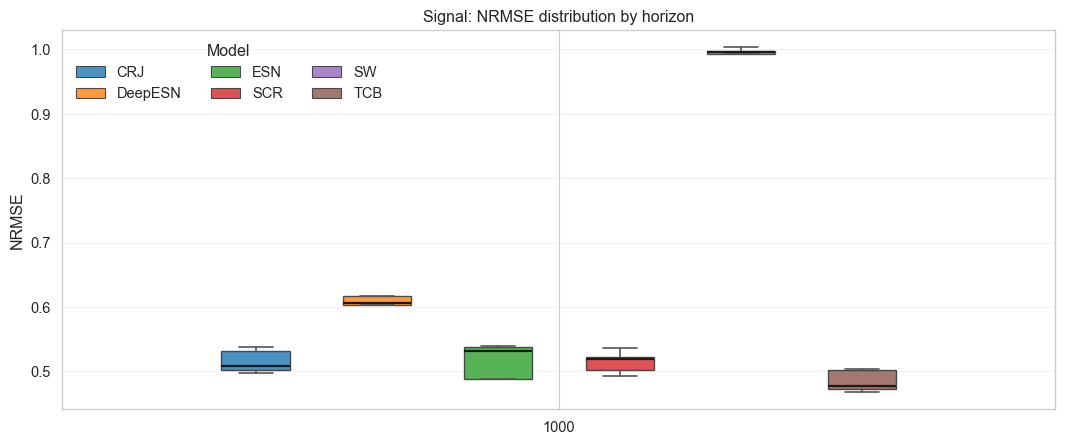

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/signal_box_nrmse_by_horizon.png


In [110]:
# ======================= NRMSE boxplots by horizon (from nrmse_dict) =======================

# ---- 1) Build a long DataFrame: Model × Horizon × NRMSE (across seeds/runs)
rows = []
for model, runs in nrmse_dict.items():
    # each 'runs[i]' is typically a dict {horizon -> nrmse}
    for run_idx, res in enumerate(runs):
        if isinstance(res, dict):
            for h, v in res.items():
                rows.append({"Model": model, "Horizon": int(h), "NRMSE": float(v), "Run": run_idx})
        else:
            # fallback: assume it's aligned with all_horizons list
            for h, v in zip(all_horizons, res):
                rows.append({"Model": model, "Horizon": int(h), "NRMSE": float(v), "Run": run_idx})

df_nrmse_h = pd.DataFrame(rows)
df_nrmse_h = df_nrmse_h.dropna(subset=["NRMSE"])
df_nrmse_h["Horizon"] = df_nrmse_h["Horizon"].astype(int)
df_nrmse_h = df_nrmse_h.sort_values(["Horizon", "Model"]).reset_index(drop=True)

# ---- 2) Plot manual grouped boxplot with small separation between models
SYSTEM  = globals().get("SYSTEM", "signal")
FIG_DIR = globals().get("FIG_DIR", Path("figs"))

#horizons = sorted(df_nrmse_h["Horizon"].unique())
horizons = [1000]
models   = sorted(df_nrmse_h["Model"].unique())
palette  = sns.color_palette("tab10", n_colors=len(models))
color_of = {m: palette[i] for i, m in enumerate(models)}

fig, ax = plt.subplots(figsize=(10.8, 4.6))

centers     = np.arange(len(horizons))          # one group per horizon
group_width = 0.82                               # total width reserved for a group
inner_gap   = 0.06                               # gap between adjacent model boxes
M           = max(1, len(models))
box_w       = (group_width - inner_gap*(M-1)) / M
start_off   = -group_width/2 + box_w/2
offsets     = start_off + np.arange(M) * (box_w + inner_gap)

# Collect data & positions for matplotlib.boxplot
all_data, positions, colors = [], [], []
for gi, h in enumerate(horizons):
    center = centers[gi]
    for mi, m in enumerate(models):
        vals = df_nrmse_h.query("Horizon == @h and Model == @m")["NRMSE"].values
        if vals.size == 0:
            continue
        all_data.append(vals)
        positions.append(center + offsets[mi])
        colors.append(color_of[m])

bp = ax.boxplot(
    all_data,
    positions=positions,
    widths=box_w * 0.95,
    patch_artist=True,
    showfliers=False,
    showcaps=True,
    medianprops=dict(color="#1a1a1a", linewidth=1.6),
    whiskerprops=dict(color="#555", linewidth=1.2),
    capprops=dict(color="#555", linewidth=1.2)
)

# Color each box
for patch, c in zip(bp["boxes"], colors):
    patch.set_facecolor(c)
    patch.set_edgecolor("#2b2b2b")
    patch.set_alpha(0.8)
    patch.set_linewidth(1.0)

# Ticks & labels
ax.set_xticks(centers)
ax.set_xticklabels([str(h) for h in horizons])
ax.set_xlim(centers[0] - 0.6, centers[-1] + 0.6)

# Light separators between horizon groups (optional)
for g in centers[:-1]:
    ax.axvline(g + 0.5, color="#e8e8e8", lw=0.6, zorder=0)

# Legend
handles = [Patch(facecolor=color_of[m], edgecolor="#2b2b2b", label=m, alpha=0.8) for m in models]
ax.legend(handles=handles, title="Model", ncol=3, frameon=False)

ax.set_ylabel("NRMSE")
ax.set_xlabel("")
ax.set_title(f"{SYSTEM.title()}: NRMSE distribution by horizon")
ax.grid(axis="y", alpha=0.25)

plt.tight_layout()
out_path = FIG_DIR / f"{SYSTEM}_box_nrmse_by_horizon.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
plt.show()
print(f"Saved: {out_path}")


In [108]:
print(horizons)

[300, 600, 1000]


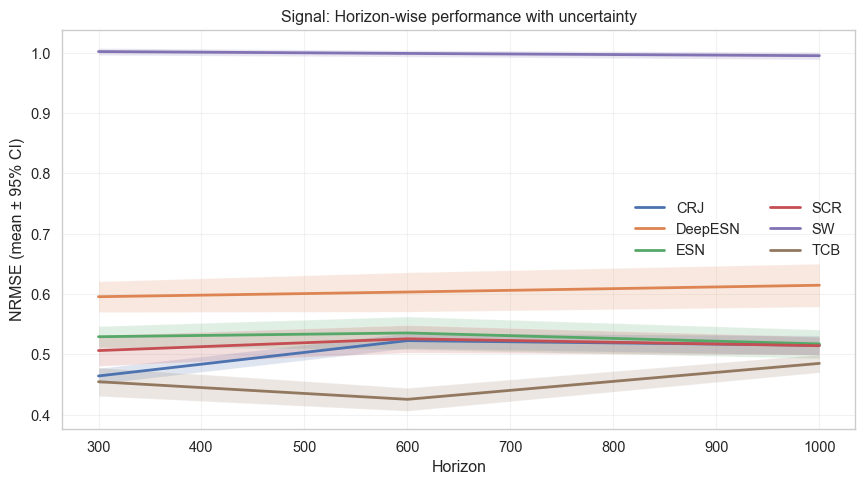

Saved: /Users/pep/Projects/setup/GitHub/Reservoir-Experiments/figures/signal_horizon_ribbons.png


In [114]:
# ============================================================
# Horizon curves with mean ± 95% CI ribbons (per model)
# ============================================================

# mean & CI per model × horizon
agg = (df_nrmse_h
       .groupby(["Model","Horizon"])["NRMSE"]
       .agg(["mean","std","count"])
       .reset_index())
agg["se"] = agg["std"] / np.sqrt(agg["count"].clip(lower=1))
agg["lo"] = agg["mean"] - 1.96 * agg["se"]
agg["hi"] = agg["mean"] + 1.96 * agg["se"]

plt.figure(figsize=(8.8, 5))
for m, sub in agg.groupby("Model"):
    sub = sub.sort_values("Horizon")
    plt.plot(sub["Horizon"], sub["mean"], label=m, linewidth=2)
    plt.fill_between(sub["Horizon"], sub["lo"], sub["hi"], alpha=0.18)

plt.xlabel("Horizon"); plt.ylabel("NRMSE (mean ± 95% CI)")
plt.title(f"{SYSTEM.title()}: Horizon-wise performance with uncertainty")
plt.legend(frameon=False, ncol=2)
plt.grid(alpha=0.25)
plt.tight_layout()
out = FIG_DIR / f"{SYSTEM}_horizon_ribbons.png"
plt.savefig(out, dpi=300, bbox_inches="tight"); plt.show()
print(f"Saved: {out}")
